# Client-Level Email Frequency Analysis - Visualization Guide

## Query 1: Daily Campaigns per Client Analysis

### Analysis Title: Daily Campaign Frequency Patterns by Client

**Business Insight:** Understanding which clients send emails most frequently on a daily basis and identifying daily sending patterns.

**Appropriate Visualization:** Heatmap Calendar - Perfect for showing daily patterns over time across multiple clients.

### READ DATA

In [54]:
import os, re
from typing import Optional
import aiofiles

SQL_DIR: str = os.path.join(os.path.abspath("../../"), "sql/commands/com/de/insight2")

class SqlQuery:
    @staticmethod
    async def read_sql(sql_name) -> str:
        try:
            SQL_PATH = os.path.join(SQL_DIR, f'{sql_name}.sql')
            async with aiofiles.open(SQL_PATH, 'r', encoding='utf-8') as file:
                return await file.read()
        except FileNotFoundError:
            print(f"File {SQL_PATH} not found.")
            return ""
        except Exception as e:
            print(f"An error occurred while reading {SQL_PATH}: {e}")
            return ""

In [55]:
SQL_NAME = "1_/1_1"
result = await SqlQuery.read_sql(SQL_NAME)
print(result)

-- Daily campaigns sent per client
SELECT 
    SPLIT_PART(campaign_name, ' - ', 1) as client,
    sending_date,
    COUNT(*) as campaigns_per_day,
    SUM(sent) as total_sent_per_day,
    AVG(sent) as avg_campaign_size,
    -- Client frequency pattern
    CASE 
        WHEN COUNT(*) >= 3 THEN 'High Daily Frequency'
        WHEN COUNT(*) = 2 THEN 'Medium Daily Frequency'
        WHEN COUNT(*) = 1 THEN 'Normal Daily Frequency'
        ELSE 'No Campaigns'
    END as daily_frequency_pattern
FROM records.email_campaigns
GROUP BY SPLIT_PART(campaign_name, ' - ', 1), sending_date
ORDER BY sending_date DESC, campaigns_per_day DESC;


In [45]:
!pip install asyncpg
import asyncio
import asyncpg
import pandas as pd

print ("Fetching data...")

async def fetch_data(query: str):
    conn = await asyncpg.connect(
        host=os.environ.get("DB_HOST", "localhost"),
        port=5433,
        user=os.environ.get("DB_USER", "auth_user"),
        password=os.environ.get("DB_PASSWORD", "auth_password"),
        database=os.environ.get("DB_NAME", "auth_db")
    )

    rows = await conn.fetch(query)
    
    # Convert to pandas DataFrame
    df = pd.DataFrame(rows, columns=rows[0].keys() if rows else [])
    await conn.close()
    return df

Fetching data...


In [47]:
# Run in Jupyter
df = await fetch_data(result)
df.head()

client sending_date  campaigns_per_day  \
0          Better Collective   2026-01-01                  1   
1  HeyPiggy (Jul25 Creative)   2026-01-01                  1   
2             Jupiter Gaming   2025-12-31                  1   
3                     XL Win   2025-12-31                  1   
4              Adstart Media   2025-12-30                  1   

   total_sent_per_day       avg_campaign_size daily_frequency_pattern  
0               29045      29045.000000000000  Normal Daily Frequency  
1               33770      33770.000000000000  Normal Daily Frequency  
2               14803  14803.0000000000000000  Normal Daily Frequency  
3               37495      37495.000000000000  Normal Daily Frequency  
4               42069      42069.000000000000  Normal Daily Frequency

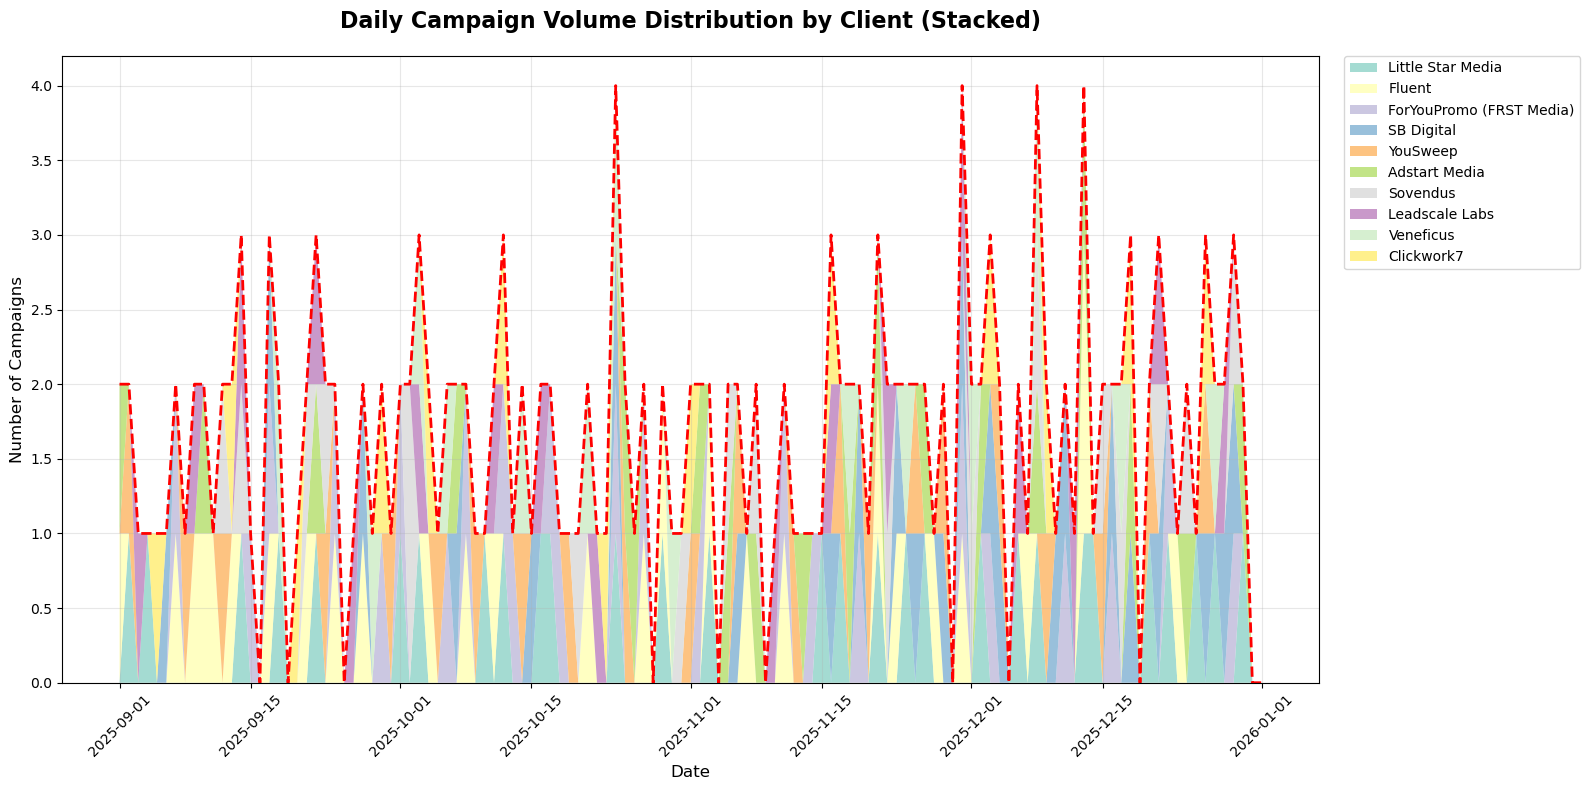

In [53]:
def create_stacked_area_chart(df_daily):
    """
    Creates a stacked area chart showing cumulative daily campaigns by client
    """
    # Prepare data for stacked area chart
    df_pivot = df_daily.pivot_table(
        index='sending_date',
        columns='client',
        values='campaigns_per_day',
        aggfunc='sum',
        fill_value=0
    )
    
    # Get top 10 clients for readability
    top_clients = df_pivot.sum().nlargest(10).index.tolist()
    df_top = df_pivot[top_clients]
    
    # Create figure
    fig, ax = plt.subplots(figsize=(16, 8))
    
    # Create stacked area chart
    ax.stackplot(df_top.index, df_top.T.values, labels=df_top.columns, 
                 alpha=0.8, colors=plt.cm.Set3(np.linspace(0, 1, len(df_top.columns))))
    
    ax.set_title('Daily Campaign Volume Distribution by Client (Stacked)', 
                 fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Number of Campaigns', fontsize=12)
    
    # Customize legend
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0., fontsize=10)
    
    # Add grid
    ax.grid(True, alpha=0.3)
    
    # Format x-axis
    ax.xaxis.set_tick_params(rotation=45)
    
    # Add total line
    total_campaigns = df_top.sum(axis=1)
    ax.plot(df_top.index, total_campaigns, color='red', linewidth=2, 
            linestyle='--', label='Total Campaigns')
    
    plt.tight_layout()
    plt.show()
    
create_stacked_area_chart(df)

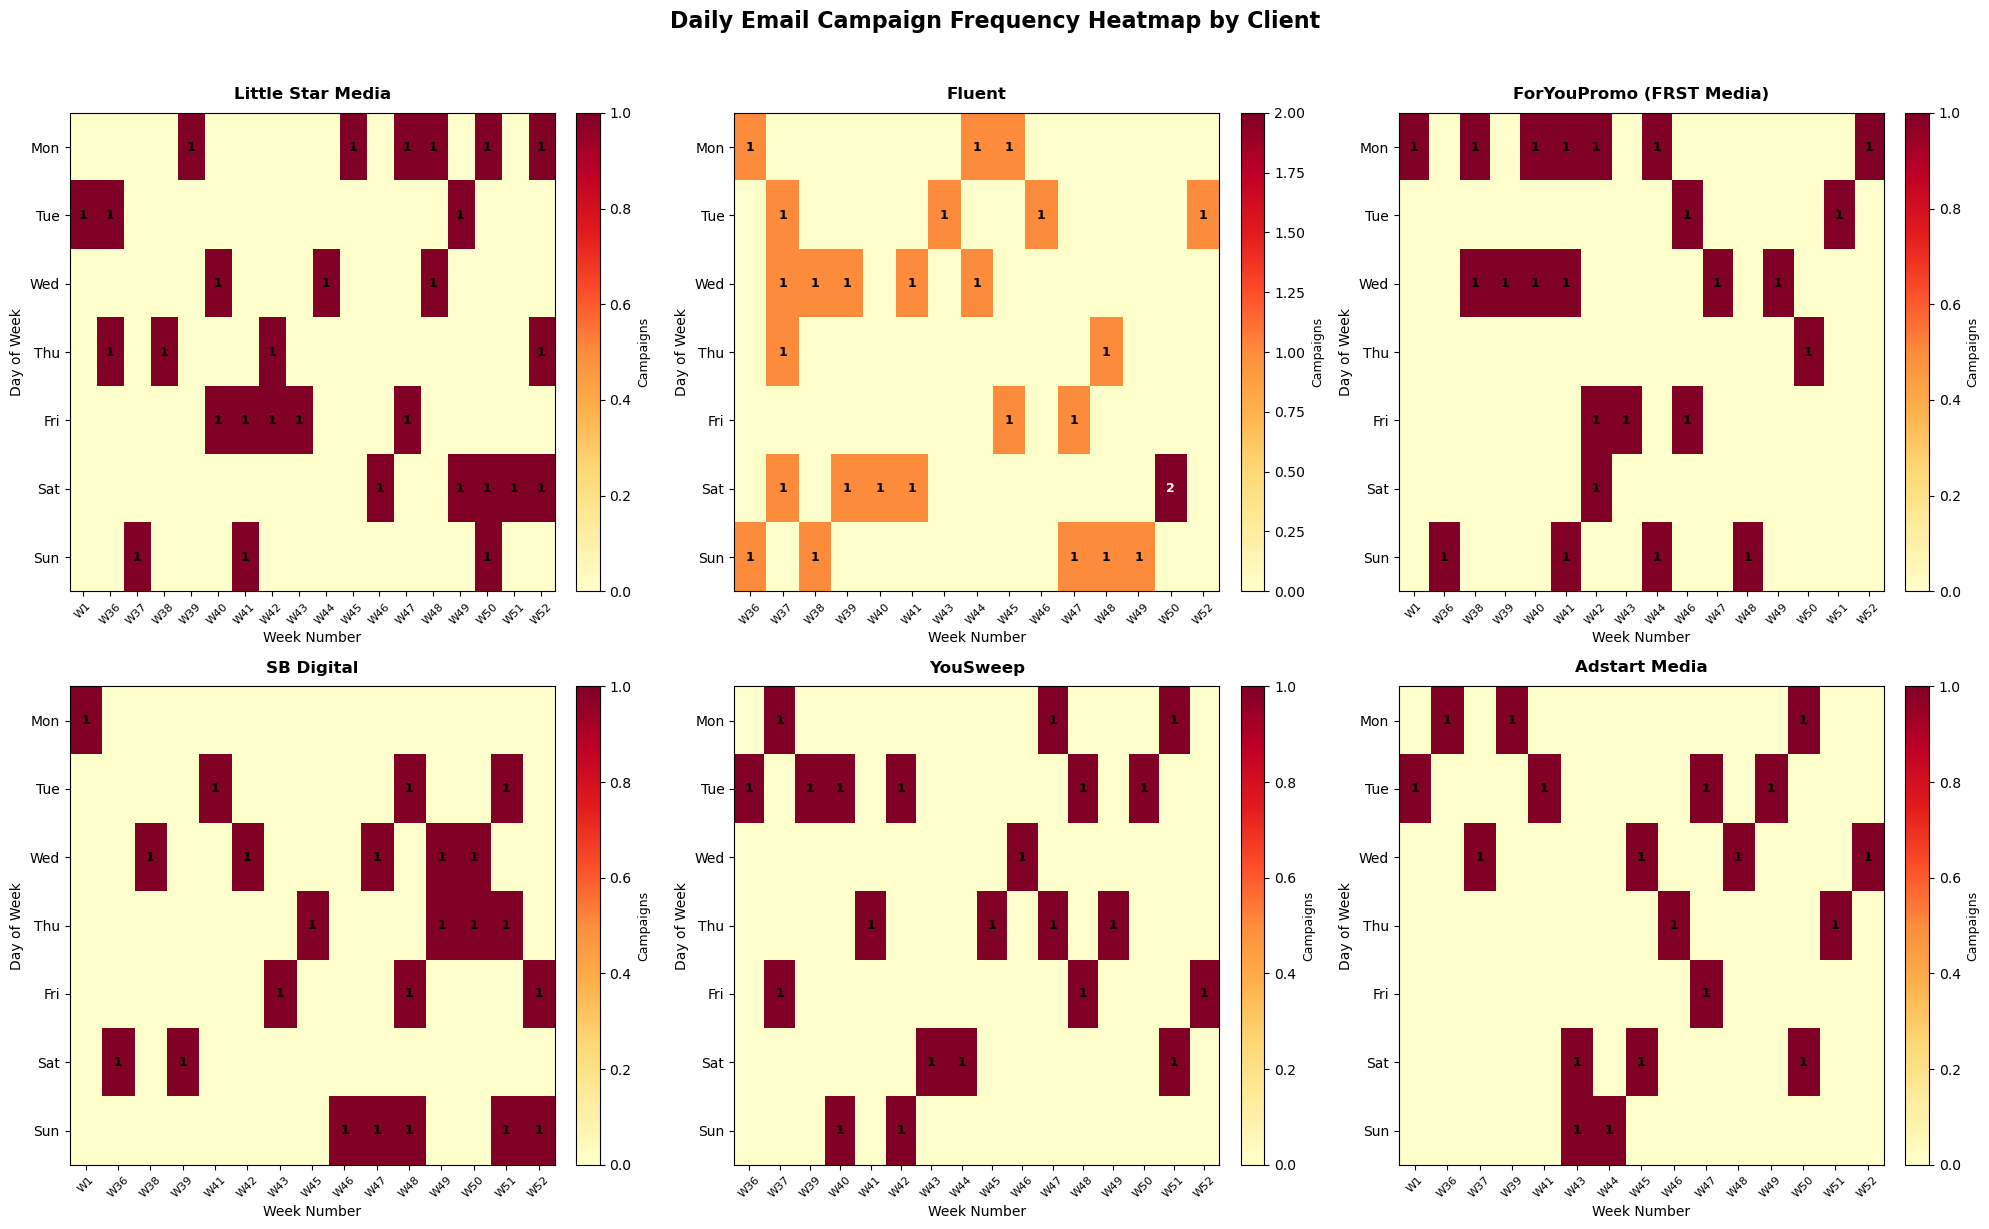

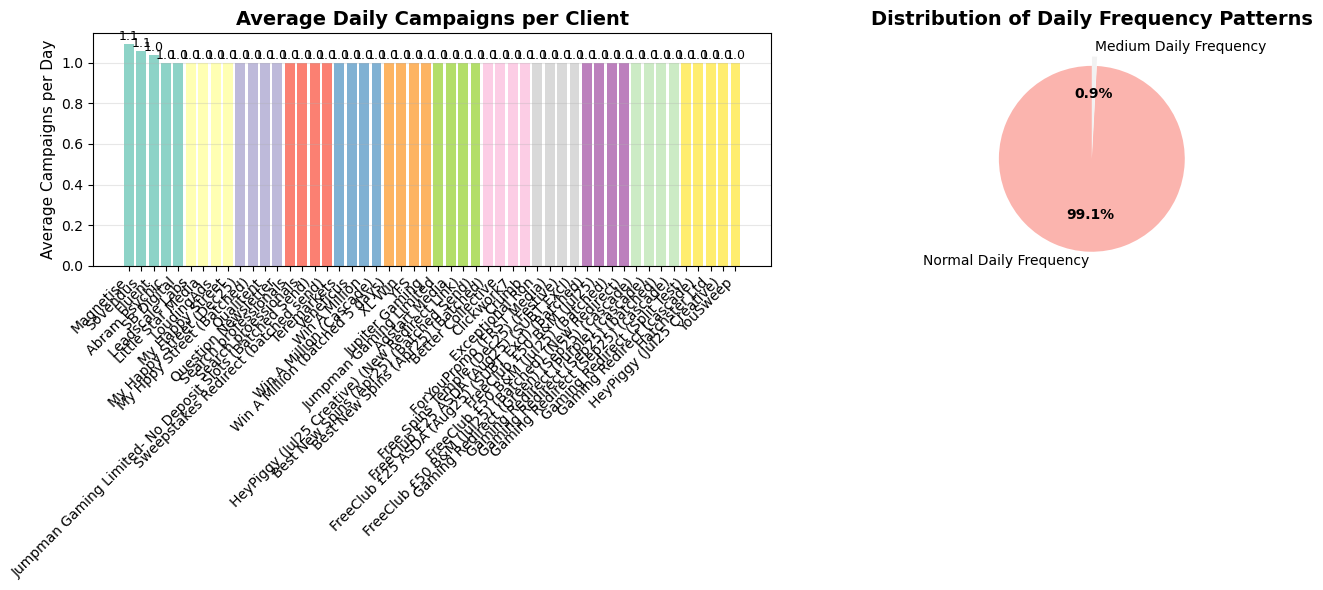

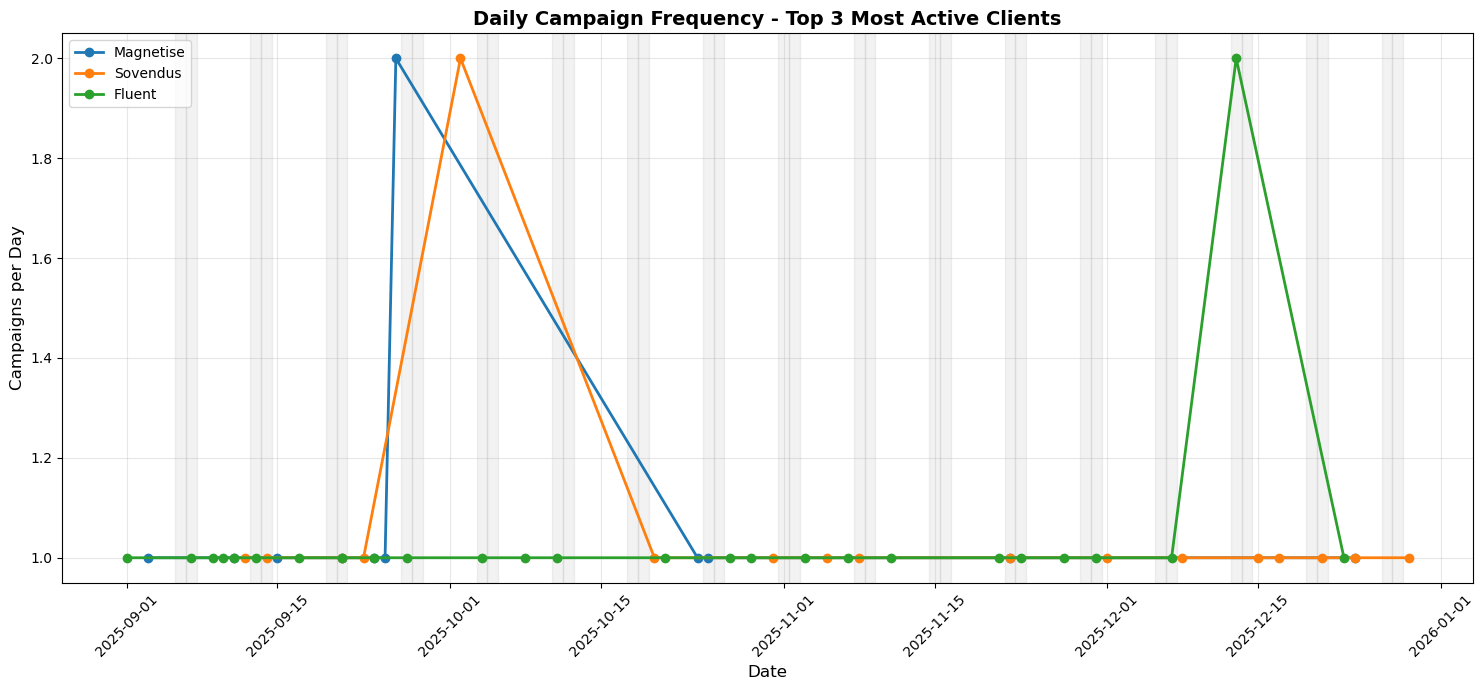

KEY INSIGHTS FROM DAILY FREQUENCY ANALYSIS
1. Most Active Client: Magnetise sends an average of 1.1 campaigns per day
2. Most Common Pattern: 346 days (99.1%) have 'Normal Daily Frequency'
3. Multiple Campaign Days: 3 days (0.9%) have more than 1 campaign
4. Weekend vs Weekday: 1.0 campaigns on weekdays vs 1.0 on weekends


In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.patches import Rectangle
import calendar

# Assuming your query result is in a DataFrame called df_daily
# Sample structure: ['client', 'sending_date', 'campaigns_per_day', 'total_sent_per_day', 'avg_campaign_size', 'daily_frequency_pattern']

def create_daily_frequency_calendar(df_daily):
    """
    Creates a calendar heatmap visualization for daily campaign frequency
    """
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('Daily Email Campaign Frequency Heatmap by Client', fontsize=16, fontweight='bold', y=1.02)
    
    # Get top 6 clients by total campaigns
    top_clients = df_daily.groupby('client')['campaigns_per_day'].sum().nlargest(6).index.tolist()
    
    # Ensure we have proper date formatting
    df_daily['sending_date'] = pd.to_datetime(df_daily['sending_date'])
    df_daily['month'] = df_daily['sending_date'].dt.month
    df_daily['day'] = df_daily['sending_date'].dt.day
    df_daily['weekday'] = df_daily['sending_date'].dt.weekday
    df_daily['week_number'] = df_daily['sending_date'].dt.isocalendar().week
    
    for idx, client in enumerate(top_clients[:6]):
        ax = axes[idx // 3, idx % 3]
        
        # Filter data for this client
        client_data = df_daily[df_daily['client'] == client].copy()
        
        # Create pivot table for heatmap (Weekday vs Week Number)
        pivot_data = client_data.pivot_table(
            index='weekday',
            columns='week_number',
            values='campaigns_per_day',
            aggfunc='sum',
            fill_value=0
        )
        
        # Create heatmap
        im = ax.imshow(pivot_data.values, cmap='YlOrRd', aspect='auto')
        
        # Customize axes
        ax.set_xticks(range(len(pivot_data.columns)))
        ax.set_xticklabels([f'W{int(w)}' for w in pivot_data.columns], rotation=45, fontsize=8)
        ax.set_yticks(range(7))
        ax.set_yticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
        
        # Add text annotations
        for i in range(pivot_data.shape[0]):
            for j in range(pivot_data.shape[1]):
                value = pivot_data.iloc[i, j]
                if value > 0:
                    ax.text(j, i, f'{int(value)}', ha='center', va='center', 
                           fontsize=9, fontweight='bold', color='white' if value > 1 else 'black')
        
        ax.set_title(f'{client}', fontsize=12, fontweight='bold', pad=10)
        ax.set_xlabel('Week Number', fontsize=10)
        ax.set_ylabel('Day of Week', fontsize=10)
        
        # Add colorbar for each subplot
        cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label('Campaigns', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Create summary statistics bar chart
    fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Average campaigns per day by client
    avg_daily = df_daily.groupby('client')['campaigns_per_day'].mean().sort_values(ascending=False)
    colors = plt.cm.Set3(np.linspace(0, 1, len(avg_daily)))
    
    ax1.bar(range(len(avg_daily)), avg_daily.values, color=colors)
    ax1.set_xticks(range(len(avg_daily)))
    ax1.set_xticklabels(avg_daily.index, rotation=45, ha='right', fontsize=10)
    ax1.set_title('Average Daily Campaigns per Client', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Average Campaigns per Day', fontsize=11)
    ax1.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for i, v in enumerate(avg_daily.values):
        ax1.text(i, v + 0.02, f'{v:.1f}', ha='center', fontsize=9)
    
    # Daily frequency pattern distribution
    pattern_counts = df_daily['daily_frequency_pattern'].value_counts()
    explode = [0.1 if i == 0 else 0 for i in range(len(pattern_counts))]
    
    wedges, texts, autotexts = ax2.pie(pattern_counts.values, 
                                        labels=pattern_counts.index, 
                                        autopct='%1.1f%%',
                                        startangle=90,
                                        explode=explode,
                                        colors=plt.cm.Pastel1(np.linspace(0, 1, len(pattern_counts))))
    
    ax2.set_title('Distribution of Daily Frequency Patterns', fontsize=14, fontweight='bold')
    
    # Make autotexts bold
    for autotext in autotexts:
        autotext.set_fontsize(10)
        autotext.set_fontweight('bold')
    
    plt.tight_layout()
    plt.show()
    
    # Create time series line chart for top 3 clients
    fig3, ax3 = plt.subplots(figsize=(15, 7))
    
    top_3_clients = avg_daily.nlargest(3).index
    for client in top_3_clients:
        client_ts = df_daily[df_daily['client'] == client].sort_values('sending_date')
        ax3.plot(client_ts['sending_date'], client_ts['campaigns_per_day'], 
                marker='o', linewidth=2, markersize=6, label=client)
    
    ax3.set_title('Daily Campaign Frequency - Top 3 Most Active Clients', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Date', fontsize=12)
    ax3.set_ylabel('Campaigns per Day', fontsize=12)
    ax3.legend(loc='upper left', fontsize=10)
    ax3.grid(True, alpha=0.3)
    ax3.tick_params(axis='x', rotation=45)
    
    # Add shaded background for weekends
    dates = df_daily['sending_date'].unique()
    for date in sorted(dates):
        date_obj = pd.to_datetime(date)
        if date_obj.weekday() >= 5:  # Saturday or Sunday
            ax3.axvspan(date_obj - pd.Timedelta(hours=12), 
                       date_obj + pd.Timedelta(hours=12), 
                       alpha=0.1, color='gray')
    
    plt.tight_layout()
    plt.show()
    
    # Print insights
    print("=" * 80)
    print("KEY INSIGHTS FROM DAILY FREQUENCY ANALYSIS")
    print("=" * 80)
    
    # Insight 1: Most active client
    most_active = avg_daily.idxmax()
    print(f"1. Most Active Client: {most_active} sends an average of {avg_daily.max():.1f} campaigns per day")
    
    # Insight 2: Daily pattern distribution
    most_common_pattern = pattern_counts.idxmax()
    print(f"2. Most Common Pattern: {pattern_counts.max()} days ({pattern_counts.max()/len(df_daily)*100:.1f}%) have '{most_common_pattern}'")
    
    # Insight 3: Days with multiple campaigns
    multi_campaign_days = len(df_daily[df_daily['campaigns_per_day'] > 1])
    print(f"3. Multiple Campaign Days: {multi_campaign_days} days ({multi_campaign_days/len(df_daily)*100:.1f}%) have more than 1 campaign")
    
    # Insight 4: Weekend vs weekday sending
    df_daily['is_weekend'] = df_daily['sending_date'].dt.weekday >= 5
    weekend_avg = df_daily[df_daily['is_weekend']]['campaigns_per_day'].mean()
    weekday_avg = df_daily[~df_daily['is_weekend']]['campaigns_per_day'].mean()
    print(f"4. Weekend vs Weekday: {weekday_avg:.1f} campaigns on weekdays vs {weekend_avg:.1f} on weekends")
    
    print("=" * 80)

# Execute the visualization
create_daily_frequency_calendar(df)

# Weekly Campaign Frequency Analysis - Visualization Guide
## Query 2: Weekly Campaigns per Client Analysis
### Analysis Title: Weekly Email Campaign Patterns and Client Sending Behavior

**Business Insight:** Understanding weekly sending patterns, identifying peak weeks, and comparing client sending strategies across time.

**Appropriate Visualizations:** Multiple complementary charts to reveal different aspects of weekly patterns.

In [62]:
SQL_NAME = "1_/1_2"
result = await SqlQuery.read_sql(SQL_NAME)

In [63]:
# Run in Jupyter
df = await fetch_data(result)
df.head()

client  year week  campaigns_per_week  \
0  HeyPiggy (Jul25 Creative)  2026    1                   1   
1          Better Collective  2026    1                   1   
2          Little Star Media  2025   52                   3   
3                 SB Digital  2025   52                   2   
4   ForYouPromo (FRST Media)  2025   52                   1   

   total_sent_per_week   avg_campaign_size  active_days_per_week  \
0                33770  33770.000000000000                     1   
1                29045  29045.000000000000                     1   
2                63361  21120.333333333333                     3   
3                33039  16519.500000000000                     2   
4                24767  24767.000000000000                     1   

  avg_campaigns_per_active_day weekly_frequency_category  
0                         1.00      Low Weekly Frequency  
1                         1.00      Low Weekly Frequency  
2                         1.00      Low Weekly Frequency  
3                         1.00      Low Weekly Frequency  
4                         1.00      Low Weekly Frequency

WEEKLY FREQUENCY ANALYSIS - KEY INSIGHTS
📊 OVERVIEW:
   • Total weeks analyzed: 19
   • Total campaigns sent: 352
   • Average campaigns per week: 1.3

🏆 TOP PERFORMERS (by average weekly campaigns):
   1. Fluent: 1.8 campaigns/week
   2. Magnetise: 1.7 campaigns/week
   3. YFS: 1.7 campaigns/week

📈 FREQUENCY DISTRIBUTION:
   • Low Weekly Frequency: 278 weeks (99.3%)
   • Medium Weekly Frequency: 2 weeks (0.7%)

📅 PEAK ACTIVITY:
   • Peak week: 2025-09-29
   • Client: Magnetise
   • Campaigns: 4
   • Total sent: 51,538

🎯 CONSISTENCY ANALYSIS:
   • Most consistent: LoudingAds (CV: 0.00)
   • Least consistent: YFS (CV: 0.69)

💡 STRATEGIC RECOMMENDATIONS:
   • CONSIDER INCREASING FREQUENCY:
     - Sovendus (1.4 campaigns/week)
     - YouSweep (1.4 campaigns/week)
     - FreeClub £25 ASDA (Aug25) (SUBT Excl) (1.3 campaigns/week)
   • AVERAGE CAMPAIGN SIZE: 26,799 emails per campaign



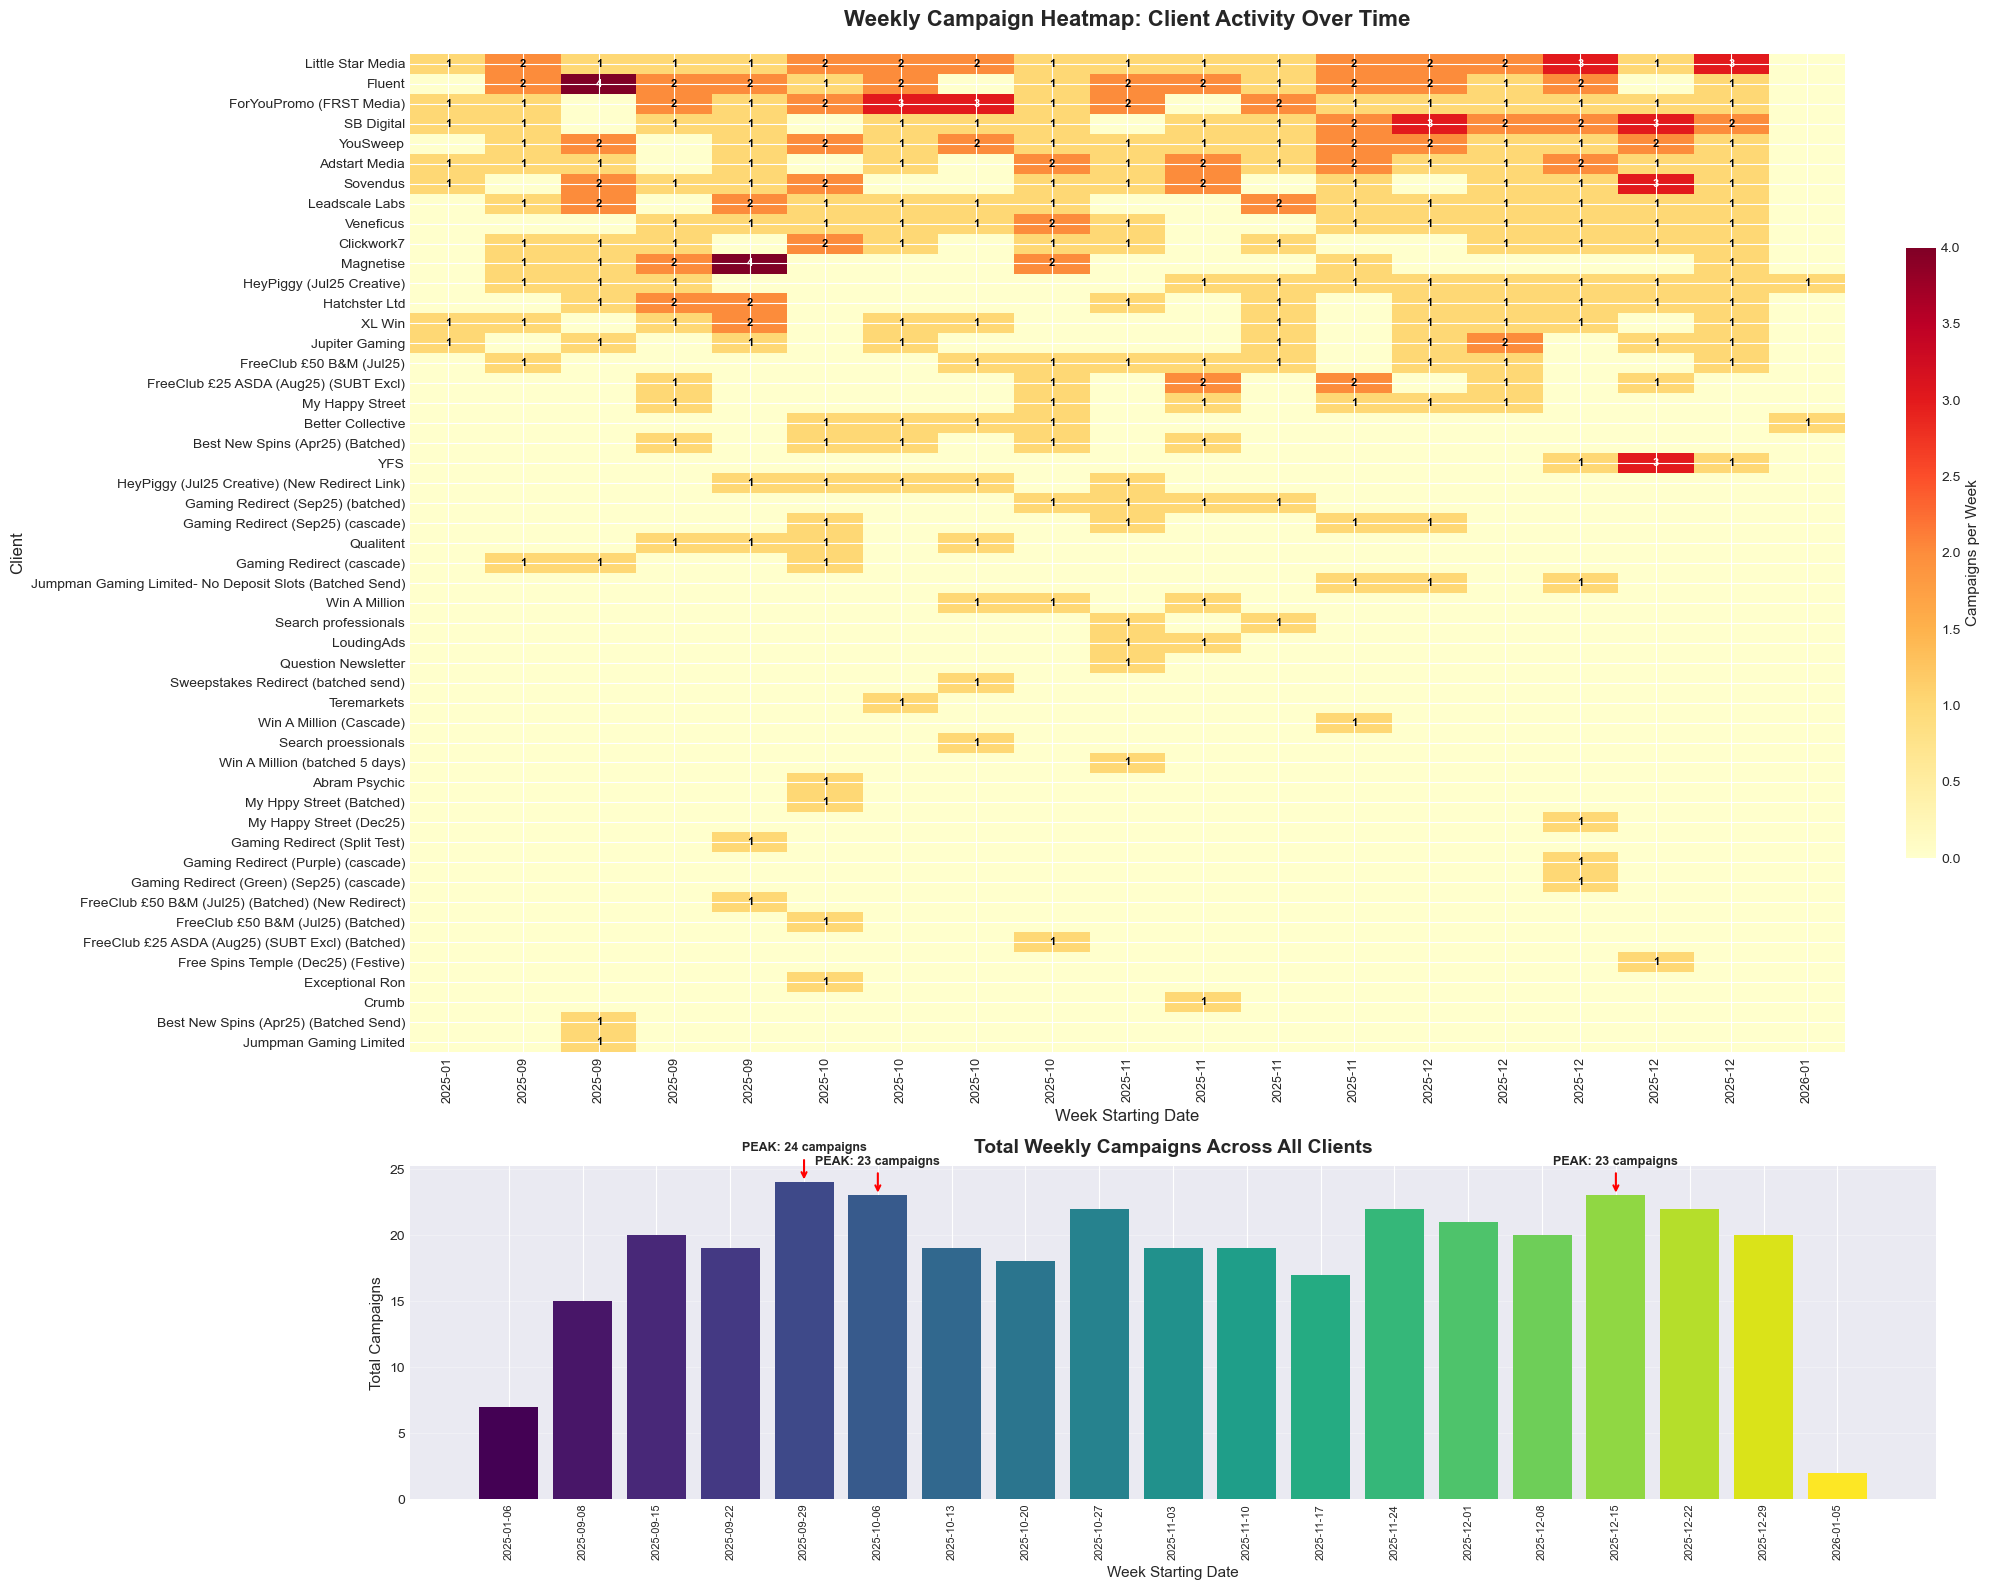

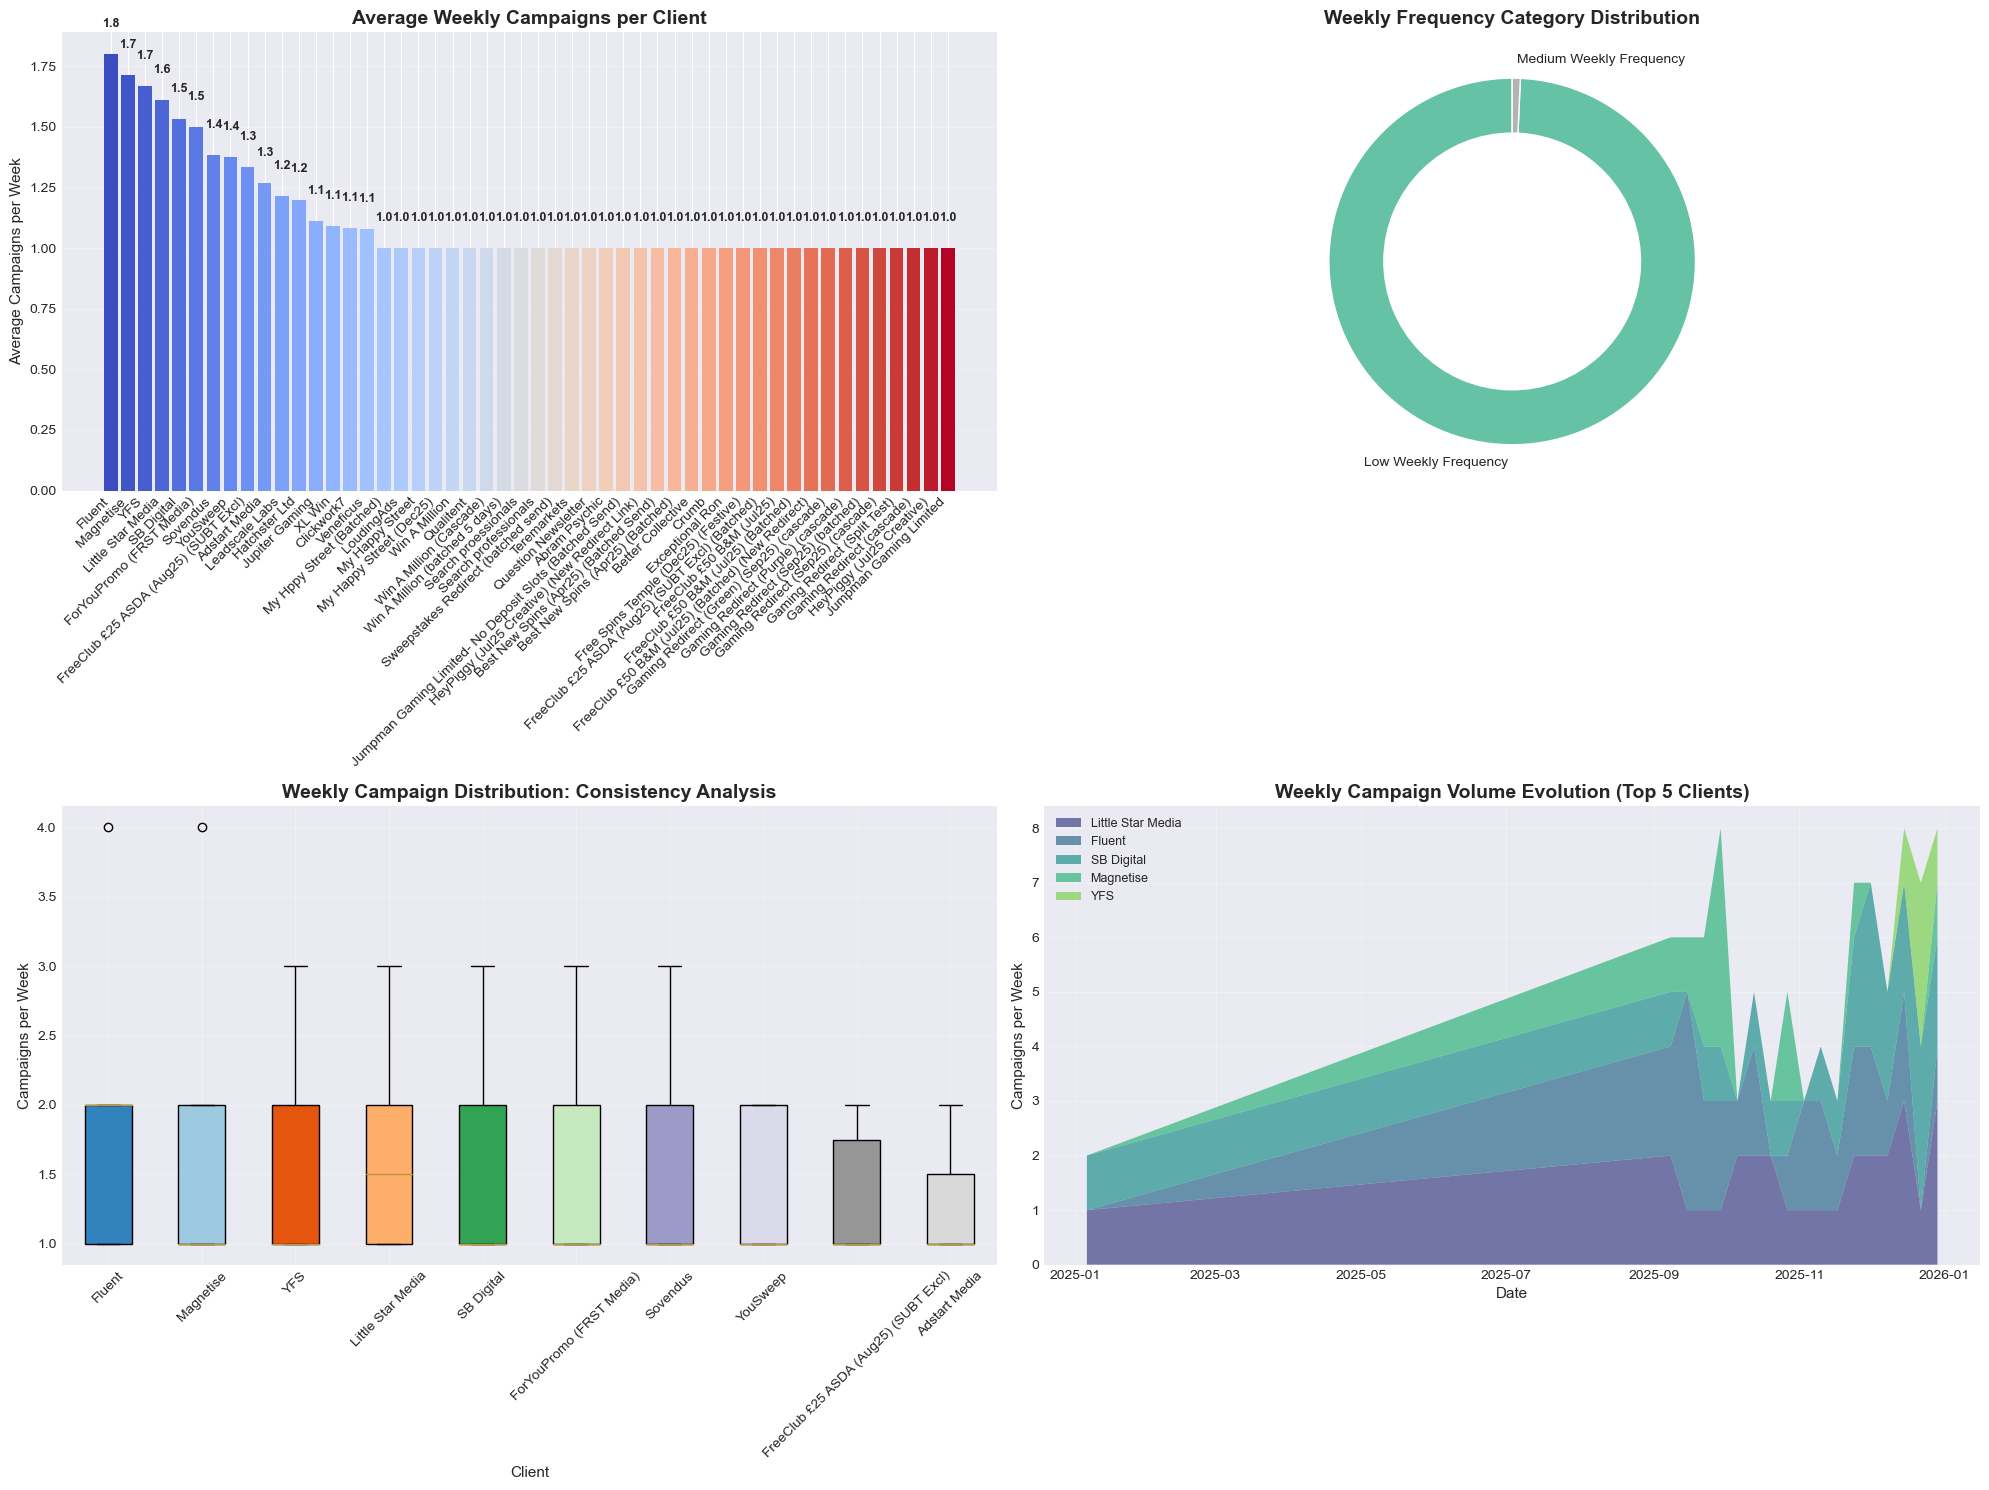

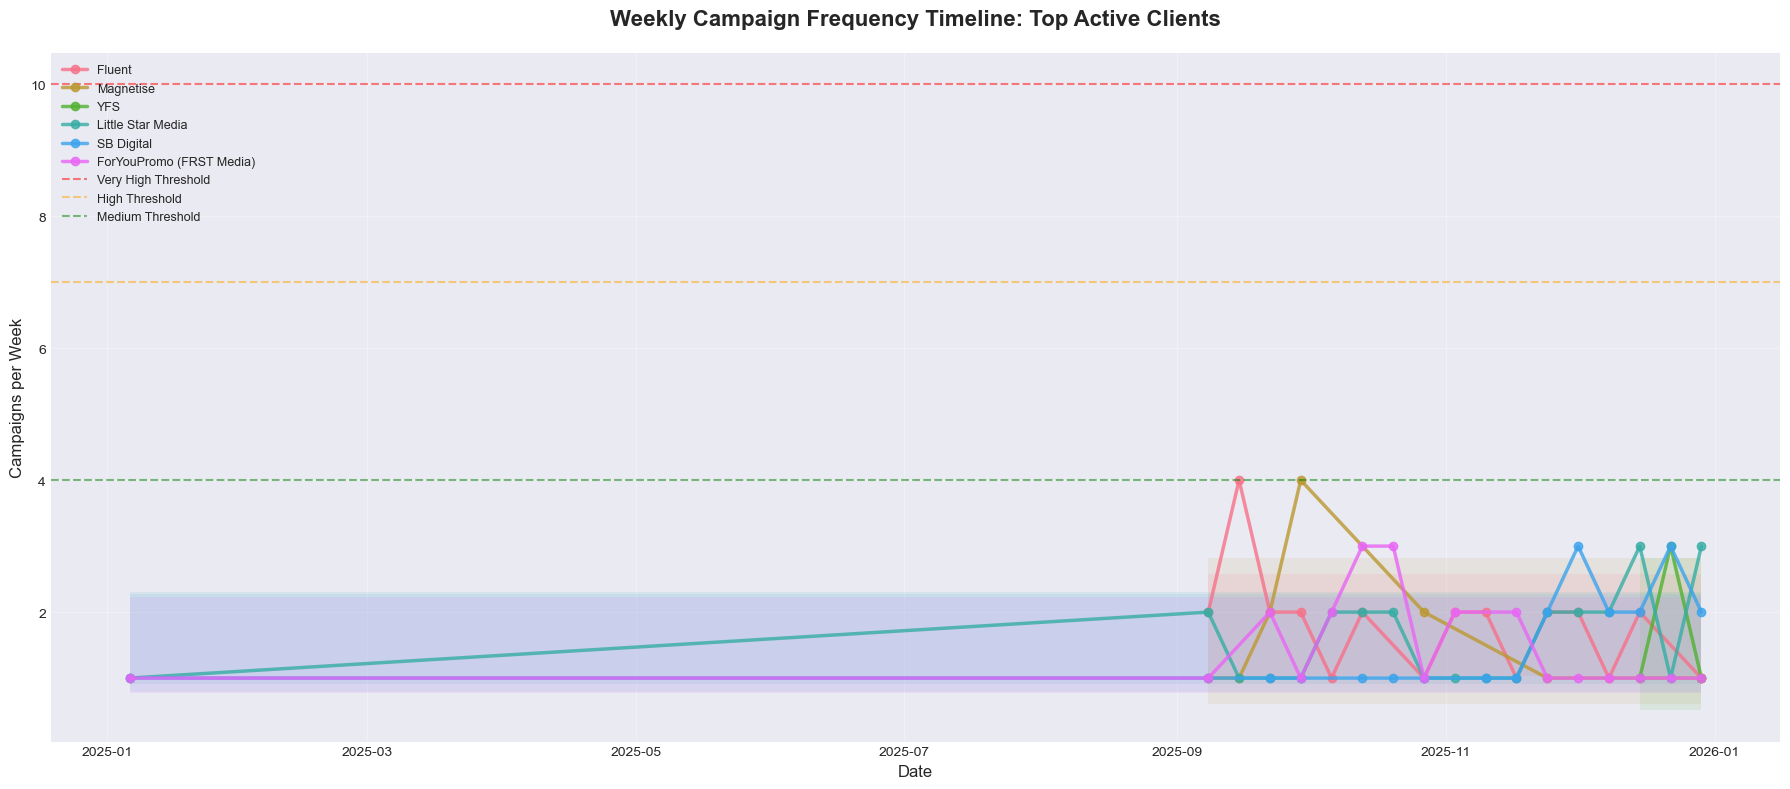

AttributeError: 'float' object has no attribute 'shape'

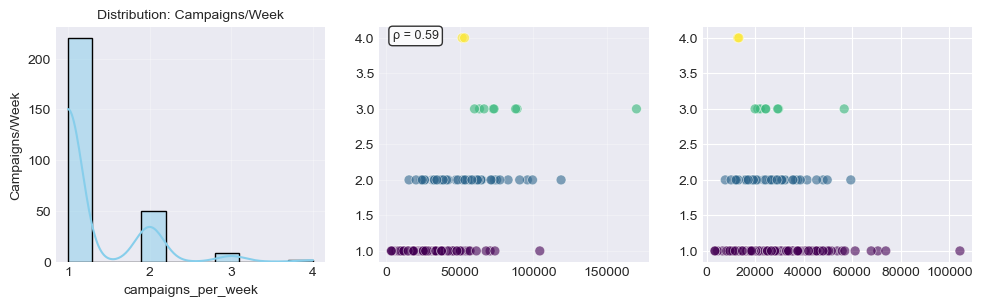

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import warnings
warnings.filterwarnings('ignore')

def create_weekly_frequency_analysis(df_weekly):
    """
    Comprehensive visualization suite for weekly campaign frequency analysis
    """
    # Set style
    plt.style.use('seaborn-v0_8-darkgrid')
    sns.set_palette("husl")
    
    # Convert year-week to datetime for better plotting
    df_weekly['year_week'] = df_weekly['year'].astype(str) + '-W' + df_weekly['week'].astype(str).str.zfill(2)
    df_weekly['date'] = pd.to_datetime(df_weekly['year_week'] + '-1', format='%Y-W%W-%w')
    
    # ========== 1. HEATMAP: Weekly Campaign Volume Across Clients ==========
    print("=" * 100)
    print("WEEKLY FREQUENCY ANALYSIS - KEY INSIGHTS")
    print("=" * 100)
    
    # Calculate insights before visualization
    total_weeks = len(df_weekly['date'].unique())
    total_campaigns = df_weekly['campaigns_per_week'].sum()
    avg_campaigns_per_week = df_weekly['campaigns_per_week'].mean()
    avg_weekly = df_weekly.groupby('client')['campaigns_per_week'].mean().sort_values(ascending=False)
    category_counts = df_weekly['weekly_frequency_category'].value_counts()
    
    # Insight 1: Overall statistics
    print(f"📊 OVERVIEW:")
    print(f"   • Total weeks analyzed: {total_weeks}")
    print(f"   • Total campaigns sent: {total_campaigns}")
    print(f"   • Average campaigns per week: {avg_campaigns_per_week:.1f}")
    print()
    
    # Insight 2: Top performers
    print(f"🏆 TOP PERFORMERS (by average weekly campaigns):")
    for i, (client, value) in enumerate(avg_weekly.head(3).items(), 1):
        print(f"   {i}. {client}: {value:.1f} campaigns/week")
    print()
    
    # Insight 3: Frequency distribution
    print(f"📈 FREQUENCY DISTRIBUTION:")
    for category, count in category_counts.items():
        percentage = (count / len(df_weekly)) * 100
        print(f"   • {category}: {count} weeks ({percentage:.1f}%)")
    print()
    
    # Insight 4: Peak detection
    peak_week_idx = df_weekly['campaigns_per_week'].idxmax()
    peak_week = df_weekly.loc[peak_week_idx]
    print(f"📅 PEAK ACTIVITY:")
    print(f"   • Peak week: {peak_week['date'].strftime('%Y-%m-%d') if 'date' in peak_week else 'N/A'}")
    print(f"   • Client: {peak_week['client']}")
    print(f"   • Campaigns: {peak_week['campaigns_per_week']}")
    print(f"   • Total sent: {peak_week['total_sent_per_week']:,}")
    print()
    
    # Insight 5: Consistency analysis
    print(f"🎯 CONSISTENCY ANALYSIS:")
    consistency_scores = {}
    for client in avg_weekly.index:
        client_data = df_weekly[df_weekly['client'] == client]['campaigns_per_week']
        if len(client_data) > 1:
            cv = client_data.std() / client_data.mean()  # Coefficient of variation
            consistency_scores[client] = cv
    
    if consistency_scores:
        most_consistent = min(consistency_scores, key=consistency_scores.get)
        least_consistent = max(consistency_scores, key=consistency_scores.get)
        print(f"   • Most consistent: {most_consistent} (CV: {consistency_scores[most_consistent]:.2f})")
        print(f"   • Least consistent: {least_consistent} (CV: {consistency_scores[least_consistent]:.2f})")
    else:
        print("   • Insufficient data for consistency analysis")
    print()
    
    # Insight 6: Strategic recommendations
    print(f"💡 STRATEGIC RECOMMENDATIONS:")
    
    # Identify clients that might be under-sending
    under_sending = []
    for client in avg_weekly.index:
        client_avg = avg_weekly[client]
        client_weeks = len(df_weekly[df_weekly['client'] == client])
        if client_avg < 1.5 and client_weeks > 2:
            under_sending.append(f"{client} ({client_avg:.1f} campaigns/week)")
    
    if under_sending:
        print(f"   • CONSIDER INCREASING FREQUENCY:")
        for client_info in under_sending[:3]:  # Show top 3
            print(f"     - {client_info}")
    
    # Identify clients that might be over-sending
    high_freq_clients = avg_weekly[avg_weekly > 7].index.tolist()
    if high_freq_clients:
        print(f"   • MONITOR FOR FATIGUE: {', '.join(high_freq_clients[:3])} send >7 campaigns/week")
    
    # Campaign size efficiency
    if 'avg_campaign_size' in df_weekly.columns:
        avg_campaign_size = df_weekly['avg_campaign_size'].mean()
        print(f"   • AVERAGE CAMPAIGN SIZE: {avg_campaign_size:,.0f} emails per campaign")
    
    print("=" * 100)
    print()
    
    # ========== NOW CREATE VISUALIZATIONS ==========
    
    fig1, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 16), 
                                     gridspec_kw={'height_ratios': [3, 1]})
    
    # Create pivot table for heatmap
    heatmap_data = df_weekly.pivot_table(
        index='client',
        columns='date',
        values='campaigns_per_week',
        aggfunc='sum',
        fill_value=0
    )
    
    # Sort by total campaigns
    heatmap_data = heatmap_data.loc[heatmap_data.sum(axis=1).sort_values(ascending=False).index]
    
    # Create heatmap
    im = ax1.imshow(heatmap_data.values, aspect='auto', cmap='YlOrRd', 
                    interpolation='nearest', vmin=0, vmax=heatmap_data.values.max())
    
    # Customize heatmap
    ax1.set_xticks(range(len(heatmap_data.columns)))
    ax1.set_xticklabels([d.strftime('%Y-%m') for d in heatmap_data.columns], 
                       rotation=90, fontsize=9)
    ax1.set_yticks(range(len(heatmap_data.index)))
    ax1.set_yticklabels(heatmap_data.index, fontsize=10)
    
    # Add value labels for significant values
    for i in range(heatmap_data.shape[0]):
        for j in range(heatmap_data.shape[1]):
            value = heatmap_data.iloc[i, j]
            if value > 0:
                ax1.text(j, i, f'{int(value)}', ha='center', va='center', 
                        fontsize=8, fontweight='bold',
                        color='white' if value > heatmap_data.values.max()/2 else 'black')
    
    ax1.set_title('Weekly Campaign Heatmap: Client Activity Over Time', 
                 fontsize=16, fontweight='bold', pad=20)
    ax1.set_xlabel('Week Starting Date', fontsize=12)
    ax1.set_ylabel('Client', fontsize=12)
    
    # Add colorbar
    cbar = fig1.colorbar(im, ax=ax1, orientation='vertical', fraction=0.02, pad=0.04)
    cbar.set_label('Campaigns per Week', fontsize=11)
    
    # ========== 2. BAR CHART: Weekly Campaign Distribution ==========
    # Calculate weekly totals
    weekly_totals = df_weekly.groupby('date')['campaigns_per_week'].sum()
    
    ax2.bar(range(len(weekly_totals)), weekly_totals.values, 
           color=plt.cm.viridis(np.linspace(0, 1, len(weekly_totals))))
    
    ax2.set_xticks(range(len(weekly_totals)))
    ax2.set_xticklabels([d.strftime('%Y-%m-%d') for d in weekly_totals.index], 
                       rotation=90, fontsize=8)
    ax2.set_title('Total Weekly Campaigns Across All Clients', 
                 fontsize=14, fontweight='bold', pad=10)
    ax2.set_ylabel('Total Campaigns', fontsize=11)
    ax2.set_xlabel('Week Starting Date', fontsize=11)
    ax2.grid(axis='y', alpha=0.3)
    
    # Highlight peak weeks
    peak_weeks = weekly_totals.nlargest(min(3, len(weekly_totals)))
    for idx, (date, value) in enumerate(peak_weeks.items()):
        pos = list(weekly_totals.index).index(date)
        ax2.annotate(f'PEAK: {value} campaigns', 
                    xy=(pos, value), 
                    xytext=(0, 20), 
                    textcoords='offset points',
                    ha='center', va='bottom',
                    fontsize=9, fontweight='bold',
                    arrowprops=dict(arrowstyle='->', color='red', lw=1.5))
    
    plt.tight_layout()
    plt.show()
    
    # ========== 3. MULTI-PANEL: Client Comparison Dashboard ==========
    fig3, ((ax3, ax4), (ax5, ax6)) = plt.subplots(2, 2, figsize=(20, 15))
    
    # Panel 3A: Average Campaigns per Week by Client (Bar Chart)
    colors_bar = plt.cm.coolwarm(np.linspace(0, 1, len(avg_weekly)))
    
    bars = ax3.bar(range(len(avg_weekly)), avg_weekly.values, color=colors_bar)
    ax3.set_xticks(range(len(avg_weekly)))
    ax3.set_xticklabels(avg_weekly.index, rotation=45, ha='right', fontsize=10)
    ax3.set_title('Average Weekly Campaigns per Client', fontsize=14, fontweight='bold')
    ax3.set_ylabel('Average Campaigns per Week', fontsize=11)
    ax3.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for bar, value in zip(bars, avg_weekly.values):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{value:.1f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # Panel 3B: Weekly Frequency Category Distribution (Donut Chart - FIXED)
    # Outer pie (donut)
    wedges, texts, autotexts = ax4.pie(category_counts.values,
                                        labels=category_counts.index,
                                        autopct='%1.1f%%',
                                        startangle=90,
                                        colors=plt.cm.Set2(np.linspace(0, 1, len(category_counts))),
                                        wedgeprops=dict(width=0.3, edgecolor='w'))
    
    # Create a white circle in the center for donut effect
    centre_circle = plt.Circle((0,0), 0.70, fc='white')
    ax4.add_artist(centre_circle)
    
    ax4.set_title('Weekly Frequency Category Distribution', fontsize=14, fontweight='bold')
    
    # Make autotexts bold and adjust position
    for autotext in autotexts:
        autotext.set_fontsize(10)
        autotext.set_fontweight('bold')
        autotext.set_color('white')
    
    # Panel 3C: Box Plot - Campaign Distribution by Client
    top_10_clients = avg_weekly.head(min(10, len(avg_weekly))).index
    box_data = [df_weekly[df_weekly['client'] == client]['campaigns_per_week'].values 
                for client in top_10_clients]
    
    bp = ax5.boxplot(box_data, labels=top_10_clients, patch_artist=True)
    
    # Customize box plot colors
    colors_box = plt.cm.tab20c(np.linspace(0, 1, len(top_10_clients)))
    for patch, color in zip(bp['boxes'], colors_box):
        patch.set_facecolor(color)
    
    ax5.set_title('Weekly Campaign Distribution: Consistency Analysis', 
                 fontsize=14, fontweight='bold')
    ax5.set_ylabel('Campaigns per Week', fontsize=11)
    ax5.set_xlabel('Client', fontsize=11)
    ax5.tick_params(axis='x', rotation=45)
    ax5.grid(True, alpha=0.3)
    
    # Panel 3D: Stacked Area Chart - Campaign Volume Over Time (Top 5 Clients)
    top_5_clients = avg_weekly.head(min(5, len(avg_weekly))).index
    stacked_data = df_weekly[df_weekly['client'].isin(top_5_clients)].pivot_table(
        index='date',
        columns='client',
        values='campaigns_per_week',
        aggfunc='sum',
        fill_value=0
    )
    
    # Sort columns by total volume
    stacked_data = stacked_data[stacked_data.sum().sort_values(ascending=False).index]
    
    if not stacked_data.empty:
        ax6.stackplot(stacked_data.index, 
                      [stacked_data[client] for client in stacked_data.columns],
                      labels=stacked_data.columns,
                      alpha=0.7,
                      colors=plt.cm.viridis(np.linspace(0.2, 0.8, len(stacked_data.columns))))
        
        ax6.set_title('Weekly Campaign Volume Evolution (Top 5 Clients)', 
                     fontsize=14, fontweight='bold')
        ax6.set_xlabel('Date', fontsize=11)
        ax6.set_ylabel('Campaigns per Week', fontsize=11)
        ax6.legend(loc='upper left', fontsize=9)
        ax6.grid(True, alpha=0.3)
    else:
        ax6.text(0.5, 0.5, 'Insufficient data for stacked area chart', 
                ha='center', va='center', fontsize=12, transform=ax6.transAxes)
        ax6.set_title('Weekly Campaign Volume Evolution', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # ========== 4. TIME SERIES: Client Activity Comparison ==========
    fig4, ax7 = plt.subplots(figsize=(18, 8))
    
    # Get top 6 most active clients
    top_n_clients = avg_weekly.head(min(6, len(avg_weekly))).index
    
    # Create line plot for each client
    for idx, client in enumerate(top_n_clients):
        client_data = df_weekly[df_weekly['client'] == client].sort_values('date')
        if len(client_data) > 0:
            ax7.plot(client_data['date'], 
                    client_data['campaigns_per_week'],
                    marker='o',
                    markersize=6,
                    linewidth=2.5,
                    label=f'{client}',
                    alpha=0.8)
            
            # Add shaded area for standard deviation
            if len(client_data) > 1:
                mean_val = client_data['campaigns_per_week'].mean()
                std_val = client_data['campaigns_per_week'].std()
                ax7.fill_between(client_data['date'],
                                mean_val - std_val,
                                mean_val + std_val,
                                alpha=0.1)
    
    ax7.set_title('Weekly Campaign Frequency Timeline: Top Active Clients', 
                 fontsize=16, fontweight='bold', pad=20)
    ax7.set_xlabel('Date', fontsize=12)
    ax7.set_ylabel('Campaigns per Week', fontsize=12)
    ax7.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0., fontsize=10)
    ax7.grid(True, alpha=0.3)
    
    # Add horizontal lines for frequency thresholds
    ax7.axhline(y=10, color='red', linestyle='--', alpha=0.5, label='Very High Threshold')
    ax7.axhline(y=7, color='orange', linestyle='--', alpha=0.5, label='High Threshold')
    ax7.axhline(y=4, color='green', linestyle='--', alpha=0.5, label='Medium Threshold')
    ax7.legend(loc='upper left', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # ========== 5. SCATTER MATRIX: Relationship Analysis ==========
    fig5 = plt.figure(figsize=(16, 14))
    
    # Create scatter matrix for key metrics
    metrics = ['campaigns_per_week', 'total_sent_per_week', 
               'avg_campaign_size', 'active_days_per_week']
    metric_names = ['Campaigns/Week', 'Total Sent/Week', 
                    'Avg Campaign Size', 'Active Days/Week']
    
    # Create scatter plot matrix
    for i in range(len(metrics)):
        for j in range(len(metrics)):
            ax = plt.subplot(len(metrics), len(metrics), i * len(metrics) + j + 1)
            
            if i == j:
                # Diagonal: Histogram with KDE
                sns.histplot(df_weekly[metrics[i]], kde=True, ax=ax, color='skyblue')
                ax.set_title(f'Distribution: {metric_names[i]}', fontsize=10)
            else:
                # Off-diagonal: Scatter plot
                if metrics[j] in df_weekly.columns and metrics[i] in df_weekly.columns:
                    scatter = ax.scatter(df_weekly[metrics[j]], df_weekly[metrics[i]],
                                       c=df_weekly['campaigns_per_week'],
                                       cmap='viridis',
                                       alpha=0.6,
                                       s=50,
                                       edgecolors='w',
                                       linewidth=0.5)
                    
                    # Add correlation coefficient
                    if len(df_weekly) > 1:
                        corr = df_weekly[metrics[i]].corr(df_weekly[metrics[j]])
                        ax.annotate(f'ρ = {corr:.2f}', 
                                   xy=(0.05, 0.95), 
                                   xycoords='axes fraction',
                                   fontsize=9,
                                   bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
            
            # Label axes
            if i == len(metrics)-1:
                ax.set_xlabel(metric_names[j], fontsize=10)
            if j == 0:
                ax.set_ylabel(metric_names[i], fontsize=10)
            
            ax.grid(True, alpha=0.3)
    
    plt.suptitle('Scatter Matrix: Relationships Between Weekly Metrics', 
                fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    # ========== 6. ADDITIONAL INSIGHTS BASED ON VISUAL ANALYSIS ==========
    print("=" * 100)
    print("ADDITIONAL INSIGHTS FROM VISUAL ANALYSIS")
    print("=" * 100)
    
    # Insight 7: Seasonal patterns
    if 'date' in df_weekly.columns:
        df_weekly['month'] = df_weekly['date'].dt.month
        monthly_avg = df_weekly.groupby('month')['campaigns_per_week'].mean()
        if not monthly_avg.empty:
            peak_month = monthly_avg.idxmax()
            month_name = pd.to_datetime(f'2023-{peak_month}-01').strftime('%B')
            print(f"📅 SEASONAL PATTERNS:")
            print(f"   • Highest activity in {month_name} ({monthly_avg.max():.1f} campaigns/week avg)")
            print()
    
    # Insight 8: Client concentration
    total_campaigns_by_client = df_weekly.groupby('client')['campaigns_per_week'].sum()
    if not total_campaigns_by_client.empty:
        top_client_share = (total_campaigns_by_client.max() / total_campaigns_by_client.sum()) * 100
        print(f"🎯 CLIENT CONCENTRATION:")
        print(f"   • Top client contributes {top_client_share:.1f}% of all campaigns")
        print(f"   • Top 3 clients contribute {(total_campaigns_by_client.nlargest(3).sum() / total_campaigns_by_client.sum() * 100):.1f}% of campaigns")
        print()
    
    # Insight 9: Campaign size vs frequency
    if 'avg_campaign_size' in df_weekly.columns and 'campaigns_per_week' in df_weekly.columns:
        size_freq_corr = df_weekly['avg_campaign_size'].corr(df_weekly['campaigns_per_week'])
        print(f"📊 CAMPAIGN SIZE VS FREQUENCY:")
        if abs(size_freq_corr) > 0.3:
            direction = "positive" if size_freq_corr > 0 else "negative"
            print(f"   • {direction.capitalize()} correlation (ρ={size_freq_corr:.2f}) between campaign size and frequency")
        else:
            print(f"   • Weak correlation (ρ={size_freq_corr:.2f}) between campaign size and frequency")
        print()
    
    # Insight 10: Recommendations based on patterns
    print(f"🚀 ACTIONABLE RECOMMENDATIONS:")
    
    # Check for clients with 0 campaigns in recent weeks
    if 'date' in df_weekly.columns:
        recent_date = df_weekly['date'].max()
        recent_weeks = df_weekly[df_weekly['date'] > recent_date - pd.Timedelta(weeks=4)]
        inactive_clients = set(df_weekly['client'].unique()) - set(recent_weeks['client'].unique())
        if inactive_clients:
            print(f"   • RE-ENGAGE INACTIVE CLIENTS: {len(inactive_clients)} clients haven't sent in last 4 weeks")
    
    # Check for consistency
    if consistency_scores:
        inconsistent_clients = [client for client, cv in consistency_scores.items() if cv > 0.5]
        if inconsistent_clients:
            print(f"   • IMPROVE CONSISTENCY: {len(inconsistent_clients)} clients show high variability (CV > 0.5)")
    
    print("=" * 100)
    
    return df_weekly

df_weekly = create_weekly_frequency_analysis(df)

# Monthly Campaign Frequency Analysis - Visualization Guide
## Query 3: Monthly Campaigns per Client Analysis
### Analysis Title: Monthly Email Campaign Patterns and Strategic Sending Insights

**Business Insight:** Understanding monthly sending trends, identifying seasonal patterns, and optimizing campaign frequency for maximum ROI.

**Appropriate Visualizations:** Multi-faceted dashboard showing trends, comparisons, and strategic insights.

In [ ]:
SQL_NAME = "1_/1_3"
result = await SqlQuery.read_sql(SQL_NAME)

# Run in Jupyter
df = await fetch_data(result)
df.head(3)

In [ ]:
# Run in Jupyter
df = await fetch_data(result)
df.head(3)

client  year month  campaigns_per_month  \
0          Better Collective  2026     1                    1   
1  HeyPiggy (Jul25 Creative)  2026     1                    1   
2                 SB Digital  2025    12                   10   

   total_sent_per_month   avg_campaign_size  active_days_per_month  \
0                 29045  29045.000000000000                      1   
1                 33770  33770.000000000000                      1   
2                189395  18939.500000000000                     10   

  monthly_frequency_category avg_campaigns_per_active_day  
0         Infrequent Sending                         1.00  
1         Infrequent Sending                         1.00  
2           Frequent Sending                         1.00

MONTHLY FREQUENCY ANALYSIS - KEY INSIGHTS
📊 OVERVIEW:
   • Period Analyzed: 5 months
   • Total Campaigns: 352
   • Total Emails Sent: 9,341,774
   • Average Campaigns per Month: 3.0
   • Average Emails per Campaign: 25,520

🏆 TOP CLIENTS BY MONTHLY CAMPAIGNS:
   1. Little Star Media:
      • Avg campaigns/month: 7.2
      • Total campaigns: 29
      • Total emails sent: 545,750
   2. Fluent:
      • Avg campaigns/month: 6.8
      • Total campaigns: 27
      • Total emails sent: 825,217
   3. ForYouPromo (FRST Media):
      • Avg campaigns/month: 6.0
      • Total campaigns: 24
      • Total emails sent: 674,254
   4. SB Digital:
      • Avg campaigns/month: 5.8
      • Total campaigns: 23
      • Total emails sent: 418,840
   5. YouSweep:
      • Avg campaigns/month: 5.5
      • Total campaigns: 22
      • Total emails sent: 766,110

📈 FREQUENCY DISTRIBUTION:
   • Infrequent Sending: 90 months (77.6%)
   • Moderate Sending: 23 months (19.8%)
   • Frequent Sending: 3 months (2.6%)

📅 P

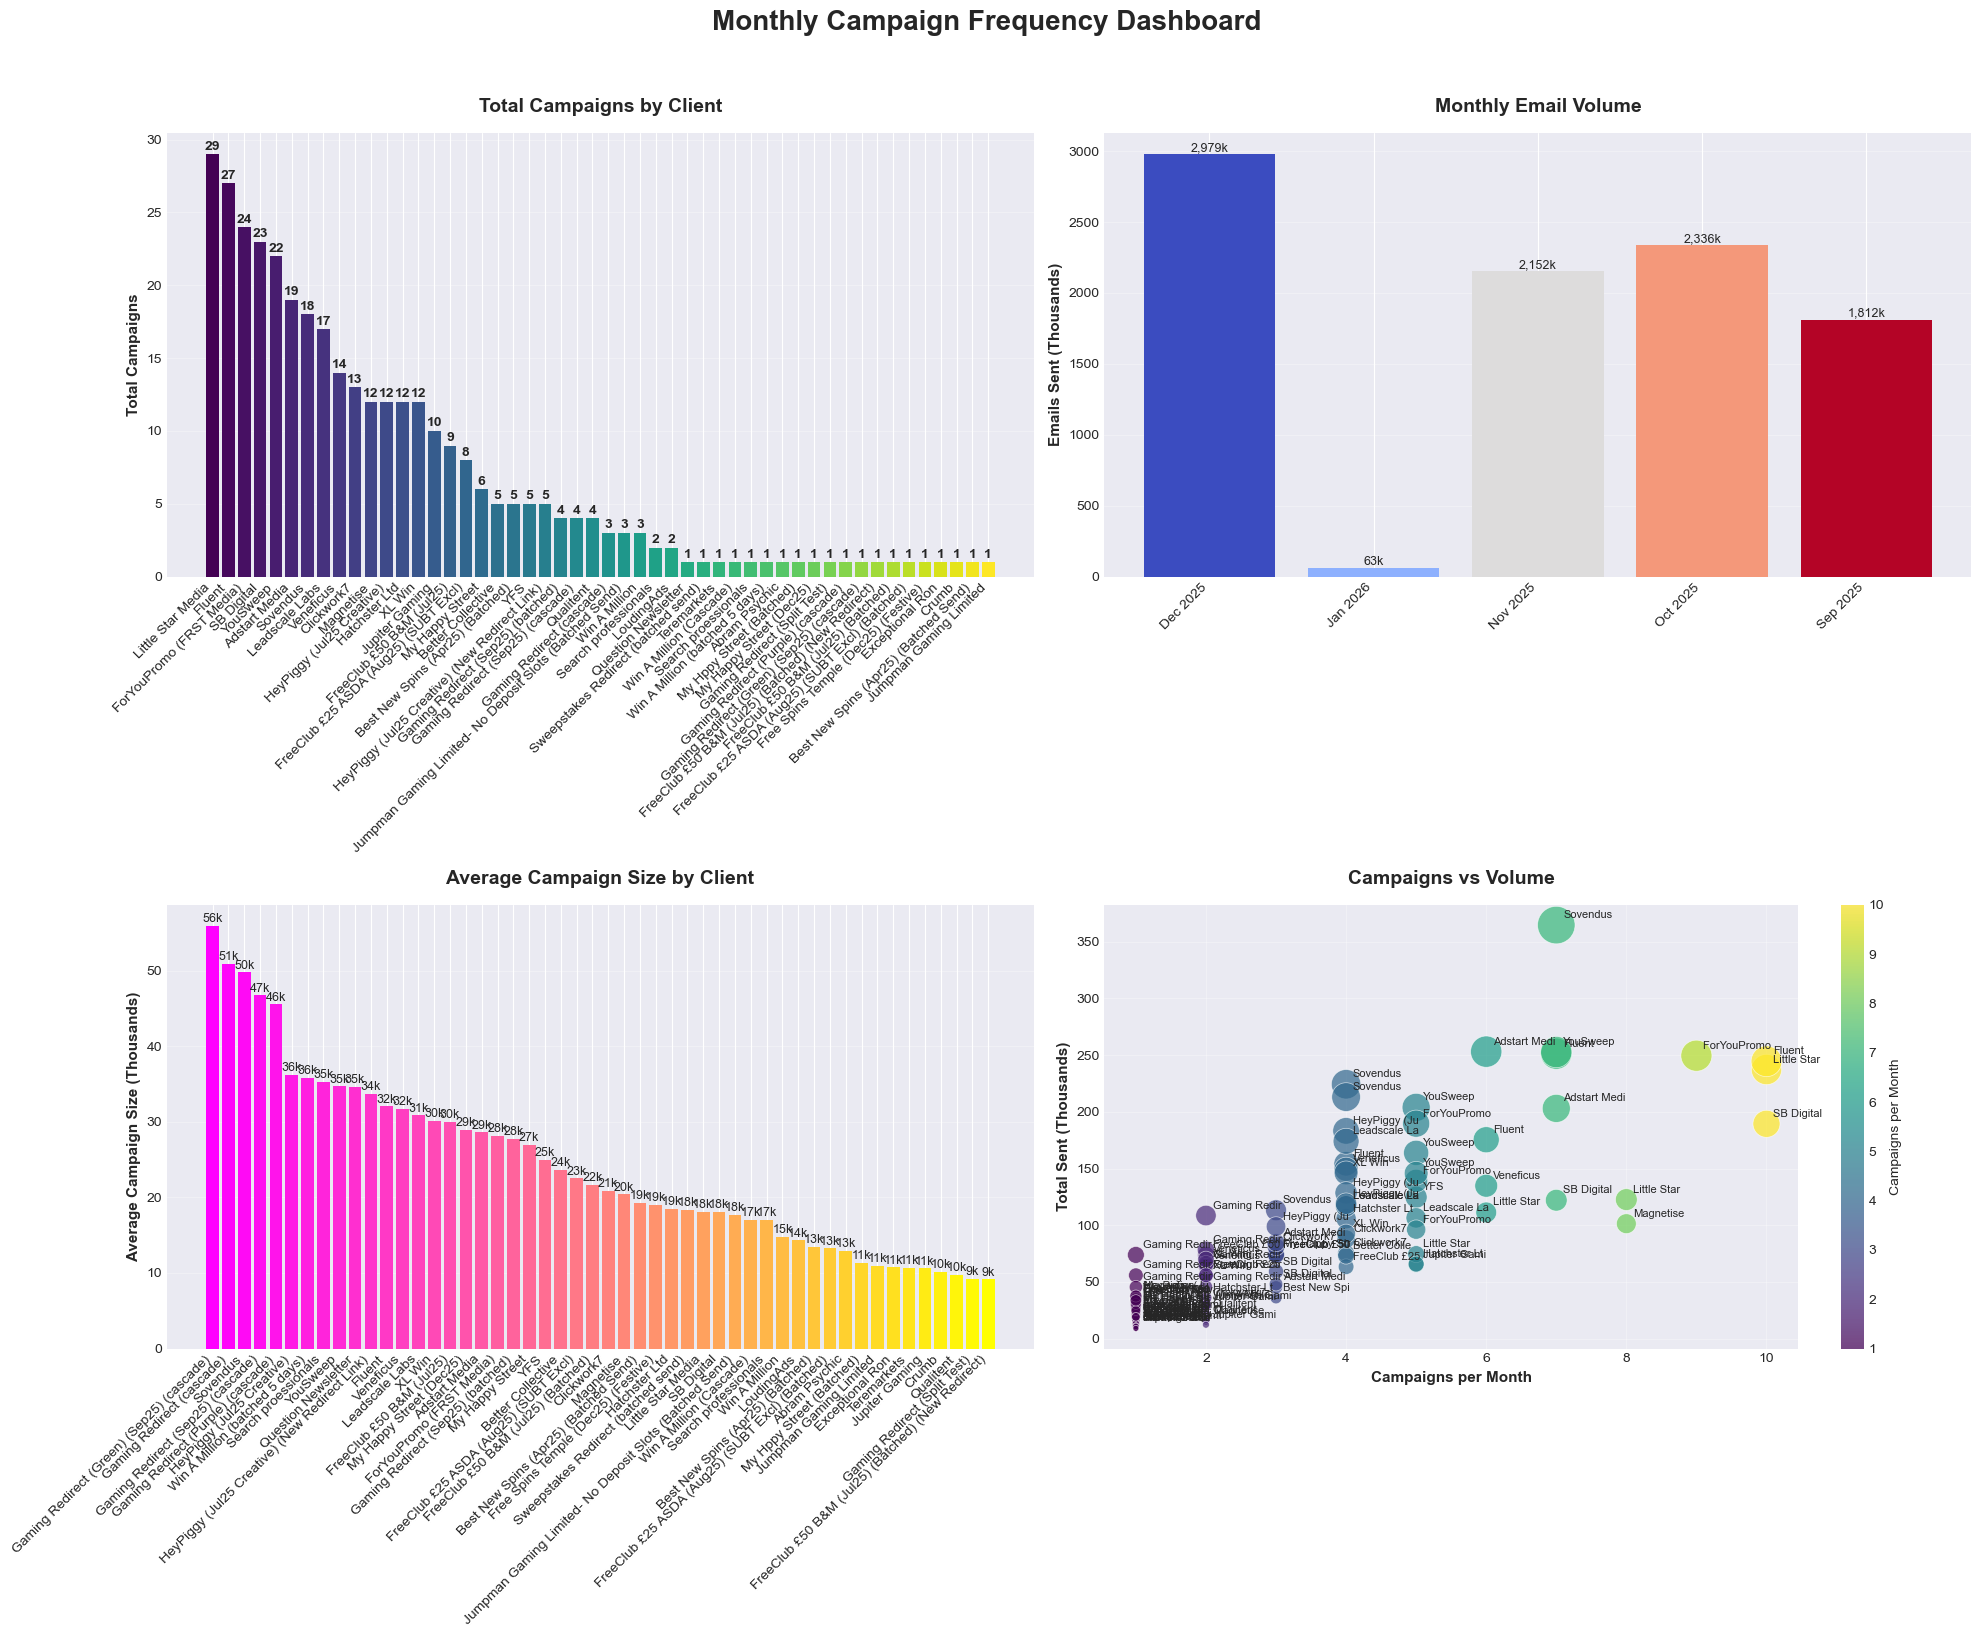

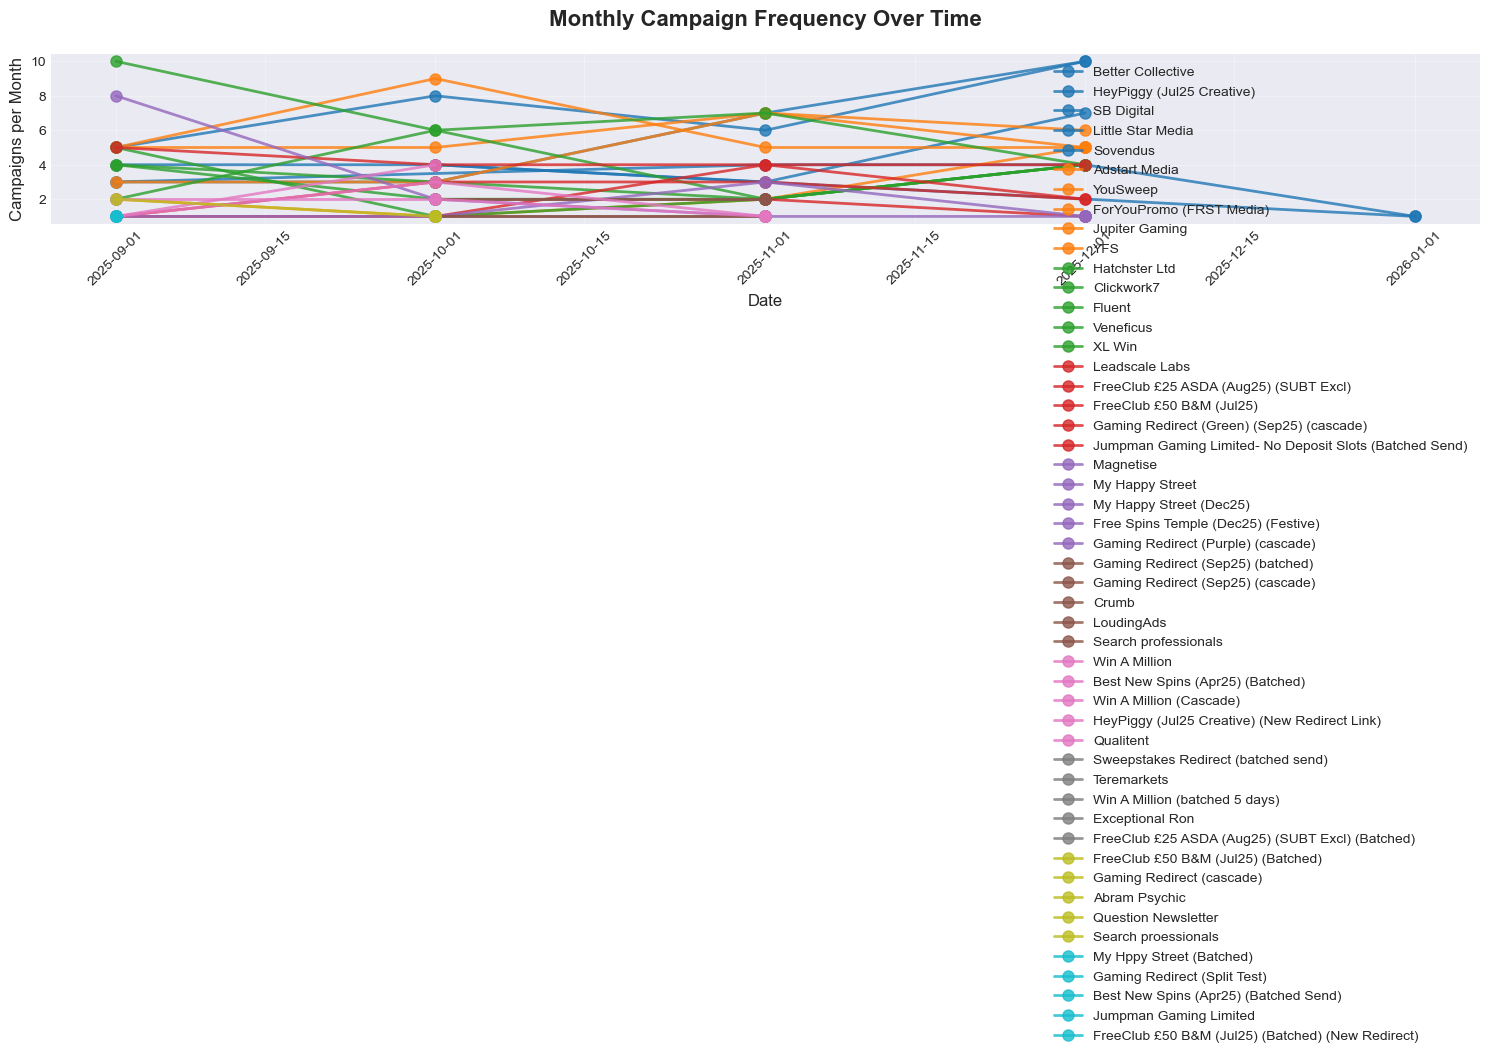

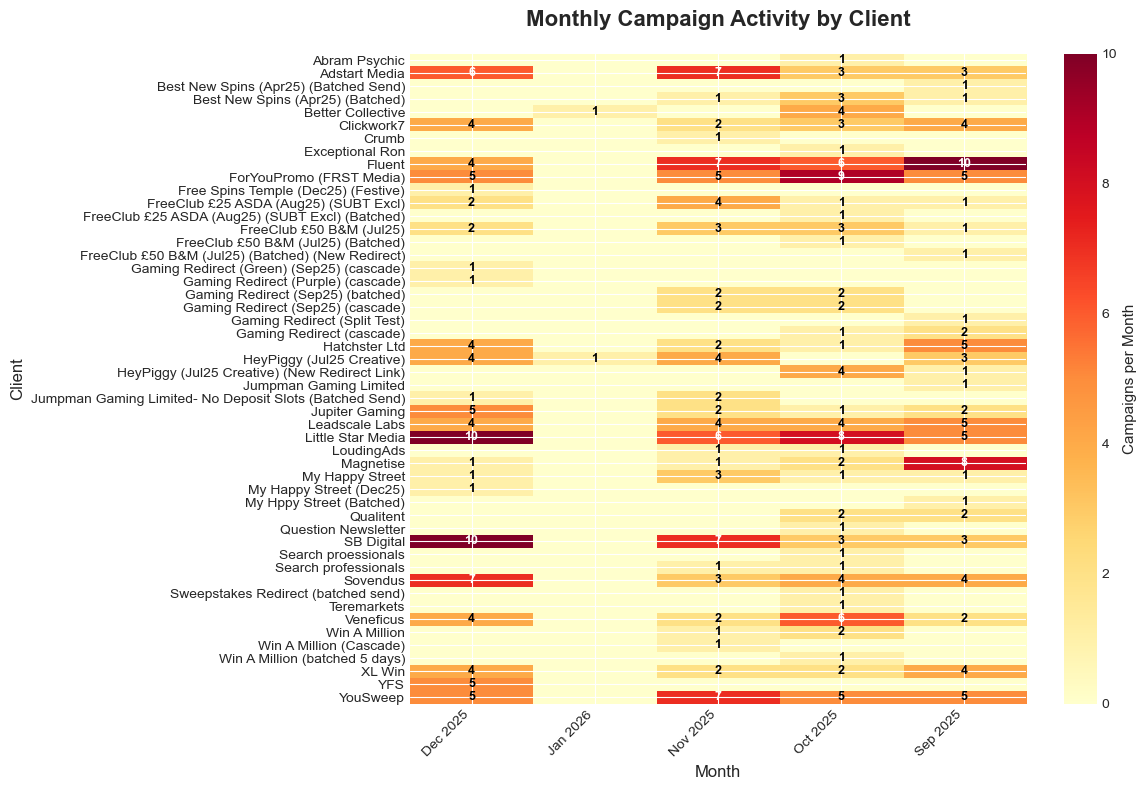

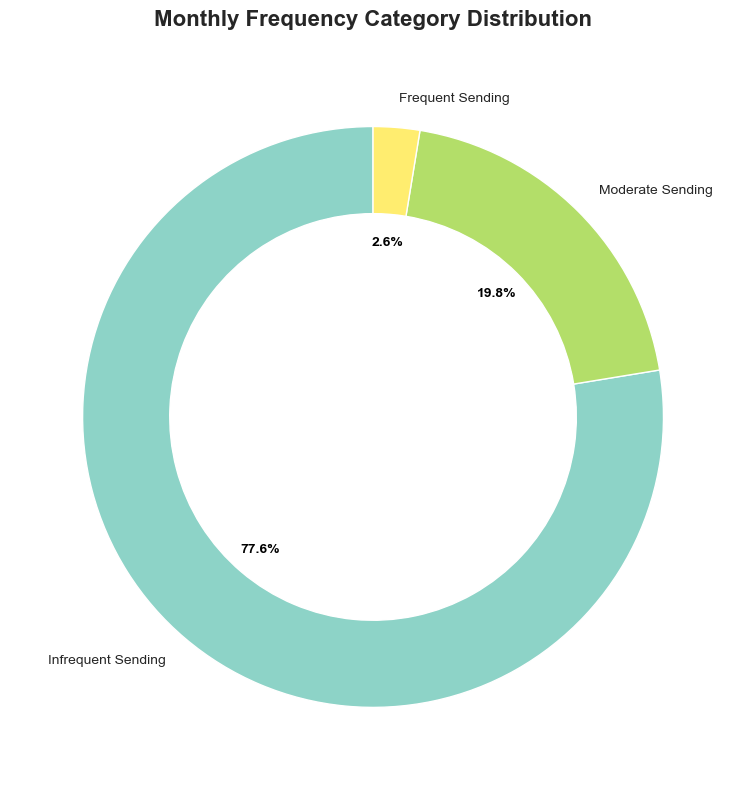

ADDITIONAL BUSINESS INSIGHTS
📊 CAMPAIGN EFFICIENCY ANALYSIS:
   • Most Efficient: Gaming Redirect (cascade)
     - 73,848 emails per campaign
     - 1 campaigns, 73,848 total emails

   • Least Efficient: Jupiter Gaming
     - 6,170 emails per campaign
     - 2 campaigns, 12,341 total emails

🚀 GROWTH OPPORTUNITIES:
   • RESOURCE ALLOCATION SUGGESTIONS:
     - Little Star Media: 7.2 campaigns → 545,750 emails (75,276 emails/campaign)
     - Fluent: 6.8 campaigns → 825,217 emails (122,254 emails/campaign)
     - ForYouPromo (FRST Media): 6.0 campaigns → 674,254 emails (112,376 emails/campaign)


In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

def create_monthly_frequency_analysis(df_monthly):
    """
    Comprehensive visualization suite for monthly campaign frequency analysis
    """
    print("=" * 120)
    print("MONTHLY FREQUENCY ANALYSIS - KEY INSIGHTS")
    print("=" * 120)
    
    # Data preparation
    df_monthly['date'] = pd.to_datetime(df_monthly['year'].astype(str) + '-' + 
                                       df_monthly['month'].astype(str).str.zfill(2) + '-01')
    df_monthly['month_name'] = df_monthly['date'].dt.strftime('%b %Y')
    df_monthly['quarter'] = df_monthly['date'].dt.quarter
    
    # ========== CALCULATE INSIGHTS ==========
    
    # Basic metrics
    total_months = len(df_monthly['date'].unique())
    total_campaigns = df_monthly['campaigns_per_month'].sum()
    total_emails_sent = df_monthly['total_sent_per_month'].sum()
    avg_campaigns_per_month = df_monthly['campaigns_per_month'].mean()
    
    # Handle avg_campaign_size calculation safely
    if 'avg_campaign_size' in df_monthly.columns:
        avg_emails_per_campaign = df_monthly['avg_campaign_size'].mean()
    else:
        # Calculate it from available data
        df_monthly['calculated_avg_size'] = df_monthly['total_sent_per_month'] / df_monthly['campaigns_per_month']
        avg_emails_per_campaign = df_monthly['calculated_avg_size'].mean()
    
    # Client metrics
    avg_monthly_by_client = df_monthly.groupby('client')['campaigns_per_month'].mean().sort_values(ascending=False)
    total_by_client = df_monthly.groupby('client')['campaigns_per_month'].sum().sort_values(ascending=False)
    revenue_by_client = df_monthly.groupby('client')['total_sent_per_month'].sum().sort_values(ascending=False)
    
    # Category distribution
    if 'monthly_frequency_category' in df_monthly.columns:
        category_dist = df_monthly['monthly_frequency_category'].value_counts()
    else:
        category_dist = pd.Series(dtype='float64')
    
    # Monthly trends
    monthly_trends = df_monthly.groupby('date').agg({
        'campaigns_per_month': 'sum',
        'total_sent_per_month': 'sum'
    }).reset_index()
    
    # Add client count safely
    client_counts = df_monthly.groupby('date')['client'].nunique().reset_index()
    monthly_trends = monthly_trends.merge(client_counts, on='date', how='left')
    
    # ========== PRINT INSIGHTS ==========
    
    print(f"📊 OVERVIEW:")
    print(f"   • Period Analyzed: {total_months} months")
    print(f"   • Total Campaigns: {total_campaigns:,}")
    print(f"   • Total Emails Sent: {total_emails_sent:,}")
    print(f"   • Average Campaigns per Month: {avg_campaigns_per_month:.1f}")
    print(f"   • Average Emails per Campaign: {avg_emails_per_campaign:,.0f}")
    print()
    
    print(f"🏆 TOP CLIENTS BY MONTHLY CAMPAIGNS:")
    for i, (client, value) in enumerate(avg_monthly_by_client.head(5).items(), 1):
        total_campaigns_client = total_by_client.get(client, 0)
        total_emails_client = revenue_by_client.get(client, 0)
        print(f"   {i}. {client}:")
        print(f"      • Avg campaigns/month: {value:.1f}")
        print(f"      • Total campaigns: {total_campaigns_client:,}")
        print(f"      • Total emails sent: {total_emails_client:,}")
    print()
    
    if not category_dist.empty:
        print(f"📈 FREQUENCY DISTRIBUTION:")
        for category, count in category_dist.items():
            percentage = (count / len(df_monthly)) * 100
            print(f"   • {category}: {count} months ({percentage:.1f}%)")
        print()
    
    # Peak month analysis
    if not monthly_trends.empty:
        peak_month_idx = monthly_trends['campaigns_per_month'].idxmax()
        peak_month = monthly_trends.loc[peak_month_idx]
        print(f"📅 PEAK MONTH ANALYSIS:")
        print(f"   • Peak Month: {peak_month['date'].strftime('%B %Y')}")
        print(f"   • Campaigns: {peak_month['campaigns_per_month']:,}")
        print(f"   • Emails Sent: {peak_month['total_sent_per_month']:,}")
        print(f"   • Active Clients: {peak_month.get('client', 'N/A')}")
        print()
    
    # Client concentration analysis
    if len(total_by_client) > 0:
        total_all_campaigns = total_by_client.sum()
        top_client = total_by_client.index[0] if len(total_by_client) > 0 else "N/A"
        top_client_share = (total_by_client.iloc[0] / total_all_campaigns) * 100 if len(total_by_client) > 0 else 0
        top_3_share = (total_by_client.head(3).sum() / total_all_campaigns) * 100 if len(total_by_client) >= 3 else 100
        
        print(f"🎯 CLIENT CONCENTRATION:")
        print(f"   • Top Client ({top_client}): {top_client_share:.1f}% of all campaigns")
        print(f"   • Top 3 Clients: {top_3_share:.1f}% of all campaigns")
        print()
    
    # Frequency vs volume analysis - WITH ERROR HANDLING
    print(f"📊 FREQUENCY-VOLUME RELATIONSHIP:")
    if len(df_monthly) >= 2:
        try:
            # Clean data for correlation
            temp_df = df_monthly[['campaigns_per_month', 'total_sent_per_month']].dropna()
            if len(temp_df) >= 2:
                corr = temp_df['campaigns_per_month'].corr(temp_df['total_sent_per_month'])
                if abs(corr) > 0.5:
                    direction = "positive" if corr > 0 else "negative"
                    print(f"   • Strong {direction} correlation (r={corr:.2f})")
                else:
                    print(f"   • Weak correlation (r={corr:.2f}) between frequency and volume")
            else:
                print(f"   • Insufficient data for correlation analysis")
        except Exception as e:
            print(f"   • Error in correlation calculation: {str(e)}")
    else:
        print(f"   • Need at least 2 data points for correlation analysis")
    print()
    
    # Strategic recommendations
    print(f"💡 STRATEGIC RECOMMENDATIONS:")
    
    # Identify under-sending opportunities
    low_freq_clients = []
    for client in avg_monthly_by_client.index:
        avg_freq = avg_monthly_by_client[client]
        if avg_freq < 5:  # Less than 5 campaigns/month
            low_freq_clients.append((client, avg_freq))
    
    if low_freq_clients:
        print(f"   • OPPORTUNITY FOR INCREASED FREQUENCY:")
        for client, freq in low_freq_clients[:3]:
            print(f"     - {client} sends only {freq:.1f} campaigns/month")
    
    # Identify potential over-sending
    high_freq_clients = []
    for client in avg_monthly_by_client.index:
        avg_freq = avg_monthly_by_client[client]
        if avg_freq >= 10:  # 10+ campaigns/month
            high_freq_clients.append((client, avg_freq))
    
    if high_freq_clients:
        print(f"   • MONITOR FOR POTENTIAL FATIGUE:")
        for client, freq in high_freq_clients[:3]:
            print(f"     - {client} sends {freq:.1f} campaigns/month")
    
    # Seasonal opportunity
    if len(df_monthly) >= 3:
        df_monthly['month_num'] = df_monthly['date'].dt.month
        seasonal_pattern = df_monthly.groupby('month_num')['campaigns_per_month'].mean()
        if not seasonal_pattern.empty and len(seasonal_pattern) > 1:
            best_month = seasonal_pattern.idxmax()
            worst_month = seasonal_pattern.idxmin()
            best_month_name = calendar.month_name[best_month]
            worst_month_name = calendar.month_name[worst_month]
            print(f"   • SEASONAL OPPORTUNITY:")
            print(f"     - Best month: {best_month_name} ({seasonal_pattern.max():.1f} avg campaigns)")
            print(f"     - Consider increasing frequency in {worst_month_name}")
    
    print("=" * 120)
    print()
    
    # ========== CREATE VISUALIZATIONS ==========
    
    # Set style
    plt.style.use('seaborn-v0_8-darkgrid')
    sns.set_palette("husl")
    
    # Check if we have enough data for visualizations
    if len(df_monthly) < 2:
        print("⚠️  WARNING: Insufficient data for visualizations (need at least 2 data points)")
        print("   Basic metrics have been calculated above.")
        return df_monthly
    
    # 1. BASIC BAR CHARTS (works with minimal data)
    fig1, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))
    fig1.suptitle('Monthly Campaign Frequency Dashboard', fontsize=20, fontweight='bold', y=1.02)
    
    # Panel 1: Client Campaign Comparison
    client_campaigns = df_monthly.groupby('client')['campaigns_per_month'].sum().sort_values(ascending=False)
    
    if len(client_campaigns) > 0:
        bars = ax1.bar(range(len(client_campaigns)), client_campaigns.values,
                      color=plt.cm.viridis(np.linspace(0, 1, len(client_campaigns))))
        ax1.set_xticks(range(len(client_campaigns)))
        ax1.set_xticklabels(client_campaigns.index, rotation=45, ha='right', fontsize=10)
        ax1.set_ylabel('Total Campaigns', fontsize=11, fontweight='bold')
        ax1.set_title('Total Campaigns by Client', fontsize=14, fontweight='bold', pad=15)
        ax1.grid(axis='y', alpha=0.3)
        
        # Add value labels
        for bar, value in zip(bars, client_campaigns.values):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                    f'{value:.0f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Panel 2: Monthly Volume
    monthly_volume = df_monthly.groupby('month_name')['total_sent_per_month'].sum().sort_index()
    
    if len(monthly_volume) > 0:
        bars2 = ax2.bar(range(len(monthly_volume)), monthly_volume.values / 1000,  # Convert to thousands
                       color=plt.cm.coolwarm(np.linspace(0, 1, len(monthly_volume))))
        ax2.set_xticks(range(len(monthly_volume)))
        ax2.set_xticklabels(monthly_volume.index, rotation=45, ha='right', fontsize=10)
        ax2.set_ylabel('Emails Sent (Thousands)', fontsize=11, fontweight='bold')
        ax2.set_title('Monthly Email Volume', fontsize=14, fontweight='bold', pad=15)
        ax2.grid(axis='y', alpha=0.3)
        
        # Add value labels
        for bar, value in zip(bars2, monthly_volume.values / 1000):
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                    f'{value:,.0f}k', ha='center', va='bottom', fontsize=9)
    
    # Panel 3: Average Campaign Size by Client
    if 'avg_campaign_size' in df_monthly.columns:
        avg_size_by_client = df_monthly.groupby('client')['avg_campaign_size'].mean().sort_values(ascending=False)
    else:
        # Calculate average size
        df_monthly['campaign_size'] = df_monthly['total_sent_per_month'] / df_monthly['campaigns_per_month']
        avg_size_by_client = df_monthly.groupby('client')['campaign_size'].mean().sort_values(ascending=False)
    
    if len(avg_size_by_client) > 0:
        bars3 = ax3.bar(range(len(avg_size_by_client)), avg_size_by_client.values / 1000,  # Convert to thousands
                       color=plt.cm.spring(np.linspace(0, 1, len(avg_size_by_client))))
        ax3.set_xticks(range(len(avg_size_by_client)))
        ax3.set_xticklabels(avg_size_by_client.index, rotation=45, ha='right', fontsize=10)
        ax3.set_ylabel('Average Campaign Size (Thousands)', fontsize=11, fontweight='bold')
        ax3.set_title('Average Campaign Size by Client', fontsize=14, fontweight='bold', pad=15)
        ax3.grid(axis='y', alpha=0.3)
        
        # Add value labels
        for bar, value in zip(bars3, avg_size_by_client.values / 1000):
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                    f'{value:,.0f}k', ha='center', va='bottom', fontsize=9)
    
    # Panel 4: Scatter Plot (if enough data)
    if len(df_monthly) >= 3:
        scatter = ax4.scatter(df_monthly['campaigns_per_month'],
                             df_monthly['total_sent_per_month'] / 1000,  # Convert to thousands
                             c=df_monthly['campaigns_per_month'],
                             s=df_monthly['total_sent_per_month'] / 500,
                             cmap='viridis',
                             alpha=0.7,
                             edgecolors='w',
                             linewidth=0.5)
        
        # Add labels for each point
        for idx, row in df_monthly.iterrows():
            ax4.annotate(row['client'][:12],  # Truncate long names
                        (row['campaigns_per_month'], row['total_sent_per_month'] / 1000),
                        xytext=(5, 5),
                        textcoords='offset points',
                        fontsize=8)
        
        ax4.set_xlabel('Campaigns per Month', fontsize=11, fontweight='bold')
        ax4.set_ylabel('Total Sent (Thousands)', fontsize=11, fontweight='bold')
        ax4.set_title('Campaigns vs Volume', fontsize=14, fontweight='bold', pad=15)
        ax4.grid(True, alpha=0.3)
        
        # Add colorbar
        cbar = plt.colorbar(scatter, ax=ax4)
        cbar.set_label('Campaigns per Month', fontsize=10)
    else:
        ax4.text(0.5, 0.5, 'Need more data for scatter plot\n(Minimum 3 data points required)',
                ha='center', va='center', transform=ax4.transAxes, fontsize=12)
        ax4.set_title('Campaigns vs Volume', fontsize=14, fontweight='bold', pad=15)
    
    plt.tight_layout()
    plt.show()
    
    # 2. TIME SERIES PLOT (if multiple months)
    if len(df_monthly['date'].unique()) > 1:
        fig2, ax5 = plt.subplots(figsize=(15, 7))
        
        # Plot each client's monthly activity
        clients = df_monthly['client'].unique()
        colors = plt.cm.tab10(np.linspace(0, 1, len(clients)))
        
        for i, client in enumerate(clients):
            client_data = df_monthly[df_monthly['client'] == client].sort_values('date')
            if len(client_data) > 0:
                ax5.plot(client_data['date'], client_data['campaigns_per_month'],
                        marker='o', markersize=8, linewidth=2,
                        label=client, color=colors[i], alpha=0.8)
        
        ax5.set_title('Monthly Campaign Frequency Over Time', fontsize=16, fontweight='bold', pad=20)
        ax5.set_xlabel('Date', fontsize=12)
        ax5.set_ylabel('Campaigns per Month', fontsize=12)
        ax5.legend(loc='best', fontsize=10)
        ax5.grid(True, alpha=0.3)
        ax5.tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
    
    # 3. HEATMAP (if multiple clients and months)
    if len(df_monthly['client'].unique()) > 1 and len(df_monthly['date'].unique()) > 1:
        fig3, ax6 = plt.subplots(figsize=(12, 8))
        
        # Create pivot table
        pivot_data = df_monthly.pivot_table(
            index='client',
            columns='month_name',
            values='campaigns_per_month',
            aggfunc='sum',
            fill_value=0
        )
        
        # Create heatmap
        im = ax6.imshow(pivot_data.values, aspect='auto', cmap='YlOrRd')
        
        # Customize heatmap
        ax6.set_xticks(range(len(pivot_data.columns)))
        ax6.set_xticklabels(pivot_data.columns, rotation=45, ha='right', fontsize=10)
        ax6.set_yticks(range(len(pivot_data.index)))
        ax6.set_yticklabels(pivot_data.index, fontsize=10)
        
        # Add value labels
        for i in range(pivot_data.shape[0]):
            for j in range(pivot_data.shape[1]):
                value = pivot_data.iloc[i, j]
                if value > 0:
                    ax6.text(j, i, f'{int(value)}', ha='center', va='center',
                            fontsize=9, fontweight='bold',
                            color='white' if value > pivot_data.values.max()/2 else 'black')
        
        ax6.set_title('Monthly Campaign Activity by Client', fontsize=16, fontweight='bold', pad=20)
        ax6.set_xlabel('Month', fontsize=12)
        ax6.set_ylabel('Client', fontsize=12)
        
        # Add colorbar
        cbar = plt.colorbar(im, ax=ax6)
        cbar.set_label('Campaigns per Month', fontsize=11)
        
        plt.tight_layout()
        plt.show()
    else:
        print("⚠️  Note: Heatmap requires multiple clients and months for meaningful visualization")
    
    # 4. PIE CHART for frequency categories (if available)
    if not category_dist.empty:
        fig4, ax7 = plt.subplots(figsize=(10, 8))
        
        # Create pie chart
        wedges, texts, autotexts = ax7.pie(category_dist.values,
                                          labels=category_dist.index,
                                          autopct='%1.1f%%',
                                          startangle=90,
                                          colors=plt.cm.Set3(np.linspace(0, 1, len(category_dist))),
                                          wedgeprops=dict(width=0.3, edgecolor='w'))
        
        # Create donut center
        centre_circle = plt.Circle((0,0), 0.70, fc='white')
        ax7.add_artist(centre_circle)
        
        # Style autotexts
        for autotext in autotexts:
            autotext.set_color('black')
            autotext.set_fontweight('bold')
            autotext.set_fontsize(10)
        
        ax7.set_title('Monthly Frequency Category Distribution', fontsize=16, fontweight='bold', pad=20)
        
        plt.tight_layout()
        plt.show()
    
    # ========== ADDITIONAL INSIGHTS ==========
    print("=" * 120)
    print("ADDITIONAL BUSINESS INSIGHTS")
    print("=" * 120)
    
    # Campaign efficiency analysis
    print(f"📊 CAMPAIGN EFFICIENCY ANALYSIS:")
    
    # Calculate campaign to email ratio
    df_monthly['emails_per_campaign'] = df_monthly['total_sent_per_month'] / df_monthly['campaigns_per_month']
    
    most_efficient = df_monthly.loc[df_monthly['emails_per_campaign'].idxmax()] if len(df_monthly) > 0 else None
    least_efficient = df_monthly.loc[df_monthly['emails_per_campaign'].idxmin()] if len(df_monthly) > 0 else None
    
    if most_efficient is not None and least_efficient is not None:
        print(f"   • Most Efficient: {most_efficient['client']}")
        print(f"     - {most_efficient['emails_per_campaign']:,.0f} emails per campaign")
        print(f"     - {most_efficient['campaigns_per_month']} campaigns, {most_efficient['total_sent_per_month']:,} total emails")
        print()
        print(f"   • Least Efficient: {least_efficient['client']}")
        print(f"     - {least_efficient['emails_per_campaign']:,.0f} emails per campaign")
        print(f"     - {least_efficient['campaigns_per_month']} campaigns, {least_efficient['total_sent_per_month']:,} total emails")
    print()
    
    # Growth opportunities
    print(f"🚀 GROWTH OPPORTUNITIES:")
    
    # Identify low-frequency, high-potential clients
    if len(avg_monthly_by_client) >= 2:
        median_freq = avg_monthly_by_client.median()
        low_freq_high_volume = []
        
        for client in avg_monthly_by_client.index:
            freq = avg_monthly_by_client[client]
            volume = revenue_by_client.get(client, 0)
            if freq < median_freq and volume > df_monthly['total_sent_per_month'].mean():
                low_freq_high_volume.append((client, freq, volume))
        
        if low_freq_high_volume:
            print(f"   • Low Frequency, High Volume Clients (Increase Frequency):")
            for client, freq, volume in low_freq_high_volume[:3]:
                print(f"     - {client}: {freq:.1f} campaigns/month, {volume:,.0f} emails")
    
    # Resource allocation suggestions
    print(f"   • RESOURCE ALLOCATION SUGGESTIONS:")
    
    # Calculate ROI per client (using volume as proxy for value)
    for client in avg_monthly_by_client.head(3).index:
        freq = avg_monthly_by_client[client]
        volume = revenue_by_client.get(client, 0)
        efficiency = volume / freq if freq > 0 else 0
        print(f"     - {client}: {freq:.1f} campaigns → {volume:,.0f} emails ({efficiency:,.0f} emails/campaign)")
    
    print("=" * 120)
    
    return df_monthly


df_monthly = create_monthly_frequency_analysis(df)

# Client Sending Pattern Consistency Analysis - Visualization Guide
## Analysis Title: Client Sending Pattern Consistency & Behavioral Analysis
**Business Insight:** Understanding which clients have consistent vs irregular sending patterns, identifying potential delivery risks, and optimizing sending strategies based on consistency metrics.

In [79]:
SQL_NAME = "1_/1_4"
result = await SqlQuery.read_sql(SQL_NAME)

# Run in Jupyter
df = await fetch_data(result)
df.head(3)

client  total_active_days avg_campaigns_per_day  \
0  Magnetise                 11    1.0909090909090909   
1   Sovendus                 17    1.0588235294117647   
2     Fluent                 26    1.0384615384615385   

  stddev_campaigns_per_day    avg_sent_per_day stddev_sent_per_day  \
0   0.30151134457776362265  16187.636363636364      11625.27563779   
1   0.24253562503633297351  53825.176470588235      28625.30162993   
2   0.19611613513818403193  31739.115384615385      17281.76885235   

  campaigns_consistency_index     sending_pattern  max_campaigns_per_day  \
0                        0.28  Consistent Pattern                      2   
1                        0.23  Consistent Pattern                      2   
2                        0.19  Consistent Pattern                      2   

   min_campaigns_per_day  
0                      1  
1                      1  
2                      1

CLIENT SENDING PATTERN CONSISTENCY ANALYSIS - KEY INSIGHTS
📊 OVERVIEW:
   • Total Clients Analyzed: 50
   • Average Consistency Index: 0.02
   • Average Active Days per Client: 7

🎯 CONSISTENCY PATTERN DISTRIBUTION:
   • Perfectly Consistent: 27 clients (54.0%)
   • Irregular Bursts: 20 clients (40.0%)
   • Consistent Pattern: 3 clients (6.0%)

🏆 CONSISTENCY LEADERS:
   • Most Consistent: Better Collective
      - Consistency Index: 0.00
      - Avg Campaigns/Day: 1.00
      - Active Days: 5

⚠️  VARIABILITY WATCH:
   • Least Consistent: Magnetise
      - Consistency Index: 0.28
      - Avg Campaigns/Day: 1.09
      - Active Days: 11

📈 VOLUME-CONSISTENCY RELATIONSHIP:
   • Weak correlation (r=0.23) between volume and consistency

💡 STRATEGIC RECOMMENDATIONS:
   • STABILIZE IRREGULAR SENDERS:
     - Best New Spins (Apr25) (Batched Send): Irregular Bursts, CI: nan
     - Crumb: Irregular Bursts, CI: nan
     - Exceptional Ron: Irregular Bursts, CI: nan
   • PRIORITY STABILIZATION:
     

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

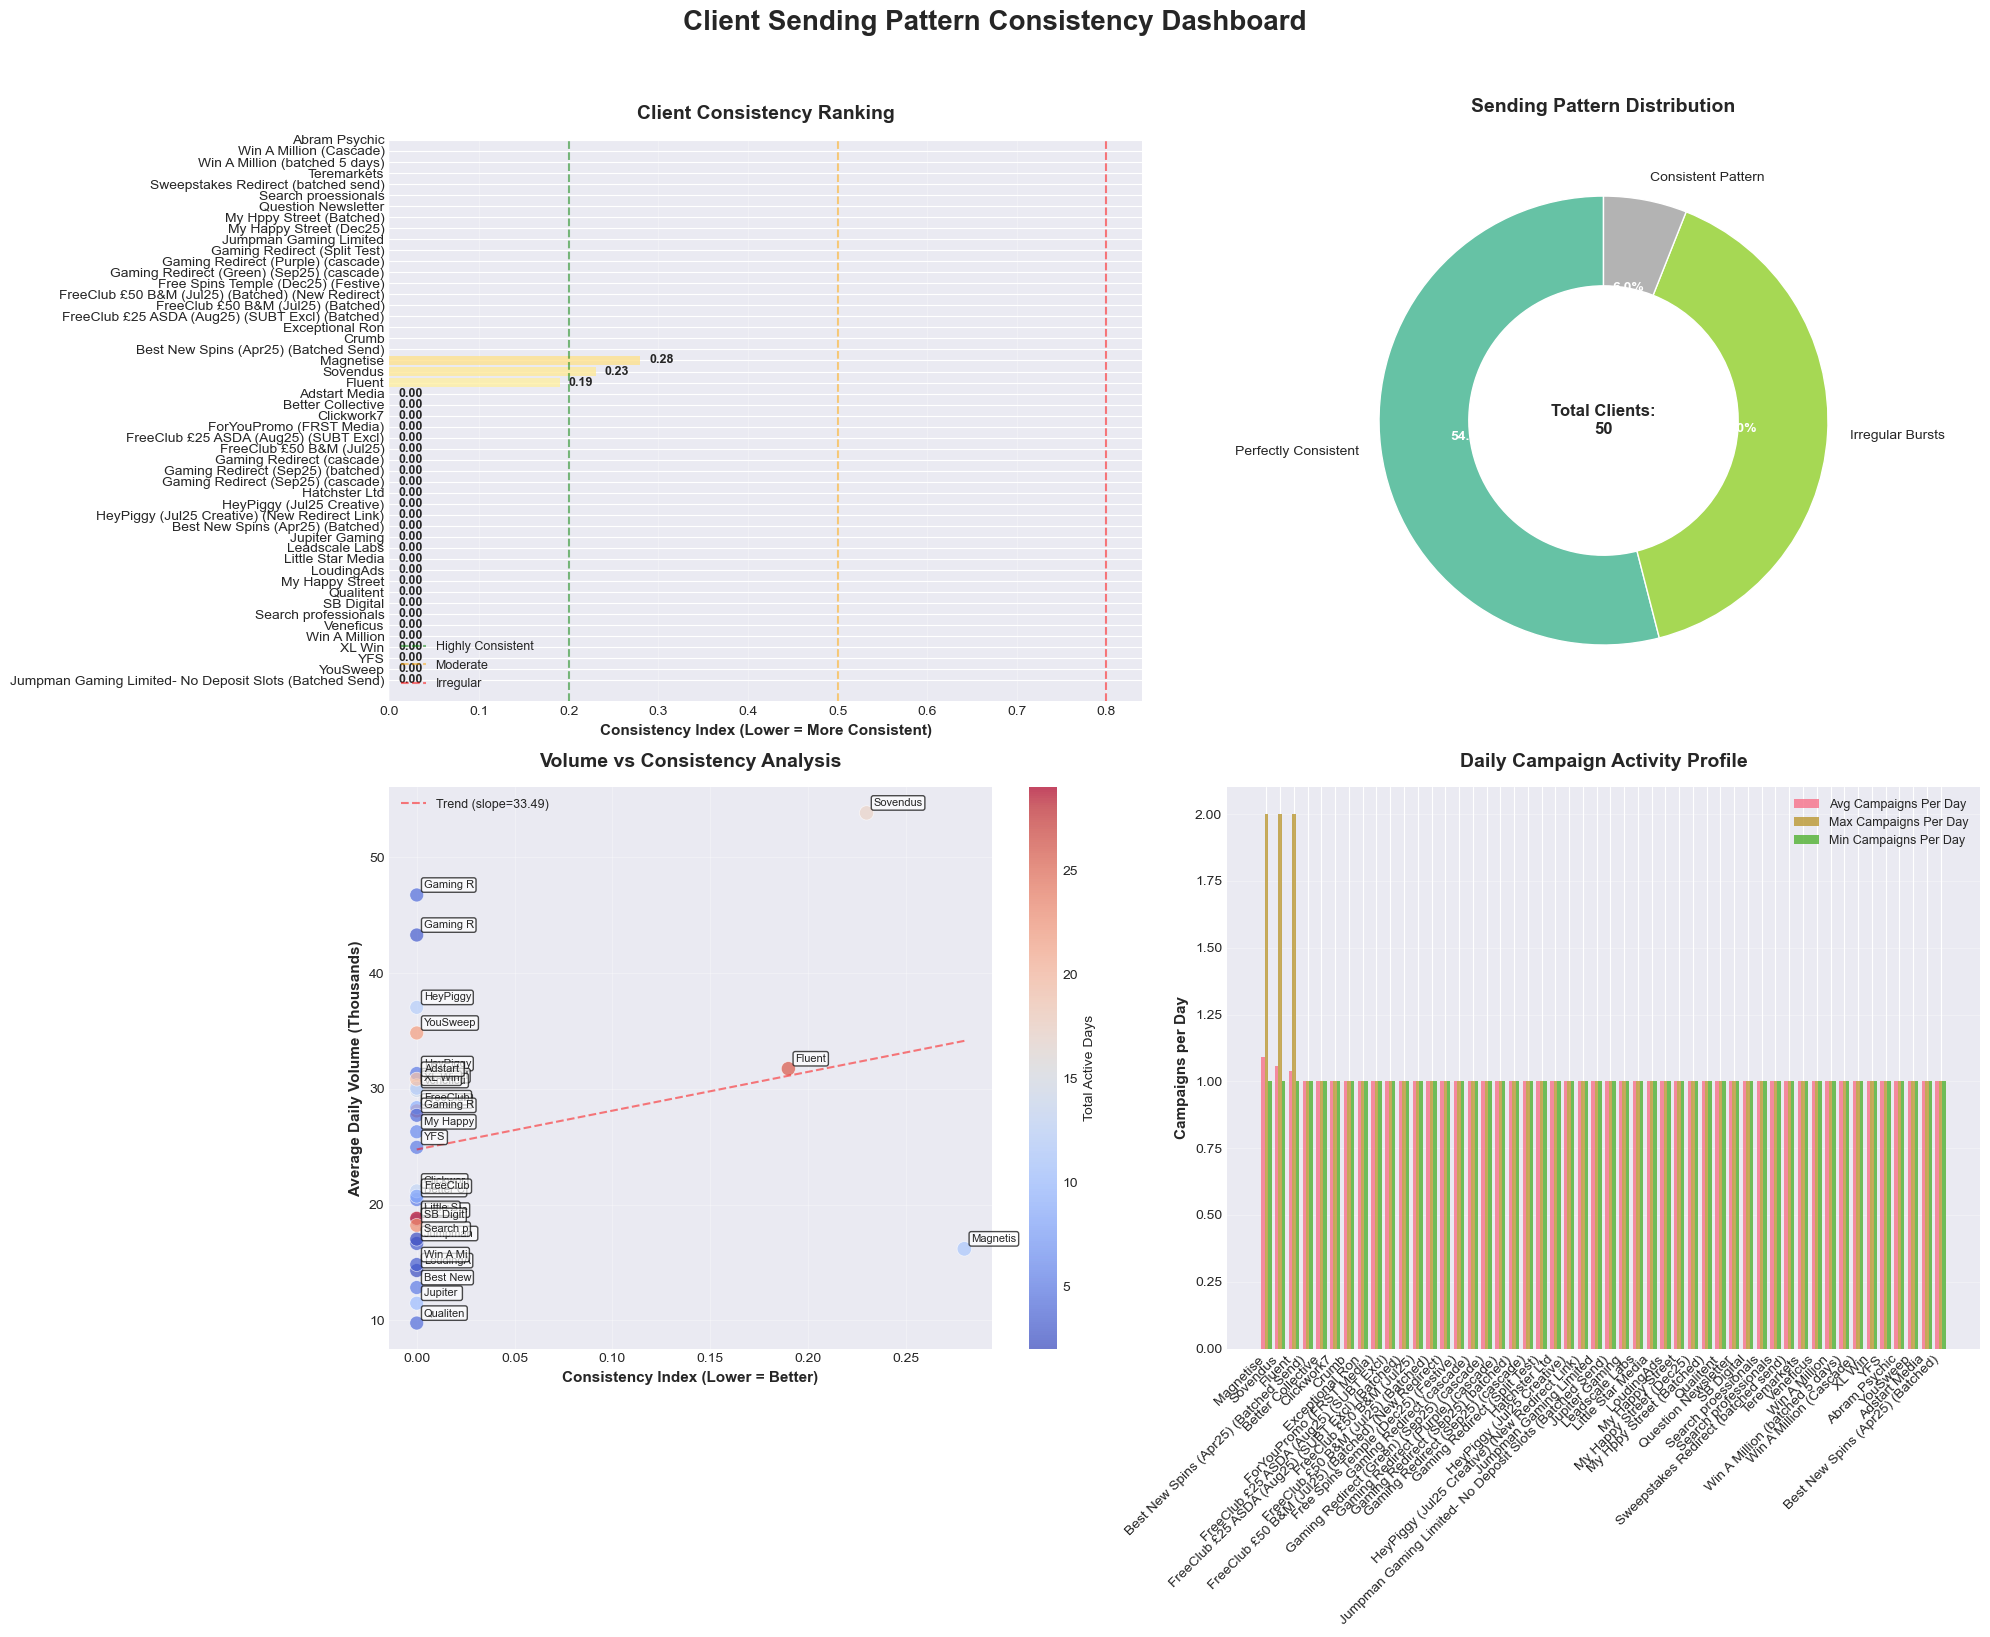

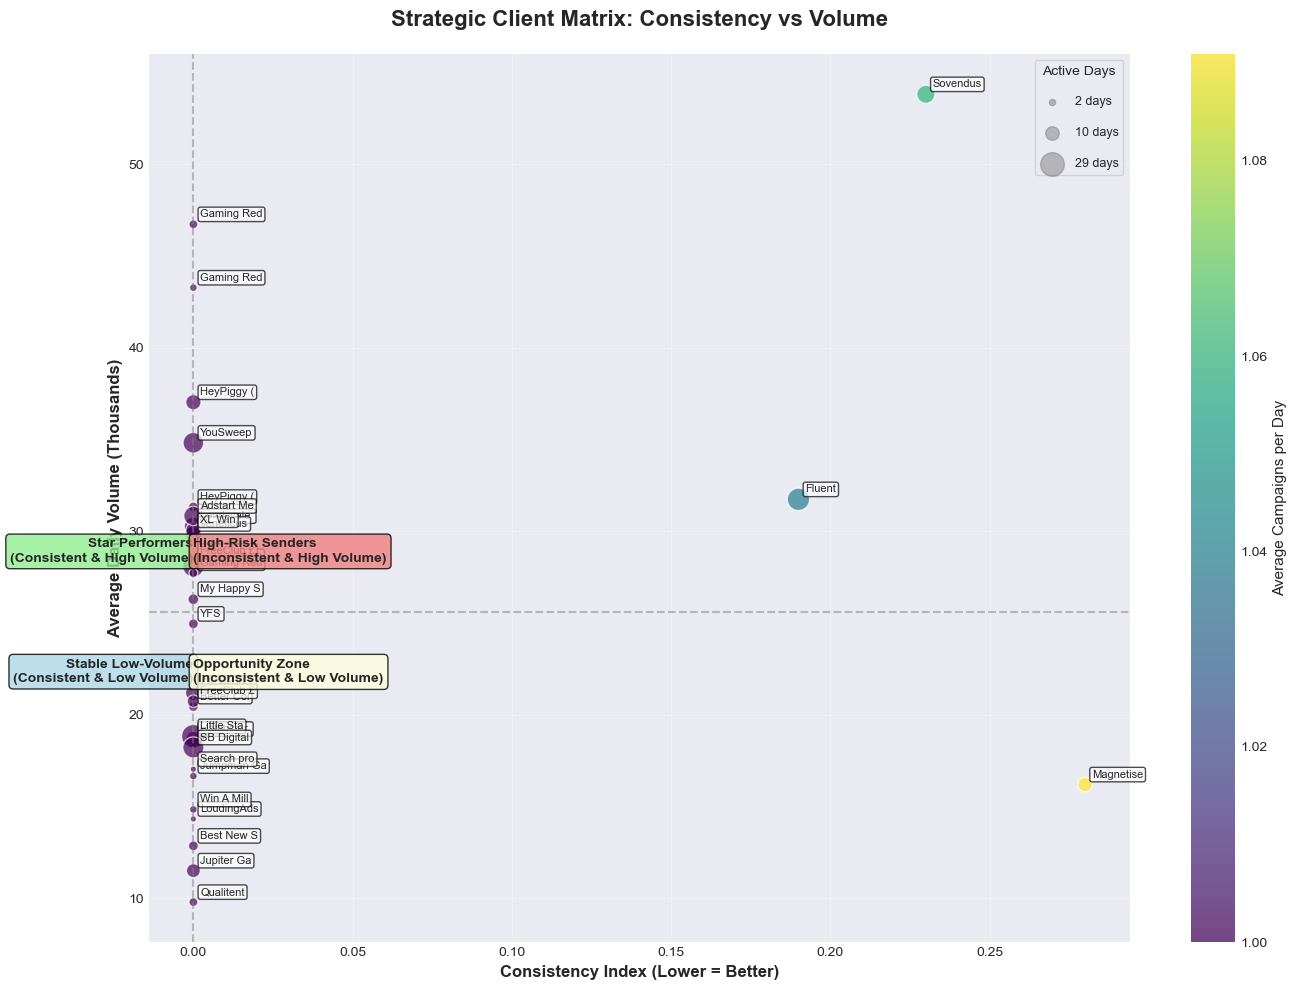

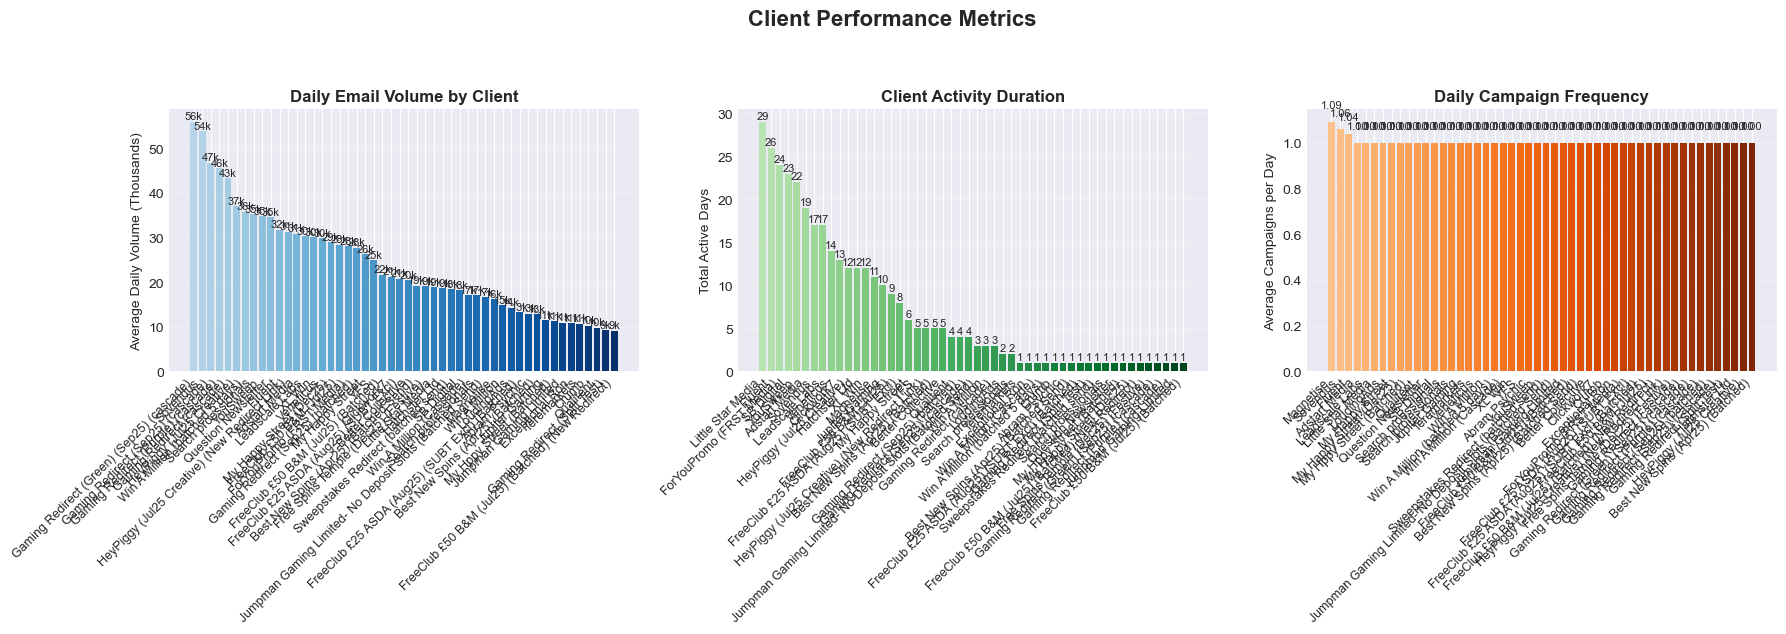

VISUAL ANALYSIS INSIGHTS & STRATEGIC RECOMMENDATIONS
📊 SUMMARY OF FINDINGS:
   • Highly Consistent (CI < 0.3): 30 clients
     - Magnetise
     - Sovendus
     - Fluent
   • Potentially Inconsistent (CI > 0.5): 0 clients

   • TOP VOLUME SENDERS:
     - Gaming Redirect (Green) (Sep25) (cascade): 56k emails/day
     - Sovendus: 54k emails/day
     - Gaming Redirect (Sep25) (cascade): 47k emails/day

   • MOST ACTIVE CLIENTS:
     - Little Star Media: 29 active days
     - Fluent: 26 active days
     - ForYouPromo (FRST Media): 24 active days

🚀 ACTIONABLE RECOMMENDATIONS:
   • LEVERAGE STAR PERFORMERS:
     - Sovendus: Use as benchmark for other clients
     - Fluent: Use as benchmark for other clients
   • MONITORING SUGGESTIONS:
     - Track Consistency Index monthly
     - Set alerts for CI > 0.5
     - Review sending patterns quarterly


In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Ellipse
import warnings
warnings.filterwarnings('ignore')

def create_consistency_analysis(df_consistency):
    """
    Comprehensive visualization suite for client sending pattern consistency analysis
    """
    print("=" * 120)
    print("CLIENT SENDING PATTERN CONSISTENCY ANALYSIS - KEY INSIGHTS")
    print("=" * 120)
    
    # ========== DATA PREPARATION ==========
    
    # Convert numeric columns to appropriate types
    numeric_columns = ['campaigns_consistency_index', 'avg_campaigns_per_day', 'stddev_campaigns_per_day',
                       'avg_sent_per_day', 'stddev_sent_per_day', 'max_campaigns_per_day', 
                       'min_campaigns_per_day', 'total_active_days']
    
    for col in numeric_columns:
        if col in df_consistency.columns:
            df_consistency[col] = pd.to_numeric(df_consistency[col], errors='coerce')
    
    # ========== CALCULATE INSIGHTS ==========
    
    # Basic metrics
    total_clients = len(df_consistency)
    avg_consistency_index = df_consistency['campaigns_consistency_index'].mean()
    avg_active_days = df_consistency['total_active_days'].mean()
    
    # Pattern distribution
    pattern_dist = df_consistency['sending_pattern'].value_counts()
    
    # Most and least consistent clients
    if 'campaigns_consistency_index' in df_consistency.columns and not df_consistency['campaigns_consistency_index'].isna().all():
        most_consistent_idx = df_consistency['campaigns_consistency_index'].idxmin()
        least_consistent_idx = df_consistency['campaigns_consistency_index'].idxmax()
        most_consistent = df_consistency.loc[most_consistent_idx]
        least_consistent = df_consistency.loc[least_consistent_idx]
    else:
        most_consistent = least_consistent = None
    
    # Volume consistency analysis
    if 'avg_sent_per_day' in df_consistency.columns:
        volume_median = df_consistency['avg_sent_per_day'].median()
        high_volume_clients = df_consistency[df_consistency['avg_sent_per_day'] > volume_median]
        low_volume_clients = df_consistency[df_consistency['avg_sent_per_day'] <= volume_median]
    else:
        high_volume_clients = low_volume_clients = pd.DataFrame()
    
    # ========== PRINT INSIGHTS ==========
    
    print(f"📊 OVERVIEW:")
    print(f"   • Total Clients Analyzed: {total_clients}")
    print(f"   • Average Consistency Index: {avg_consistency_index:.2f}")
    print(f"   • Average Active Days per Client: {avg_active_days:.0f}")
    print()
    
    print(f"🎯 CONSISTENCY PATTERN DISTRIBUTION:")
    for pattern, count in pattern_dist.items():
        percentage = (count / total_clients) * 100
        print(f"   • {pattern}: {count} clients ({percentage:.1f}%)")
    print()
    
    if most_consistent is not None:
        print(f"🏆 CONSISTENCY LEADERS:")
        print(f"   • Most Consistent: {most_consistent['client']}")
        print(f"      - Consistency Index: {most_consistent['campaigns_consistency_index']:.2f}")
        print(f"      - Avg Campaigns/Day: {most_consistent['avg_campaigns_per_day']:.2f}")
        print(f"      - Active Days: {most_consistent['total_active_days']}")
        print()
    
    if least_consistent is not None:
        print(f"⚠️  VARIABILITY WATCH:")
        print(f"   • Least Consistent: {least_consistent['client']}")
        print(f"      - Consistency Index: {least_consistent['campaigns_consistency_index']:.2f}")
        print(f"      - Avg Campaigns/Day: {least_consistent['avg_campaigns_per_day']:.2f}")
        print(f"      - Active Days: {least_consistent['total_active_days']}")
        print()
    
    # Volume vs consistency analysis
    print(f"📈 VOLUME-CONSISTENCY RELATIONSHIP:")
    if len(df_consistency) >= 2:
        try:
            # Check if we have both columns
            if 'avg_sent_per_day' in df_consistency.columns and 'campaigns_consistency_index' in df_consistency.columns:
                # Drop NaN values for correlation
                temp_df = df_consistency[['avg_sent_per_day', 'campaigns_consistency_index']].dropna()
                if len(temp_df) >= 2:
                    volume_consistency_corr = temp_df['avg_sent_per_day'].corr(temp_df['campaigns_consistency_index'])
                    if abs(volume_consistency_corr) > 0.3:
                        direction = "positive" if volume_consistency_corr > 0 else "negative"
                        print(f"   • {direction.capitalize()} correlation (r={volume_consistency_corr:.2f}) between volume and consistency")
                        if volume_consistency_corr > 0:
                            print(f"   • Insight: Higher volume clients tend to be less consistent")
                        else:
                            print(f"   • Insight: Higher volume clients tend to be more consistent")
                    else:
                        print(f"   • Weak correlation (r={volume_consistency_corr:.2f}) between volume and consistency")
                else:
                    print(f"   • Insufficient data for correlation analysis")
            else:
                print(f"   • Missing required columns for correlation analysis")
        except Exception as e:
            print(f"   • Error in correlation calculation: {str(e)}")
    else:
        print(f"   • Need at least 2 data points for correlation analysis")
    print()
    
    # Strategic recommendations
    print(f"💡 STRATEGIC RECOMMENDATIONS:")
    
    # Identify irregular patterns
    if 'sending_pattern' in df_consistency.columns:
        irregular_clients = df_consistency[df_consistency['sending_pattern'].str.contains('Irregular|Variable', case=False, na=False)]
        if not irregular_clients.empty:
            print(f"   • STABILIZE IRREGULAR SENDERS:")
            for idx, row in irregular_clients.head(3).iterrows():
                print(f"     - {row['client']}: {row['sending_pattern']}, CI: {row.get('campaigns_consistency_index', 'N/A'):.2f}")
    
    # High volume but inconsistent
    if 'avg_sent_per_day' in df_consistency.columns and 'campaigns_consistency_index' in df_consistency.columns:
        high_vol_inconsistent = df_consistency[
            (df_consistency['avg_sent_per_day'] > df_consistency['avg_sent_per_day'].median()) &
            (df_consistency['campaigns_consistency_index'] > df_consistency['campaigns_consistency_index'].median())
        ]
        
        if not high_vol_inconsistent.empty:
            print(f"   • PRIORITY STABILIZATION:")
            for idx, row in high_vol_inconsistent.head(3).iterrows():
                print(f"     - {row['client']}: {row['avg_sent_per_day']:,.0f} emails/day, CI: {row['campaigns_consistency_index']:.2f}")
    
    # Consistency vs deliverability recommendations
    print(f"   • DELIVERABILITY CONSIDERATIONS:")
    print(f"     - Consistent patterns (CI < 0.3) typically have better deliverability")
    print(f"     - Irregular bursts may trigger spam filters")
    print(f"     - Consider implementing sending schedules for inconsistent clients")
    
    print("=" * 120)
    print()
    
    # ========== CREATE VISUALIZATIONS ==========
    
    # Set style
    plt.style.use('seaborn-v0_8-darkgrid')
    sns.set_palette("husl")
    
    # 1. CONSISTENCY MATRIX DASHBOARD
    fig1, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))
    fig1.suptitle('Client Sending Pattern Consistency Dashboard', fontsize=20, fontweight='bold', y=1.02)
    
    # Panel 1: Consistency Index Ranking (Horizontal Bar)
    if 'campaigns_consistency_index' in df_consistency.columns:
        df_sorted = df_consistency.sort_values('campaigns_consistency_index')
        
        # Create color gradient based on consistency
        colors = plt.cm.RdYlGn_r(np.linspace(0, 1, len(df_sorted)))  # Red (inconsistent) to Green (consistent)
        
        bars = ax1.barh(range(len(df_sorted)), df_sorted['campaigns_consistency_index'], 
                       color=colors, alpha=0.8)
        
        ax1.set_yticks(range(len(df_sorted)))
        ax1.set_yticklabels(df_sorted['client'], fontsize=10)
        ax1.set_xlabel('Consistency Index (Lower = More Consistent)', fontsize=11, fontweight='bold')
        ax1.set_title('Client Consistency Ranking', fontsize=14, fontweight='bold', pad=15)
        ax1.grid(axis='x', alpha=0.3)
        
        # Add value labels
        for bar, value in zip(bars, df_sorted['campaigns_consistency_index']):
            width = bar.get_width()
            ax1.text(width + 0.01, bar.get_y() + bar.get_height()/2, 
                    f'{value:.2f}', va='center', fontsize=9, fontweight='bold')
        
        # Add consistency threshold lines
        ax1.axvline(x=0.2, color='green', linestyle='--', alpha=0.5, label='Highly Consistent')
        ax1.axvline(x=0.5, color='orange', linestyle='--', alpha=0.5, label='Moderate')
        ax1.axvline(x=0.8, color='red', linestyle='--', alpha=0.5, label='Irregular')
        ax1.legend(fontsize=9)
    else:
        ax1.text(0.5, 0.5, 'Consistency Index data not available', 
                ha='center', va='center', transform=ax1.transAxes, fontsize=12)
        ax1.set_title('Client Consistency Ranking', fontsize=14, fontweight='bold')
    
    # Panel 2: Pattern Distribution (Donut Chart)
    if not pattern_dist.empty:
        wedges, texts, autotexts = ax2.pie(pattern_dist.values,
                                          labels=pattern_dist.index,
                                          autopct='%1.1f%%',
                                          startangle=90,
                                          colors=plt.cm.Set2(np.linspace(0, 1, len(pattern_dist))),
                                          wedgeprops=dict(width=0.4, edgecolor='w'))
        
        # Create donut center
        centre_circle = plt.Circle((0,0), 0.6, fc='white')
        ax2.add_artist(centre_circle)
        
        # Add summary text in center
        summary_text = f"Total Clients:\n{total_clients}"
        ax2.text(0, 0, summary_text, ha='center', va='center', 
                fontsize=12, fontweight='bold')
        
        # Style autotexts
        for autotext in autotexts:
            autotext.set_color('white')
            autotext.set_fontweight('bold')
            autotext.set_fontsize(10)
        
        ax2.set_title('Sending Pattern Distribution', fontsize=14, fontweight='bold', pad=20)
    else:
        ax2.text(0.5, 0.5, 'Pattern distribution data not available', 
                ha='center', va='center', transform=ax2.transAxes, fontsize=12)
        ax2.set_title('Sending Pattern Distribution', fontsize=14, fontweight='bold')
    
    # Panel 3: Volume vs Consistency Scatter Plot
    if 'campaigns_consistency_index' in df_consistency.columns and 'avg_sent_per_day' in df_consistency.columns:
        # Drop NaN values
        scatter_data = df_consistency[['campaigns_consistency_index', 'avg_sent_per_day', 
                                      'total_active_days', 'avg_campaigns_per_day', 'client']].dropna()
        
        if len(scatter_data) > 0:
            scatter = ax3.scatter(scatter_data['campaigns_consistency_index'],
                                 scatter_data['avg_sent_per_day'] / 1000,  # Convert to thousands
                                 c=scatter_data['total_active_days'],
                                 s=scatter_data['avg_campaigns_per_day'] * 100,  # Bubble size
                                 cmap='coolwarm',
                                 alpha=0.7,
                                 edgecolors='w',
                                 linewidth=0.5)
            
            # Add client labels
            for idx, row in scatter_data.iterrows():
                ax3.annotate(row['client'][:8],  # Truncate long names
                            (row['campaigns_consistency_index'], row['avg_sent_per_day'] / 1000),
                            xytext=(5, 5),
                            textcoords='offset points',
                            fontsize=8,
                            bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.7))
            
            ax3.set_xlabel('Consistency Index (Lower = Better)', fontsize=11, fontweight='bold')
            ax3.set_ylabel('Average Daily Volume (Thousands)', fontsize=11, fontweight='bold')
            ax3.set_title('Volume vs Consistency Analysis', fontsize=14, fontweight='bold', pad=15)
            ax3.grid(True, alpha=0.3)
            
            # Add colorbar for active days
            cbar = plt.colorbar(scatter, ax=ax3)
            cbar.set_label('Total Active Days', fontsize=10)
            
            # Add trend line if enough data
            if len(scatter_data) >= 3:
                try:
                    z = np.polyfit(scatter_data['campaigns_consistency_index'], 
                                  scatter_data['avg_sent_per_day'] / 1000, 1)
                    p = np.poly1d(z)
                    ax3.plot(scatter_data['campaigns_consistency_index'], 
                            p(scatter_data['campaigns_consistency_index']), 
                            "r--", alpha=0.5, label=f'Trend (slope={z[0]:.2f})')
                    ax3.legend(fontsize=9)
                except:
                    pass
        else:
            ax3.text(0.5, 0.5, 'Insufficient data for scatter plot', 
                    ha='center', va='center', transform=ax3.transAxes, fontsize=12)
            ax3.set_title('Volume vs Consistency Analysis', fontsize=14, fontweight='bold')
    else:
        ax3.text(0.5, 0.5, 'Required data columns not available', 
                ha='center', va='center', transform=ax3.transAxes, fontsize=12)
        ax3.set_title('Volume vs Consistency Analysis', fontsize=14, fontweight='bold')
    
    # Panel 4: Daily Activity Profile (Grouped Bar)
    metrics = ['avg_campaigns_per_day', 'max_campaigns_per_day', 'min_campaigns_per_day']
    available_metrics = [m for m in metrics if m in df_consistency.columns]
    
    if len(available_metrics) > 0:
        x = np.arange(len(df_consistency))
        width = 0.25
        
        for i, metric in enumerate(available_metrics):
            values = df_consistency[metric].values
            positions = x + (i - (len(available_metrics)-1)/2) * width
            ax4.bar(positions, values, width, label=metric.replace('_', ' ').title(), alpha=0.8)
        
        ax4.set_xticks(x)
        ax4.set_xticklabels(df_consistency['client'], rotation=45, ha='right', fontsize=10)
        ax4.set_ylabel('Campaigns per Day', fontsize=11, fontweight='bold')
        ax4.set_title('Daily Campaign Activity Profile', fontsize=14, fontweight='bold', pad=15)
        ax4.legend(fontsize=9)
        ax4.grid(axis='y', alpha=0.3)
    else:
        ax4.text(0.5, 0.5, 'Campaign activity data not available', 
                ha='center', va='center', transform=ax4.transAxes, fontsize=12)
        ax4.set_title('Daily Campaign Activity Profile', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # 2. STRATEGIC MATRIX: Consistency vs Volume
    if 'campaigns_consistency_index' in df_consistency.columns and 'avg_sent_per_day' in df_consistency.columns:
        fig2, ax5 = plt.subplots(figsize=(14, 10))
        
        # Prepare data for quadrant analysis
        valid_data = df_consistency[['campaigns_consistency_index', 'avg_sent_per_day', 
                                    'total_active_days', 'avg_campaigns_per_day', 'client']].dropna()
        
        if len(valid_data) > 0:
            x = valid_data['campaigns_consistency_index']  # Lower is better
            y = valid_data['avg_sent_per_day'] / 1000  # Volume in thousands
            
            # Create scatter plot
            scatter = ax5.scatter(x, y,
                                 s=valid_data['total_active_days'] * 10,  # Size based on activity
                                 c=valid_data['avg_campaigns_per_day'],  # Color based on frequency
                                 cmap='viridis',
                                 alpha=0.7,
                                 edgecolors='w',
                                 linewidth=1)
            
            # Add client labels
            for idx, row in valid_data.iterrows():
                ax5.annotate(row['client'][:10],  # Truncate long names
                            (row['campaigns_consistency_index'], row['avg_sent_per_day'] / 1000),
                            xytext=(5, 5),
                            textcoords='offset points',
                            fontsize=8,
                            bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.7))
            
            # Add quadrant lines (using medians)
            median_ci = valid_data['campaigns_consistency_index'].median()
            median_vol = valid_data['avg_sent_per_day'].median() / 1000
            
            ax5.axvline(x=median_ci, color='gray', linestyle='--', alpha=0.5, linewidth=1.5)
            ax5.axhline(y=median_vol, color='gray', linestyle='--', alpha=0.5, linewidth=1.5)
            
            # Label quadrants
            ax5.text(median_ci*0.9, median_vol*1.1, 'Star Performers\n(Consistent & High Volume)',
                    fontsize=10, fontweight='bold', ha='right', va='bottom',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.8))
            
            ax5.text(median_ci*1.1, median_vol*1.1, 'High-Risk Senders\n(Inconsistent & High Volume)',
                    fontsize=10, fontweight='bold', ha='left', va='bottom',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral", alpha=0.8))
            
            ax5.text(median_ci*0.9, median_vol*0.9, 'Stable Low-Volume\n(Consistent & Low Volume)',
                    fontsize=10, fontweight='bold', ha='right', va='top',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.8))
            
            ax5.text(median_ci*1.1, median_vol*0.9, 'Opportunity Zone\n(Inconsistent & Low Volume)',
                    fontsize=10, fontweight='bold', ha='left', va='top',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow", alpha=0.8))
            
            ax5.set_xlabel('Consistency Index (Lower = Better)', fontsize=12, fontweight='bold')
            ax5.set_ylabel('Average Daily Volume (Thousands)', fontsize=12, fontweight='bold')
            ax5.set_title('Strategic Client Matrix: Consistency vs Volume', 
                         fontsize=16, fontweight='bold', pad=20)
            ax5.grid(True, alpha=0.3)
            
            # Add colorbar for frequency
            cbar = plt.colorbar(scatter, ax=ax5)
            cbar.set_label('Average Campaigns per Day', fontsize=11)
            
            # Add legend for bubble size
            if 'total_active_days' in valid_data.columns:
                sizes = [valid_data['total_active_days'].min() * 10,
                         valid_data['total_active_days'].median() * 10,
                         valid_data['total_active_days'].max() * 10]
                labels = [f'{valid_data["total_active_days"].min()} days',
                          f'{valid_data["total_active_days"].median():.0f} days',
                          f'{valid_data["total_active_days"].max()} days']
                
                for size, label in zip(sizes, labels):
                    ax5.scatter([], [], s=size, c='gray', alpha=0.5, label=label)
                
                ax5.legend(title='Active Days', scatterpoints=1, frameon=True, 
                          labelspacing=1.5, fontsize=9, loc='upper right')
        
        else:
            ax5.text(0.5, 0.5, 'Insufficient valid data for strategic matrix', 
                    ha='center', va='center', transform=ax5.transAxes, fontsize=12)
            ax5.set_title('Strategic Client Matrix', fontsize=16, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
    else:
        print("⚠️  Note: Cannot create strategic matrix - missing required columns")
    
    # 3. SIMPLE BAR CHARTS for key metrics
    fig3, (ax6, ax7, ax8) = plt.subplots(1, 3, figsize=(18, 6))
    fig3.suptitle('Client Performance Metrics', fontsize=16, fontweight='bold', y=1.05)
    
    # Chart 1: Average Volume per Day
    if 'avg_sent_per_day' in df_consistency.columns:
        df_volume = df_consistency.sort_values('avg_sent_per_day', ascending=False)
        bars1 = ax6.bar(range(len(df_volume)), df_volume['avg_sent_per_day'] / 1000,
                       color=plt.cm.Blues(np.linspace(0.3, 1, len(df_volume))))
        
        ax6.set_xticks(range(len(df_volume)))
        ax6.set_xticklabels(df_volume['client'], rotation=45, ha='right', fontsize=9)
        ax6.set_ylabel('Average Daily Volume (Thousands)', fontsize=10)
        ax6.set_title('Daily Email Volume by Client', fontsize=12, fontweight='bold')
        ax6.grid(axis='y', alpha=0.3)
        
        # Add value labels
        for bar, value in zip(bars1, df_volume['avg_sent_per_day'] / 1000):
            height = bar.get_height()
            ax6.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                    f'{value:.0f}k', ha='center', va='bottom', fontsize=8)
    else:
        ax6.text(0.5, 0.5, 'Volume data not available', 
                ha='center', va='center', transform=ax6.transAxes, fontsize=10)
        ax6.set_title('Daily Email Volume by Client', fontsize=12, fontweight='bold')
    
    # Chart 2: Active Days
    if 'total_active_days' in df_consistency.columns:
        df_active = df_consistency.sort_values('total_active_days', ascending=False)
        bars2 = ax7.bar(range(len(df_active)), df_active['total_active_days'],
                       color=plt.cm.Greens(np.linspace(0.3, 1, len(df_active))))
        
        ax7.set_xticks(range(len(df_active)))
        ax7.set_xticklabels(df_active['client'], rotation=45, ha='right', fontsize=9)
        ax7.set_ylabel('Total Active Days', fontsize=10)
        ax7.set_title('Client Activity Duration', fontsize=12, fontweight='bold')
        ax7.grid(axis='y', alpha=0.3)
        
        # Add value labels
        for bar, value in zip(bars2, df_active['total_active_days']):
            height = bar.get_height()
            ax7.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                    f'{value}', ha='center', va='bottom', fontsize=8)
    else:
        ax7.text(0.5, 0.5, 'Activity data not available', 
                ha='center', va='center', transform=ax7.transAxes, fontsize=10)
        ax7.set_title('Client Activity Duration', fontsize=12, fontweight='bold')
    
    # Chart 3: Average Campaigns per Day
    if 'avg_campaigns_per_day' in df_consistency.columns:
        df_freq = df_consistency.sort_values('avg_campaigns_per_day', ascending=False)
        bars3 = ax8.bar(range(len(df_freq)), df_freq['avg_campaigns_per_day'],
                       color=plt.cm.Oranges(np.linspace(0.3, 1, len(df_freq))))
        
        ax8.set_xticks(range(len(df_freq)))
        ax8.set_xticklabels(df_freq['client'], rotation=45, ha='right', fontsize=9)
        ax8.set_ylabel('Average Campaigns per Day', fontsize=10)
        ax8.set_title('Daily Campaign Frequency', fontsize=12, fontweight='bold')
        ax8.grid(axis='y', alpha=0.3)
        
        # Add value labels
        for bar, value in zip(bars3, df_freq['avg_campaigns_per_day']):
            height = bar.get_height()
            ax8.text(bar.get_x() + bar.get_width()/2., height + 0.05,
                    f'{value:.2f}', ha='center', va='bottom', fontsize=8)
    else:
        ax8.text(0.5, 0.5, 'Frequency data not available', 
                ha='center', va='center', transform=ax8.transAxes, fontsize=10)
        ax8.set_title('Daily Campaign Frequency', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # ========== ADDITIONAL INSIGHTS FROM VISUAL ANALYSIS ==========
    print("=" * 120)
    print("VISUAL ANALYSIS INSIGHTS & STRATEGIC RECOMMENDATIONS")
    print("=" * 120)
    
    # Summary of findings
    print(f"📊 SUMMARY OF FINDINGS:")
    
    # Consistency analysis
    if 'campaigns_consistency_index' in df_consistency.columns:
        consistent_clients = df_consistency[df_consistency['campaigns_consistency_index'] < 0.3]
        inconsistent_clients = df_consistency[df_consistency['campaigns_consistency_index'] > 0.5]
        
        print(f"   • Highly Consistent (CI < 0.3): {len(consistent_clients)} clients")
        if not consistent_clients.empty:
            for client in consistent_clients['client'].head(3):
                print(f"     - {client}")
        
        print(f"   • Potentially Inconsistent (CI > 0.5): {len(inconsistent_clients)} clients")
        if not inconsistent_clients.empty:
            for client in inconsistent_clients['client'].head(3):
                print(f"     - {client}")
    print()
    
    # Volume leaders
    if 'avg_sent_per_day' in df_consistency.columns:
        top_volume = df_consistency.nlargest(3, 'avg_sent_per_day')
        print(f"   • TOP VOLUME SENDERS:")
        for idx, row in top_volume.iterrows():
            print(f"     - {row['client']}: {row['avg_sent_per_day']/1000:.0f}k emails/day")
    print()
    
    # Most active clients
    if 'total_active_days' in df_consistency.columns:
        top_active = df_consistency.nlargest(3, 'total_active_days')
        print(f"   • MOST ACTIVE CLIENTS:")
        for idx, row in top_active.iterrows():
            print(f"     - {row['client']}: {row['total_active_days']} active days")
    print()
    
    # Actionable recommendations
    print(f"🚀 ACTIONABLE RECOMMENDATIONS:")
    
    # For consistent, high-volume clients
    if 'campaigns_consistency_index' in df_consistency.columns and 'avg_sent_per_day' in df_consistency.columns:
        star_clients = df_consistency[
            (df_consistency['campaigns_consistency_index'] < 0.3) &
            (df_consistency['avg_sent_per_day'] > df_consistency['avg_sent_per_day'].median())
        ]
        
        if not star_clients.empty:
            print(f"   • LEVERAGE STAR PERFORMERS:")
            for client in star_clients['client'].head(2):
                print(f"     - {client}: Use as benchmark for other clients")
    
    # For inconsistent clients
    if 'campaigns_consistency_index' in df_consistency.columns:
        high_ci_clients = df_consistency[df_consistency['campaigns_consistency_index'] > 0.3]
        if not high_ci_clients.empty:
            print(f"   • IMPROVE CONSISTENCY FOR:")
            for client in high_ci_clients['client'].head(2):
                print(f"     - {client}: Implement scheduled sending")
    
    # General recommendations
    print(f"   • MONITORING SUGGESTIONS:")
    print(f"     - Track Consistency Index monthly")
    print(f"     - Set alerts for CI > 0.5")
    print(f"     - Review sending patterns quarterly")
    
    print("=" * 120)
    
    return df_consistency

# Execute the visualization
# Assuming your data is in a DataFrame called df_consistency
df_consistency = create_consistency_analysis(df)

# Identify peak sending days for each client

In [81]:
SQL_NAME = "1_/1_5"
result = await SqlQuery.read_sql(SQL_NAME)

# Run in Jupyter
df = await fetch_data(result)
df.head(3)

client sending_date  daily_campaigns  daily_sent  peak_rank
0     Fluent   2025-12-13                2       96013          1
1  Magnetise   2025-09-26                2       37031          1
2   Sovendus   2025-10-02                2       99466          1

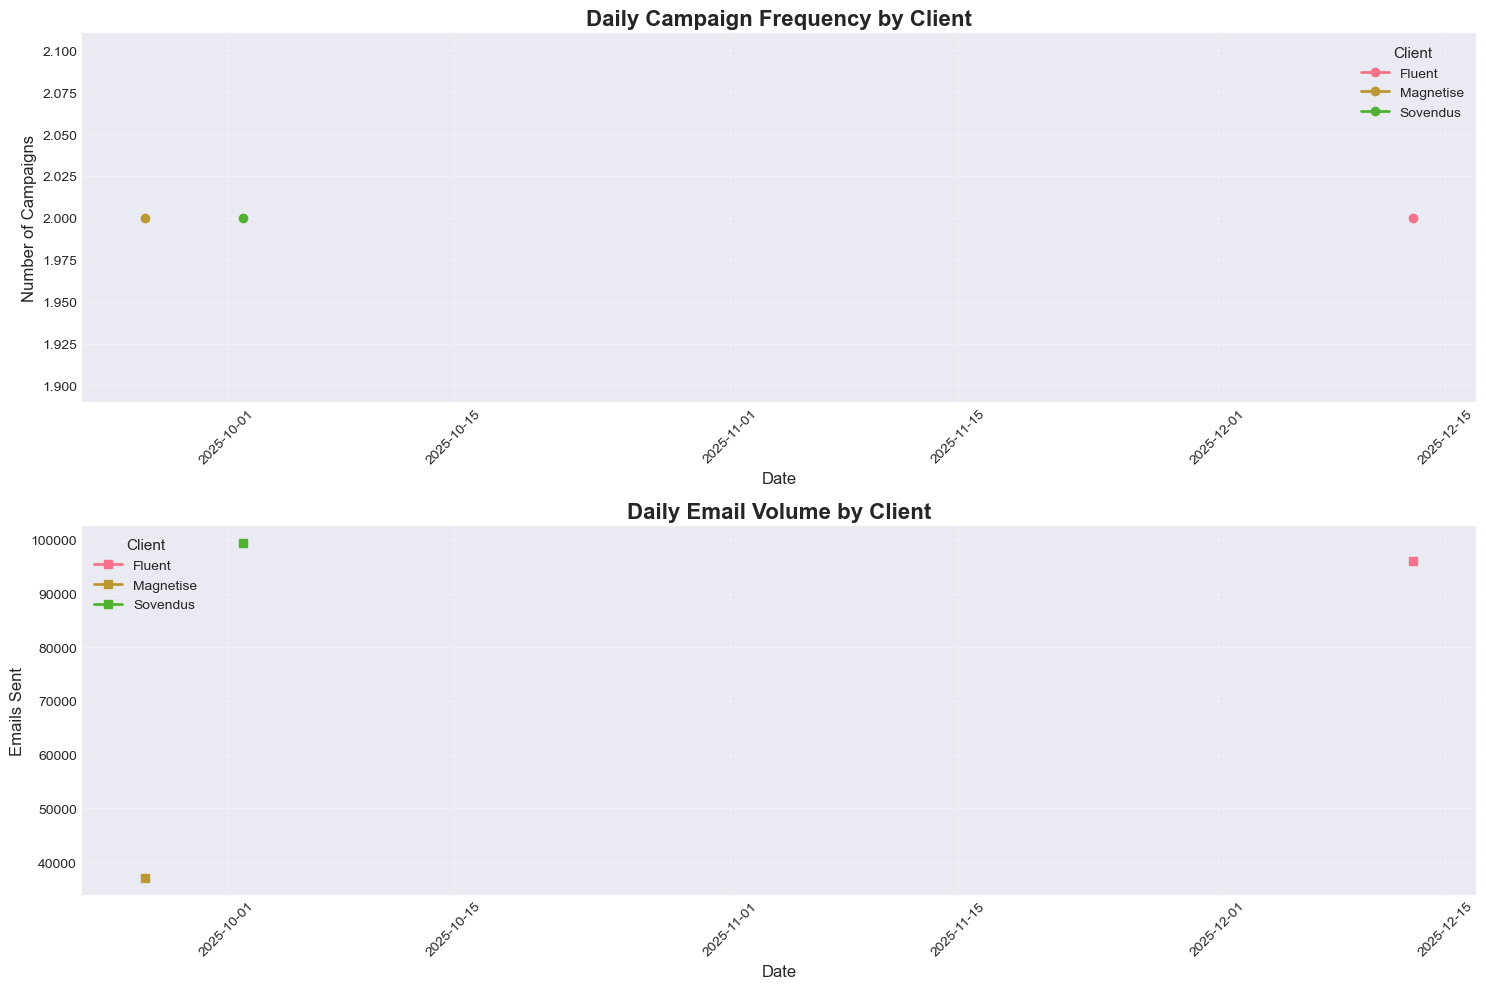

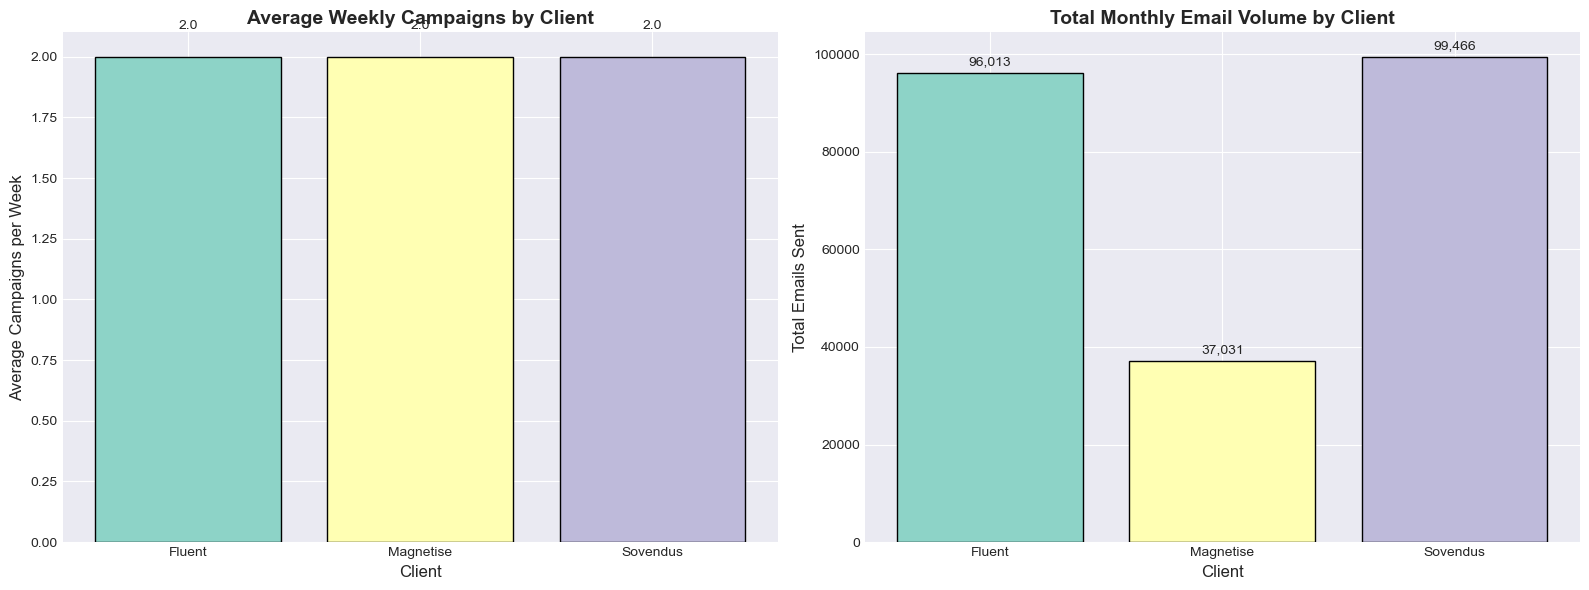

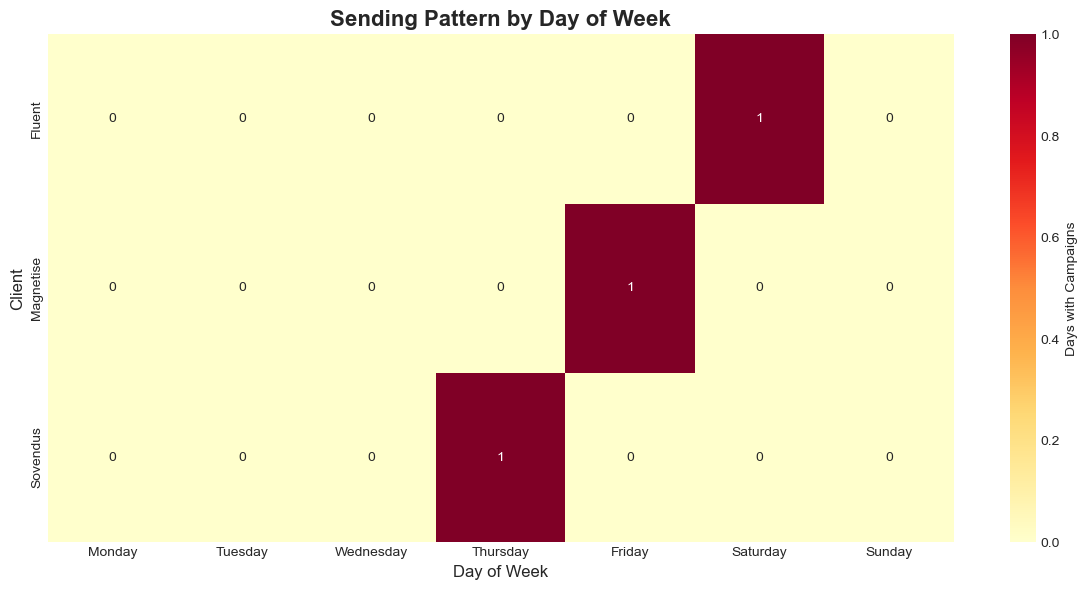

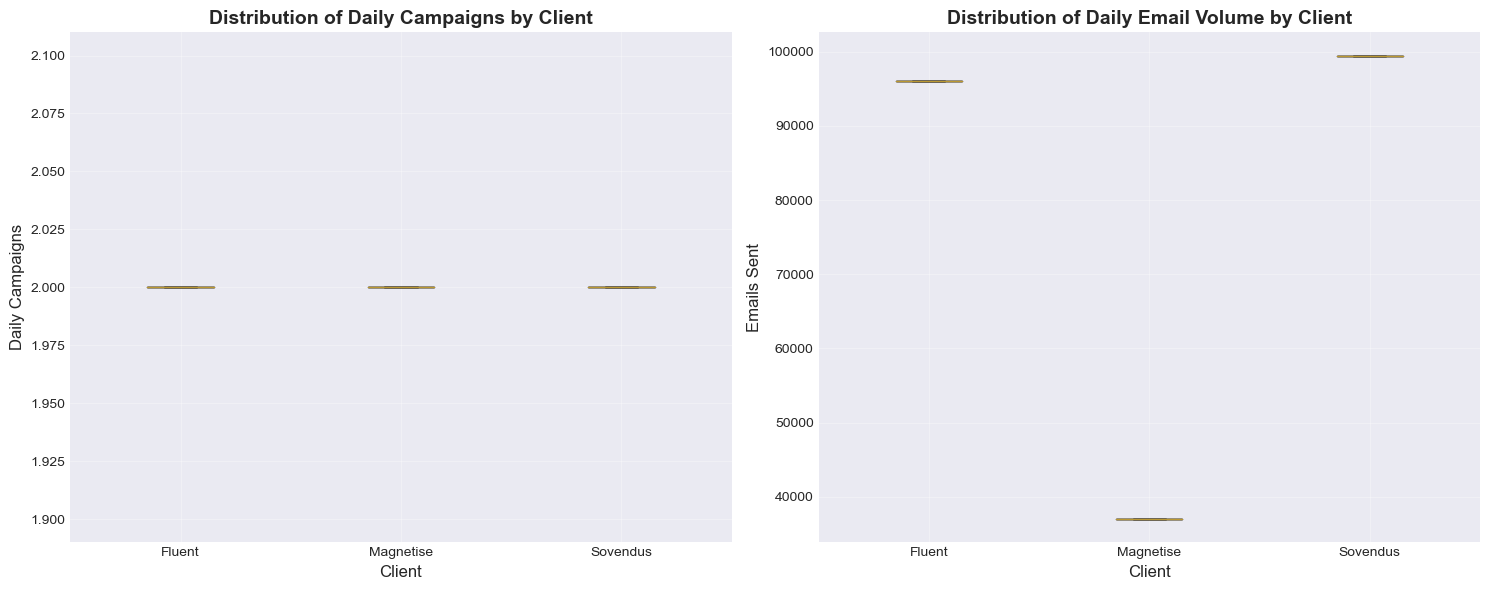

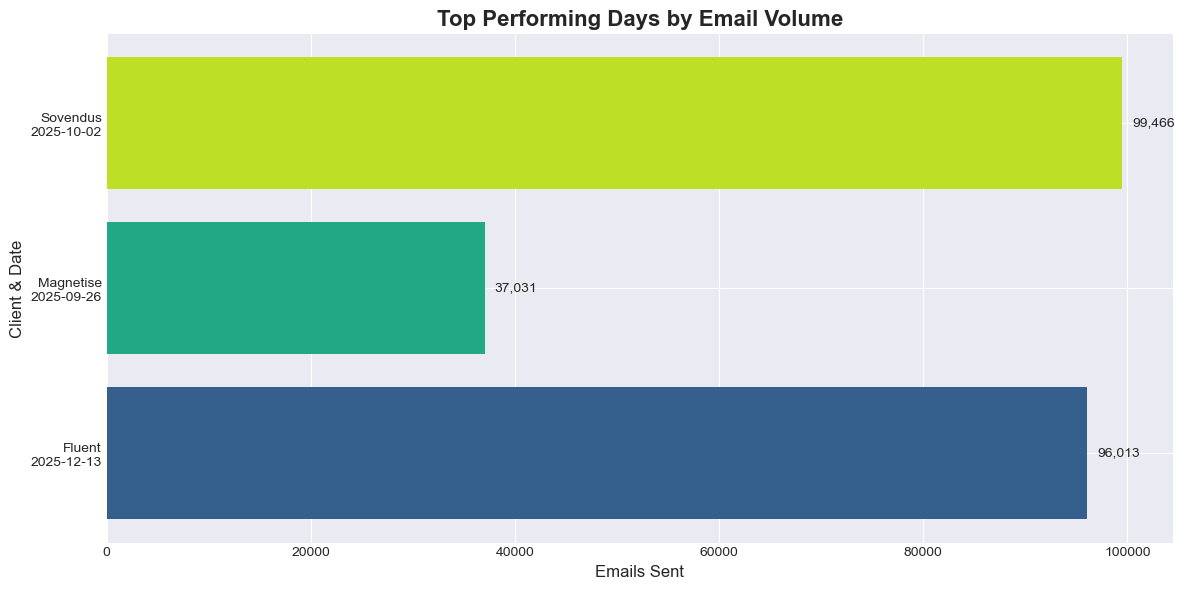

EMAIL FREQUENCY ANALYSIS INSIGHTS

📊 CLIENT: Fluent
   • Average daily campaigns: 2.00
   • Average daily emails sent: 96,013
   • Peak daily volume: 96,013 emails
   • Active days analyzed: 1
   • Sending pattern: Highly variable/Bursty

📊 CLIENT: Magnetise
   • Average daily campaigns: 2.00
   • Average daily emails sent: 37,031
   • Peak daily volume: 37,031 emails
   • Active days analyzed: 1
   • Sending pattern: Highly variable/Bursty

📊 CLIENT: Sovendus
   • Average daily campaigns: 2.00
   • Average daily emails sent: 99,466
   • Peak daily volume: 99,466 emails
   • Active days analyzed: 1
   • Sending pattern: Highly variable/Bursty

📈 COMPARATIVE ANALYSIS
   • Most aggressive sender: Sovendus (avg 99,466 emails/day)
   • Volume difference between highest & lowest sender: 2.7x
   • Peak performance achieved by: Fluent, Magnetise, Sovendus
   • Most common sending day: Friday

📅 DATA COVERAGE: 2025-09-26 to 2025-12-13 (3 days analyzed)
   • Total campaigns tracked: 6
   • Tota

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter
import calendar
from datetime import datetime, timedelta

def analyze_email_frequency(df):
    """
    Analyzes email frequency patterns for clients and generates visualizations with insights.
    
    Parameters:
    df (DataFrame): DataFrame with columns: client, sending_date, daily_campaigns, daily_sent, peak_rank
    """
    
    # Convert date column to datetime
    df['sending_date'] = pd.to_datetime(df['sending_date'])
    
    # Create time-based groupings
    df['year_month'] = df['sending_date'].dt.to_period('M')
    df['week_number'] = df['sending_date'].dt.isocalendar().week
    df['day_of_week'] = df['sending_date'].dt.day_name()
    df['month'] = df['sending_date'].dt.month_name()
    
    # Calculate summary statistics
    client_summary = df.groupby('client').agg({
        'daily_campaigns': ['sum', 'mean', 'std', 'max'],
        'daily_sent': ['sum', 'mean', 'std', 'max'],
        'sending_date': ['min', 'max', 'count']
    }).round(2)
    
    client_summary.columns = ['_'.join(col).strip() for col in client_summary.columns.values]
    client_summary = client_summary.reset_index()
    
    # Calculate daily frequency metrics
    daily_frequency = df.groupby(['client', 'sending_date']).agg({
        'daily_campaigns': 'sum',
        'daily_sent': 'sum'
    }).reset_index()
    
    # Calculate weekly aggregates
    weekly_agg = df.groupby(['client', df['sending_date'].dt.isocalendar().year, 
                            'week_number']).agg({
        'daily_campaigns': 'sum',
        'daily_sent': 'sum',
        'sending_date': 'count'
    }).reset_index()
    weekly_agg.rename(columns={'sending_date': 'days_active_in_week'}, inplace=True)
    
    # Calculate monthly aggregates
    monthly_agg = df.groupby(['client', 'year_month']).agg({
        'daily_campaigns': 'sum',
        'daily_sent': 'sum',
        'sending_date': 'count'
    }).reset_index()
    monthly_agg.rename(columns={'sending_date': 'days_active_in_month'}, inplace=True)
    
    # Set style for better visualization
    plt.style.use('seaborn-v0_8-darkgrid')
    sns.set_palette("husl")
    
    # 1. Time Series Analysis - Daily Volume
    fig1, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    
    # Plot daily campaigns
    for client in df['client'].unique():
        client_data = daily_frequency[daily_frequency['client'] == client]
        ax1.plot(client_data['sending_date'], client_data['daily_campaigns'], 
                marker='o', linewidth=2, label=client)
    
    ax1.set_title('Daily Campaign Frequency by Client', fontsize=16, fontweight='bold')
    ax1.set_xlabel('Date', fontsize=12)
    ax1.set_ylabel('Number of Campaigns', fontsize=12)
    ax1.legend(title='Client', fontsize=10, title_fontsize=11)
    ax1.grid(True, alpha=0.3)
    ax1.xaxis.set_major_formatter(DateFormatter("%Y-%m-%d"))
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
    
    # Plot daily emails sent
    for client in df['client'].unique():
        client_data = daily_frequency[daily_frequency['client'] == client]
        ax2.plot(client_data['sending_date'], client_data['daily_sent'], 
                marker='s', linewidth=2, label=client)
    
    ax2.set_title('Daily Email Volume by Client', fontsize=16, fontweight='bold')
    ax2.set_xlabel('Date', fontsize=12)
    ax2.set_ylabel('Emails Sent', fontsize=12)
    ax2.legend(title='Client', fontsize=10, title_fontsize=11)
    ax2.grid(True, alpha=0.3)
    ax2.xaxis.set_major_formatter(DateFormatter("%Y-%m-%d"))
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # 2. Weekly and Monthly Aggregates
    fig2, (ax3, ax4) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Weekly campaigns
    weekly_pivot = weekly_agg.pivot_table(index='client', values='daily_campaigns', aggfunc='mean').reset_index()
    colors = plt.cm.Set3(np.arange(len(weekly_pivot)))
    ax3.bar(weekly_pivot['client'], weekly_pivot['daily_campaigns'], color=colors, edgecolor='black')
    ax3.set_title('Average Weekly Campaigns by Client', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Client', fontsize=12)
    ax3.set_ylabel('Average Campaigns per Week', fontsize=12)
    
    # Add value labels on bars
    for i, v in enumerate(weekly_pivot['daily_campaigns']):
        ax3.text(i, v + 0.1, f'{v:.1f}', ha='center', va='bottom', fontsize=10)
    
    # Monthly email volume
    monthly_pivot = monthly_agg.pivot_table(index='client', values='daily_sent', aggfunc='sum').reset_index()
    ax4.bar(monthly_pivot['client'], monthly_pivot['daily_sent'], color=colors, edgecolor='black')
    ax4.set_title('Total Monthly Email Volume by Client', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Client', fontsize=12)
    ax4.set_ylabel('Total Emails Sent', fontsize=12)
    
    # Add value labels on bars
    for i, v in enumerate(monthly_pivot['daily_sent']):
        ax4.text(i, v + 1000, f'{v:,.0f}', ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # 3. Sending Pattern Heatmap
    if len(df) > 0:
        # Create day of week heatmap data
        day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        day_heatmap_data = pd.pivot_table(
            df,
            index='client',
            columns='day_of_week',
            values='daily_campaigns',
            aggfunc='count',
            fill_value=0
        )
        
        # Reorder columns
        day_heatmap_data = day_heatmap_data.reindex(columns=day_order, fill_value=0)
        
        fig3, ax5 = plt.subplots(figsize=(12, 6))
        sns.heatmap(
            day_heatmap_data,
            annot=True,
            fmt='g',
            cmap='YlOrRd',
            cbar_kws={'label': 'Days with Campaigns'},
            ax=ax5
        )
        ax5.set_title('Sending Pattern by Day of Week', fontsize=16, fontweight='bold')
        ax5.set_xlabel('Day of Week', fontsize=12)
        ax5.set_ylabel('Client', fontsize=12)
        plt.tight_layout()
        plt.show()
    
    # 4. Distribution Analysis
    fig4, (ax6, ax7) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Daily campaigns distribution
    box_data = [df[df['client'] == client]['daily_campaigns'].values 
                for client in df['client'].unique()]
    ax6.boxplot(box_data, labels=df['client'].unique())
    ax6.set_title('Distribution of Daily Campaigns by Client', fontsize=14, fontweight='bold')
    ax6.set_xlabel('Client', fontsize=12)
    ax6.set_ylabel('Daily Campaigns', fontsize=12)
    ax6.grid(True, alpha=0.3)
    
    # Daily sent distribution
    box_data_sent = [df[df['client'] == client]['daily_sent'].values 
                     for client in df['client'].unique()]
    ax7.boxplot(box_data_sent, labels=df['client'].unique())
    ax7.set_title('Distribution of Daily Email Volume by Client', fontsize=14, fontweight='bold')
    ax7.set_xlabel('Client', fontsize=12)
    ax7.set_ylabel('Emails Sent', fontsize=12)
    ax7.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 5. Peak Performance Analysis
    peak_days = df.nlargest(5, 'daily_sent') if len(df) >= 5 else df
    
    fig5, ax8 = plt.subplots(figsize=(12, 6))
    bars = ax8.barh(
        [f"{row['client']}\n{row['sending_date'].strftime('%Y-%m-%d')}" 
         for _, row in peak_days.iterrows()],
        peak_days['daily_sent'],
        color=plt.cm.viridis(np.linspace(0.3, 0.9, len(peak_days)))
    )
    
    ax8.set_title('Top Performing Days by Email Volume', fontsize=16, fontweight='bold')
    ax8.set_xlabel('Emails Sent', fontsize=12)
    ax8.set_ylabel('Client & Date', fontsize=12)
    
    # Add value labels
    for bar, val in zip(bars, peak_days['daily_sent']):
        width = bar.get_width()
        ax8.text(width + 1000, bar.get_y() + bar.get_height()/2, 
                f'{val:,.0f}', ha='left', va='center', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # Generate Insights
    print("="*80)
    print("EMAIL FREQUENCY ANALYSIS INSIGHTS")
    print("="*80)
    
    # Calculate insights based on actual data
    total_clients = df['client'].nunique()
    total_days = df['sending_date'].nunique()
    total_campaigns = df['daily_campaigns'].sum()
    total_emails = df['daily_sent'].sum()
    
    # Client-specific insights
    for client in df['client'].unique():
        client_data = df[df['client'] == client]
        avg_campaigns = client_data['daily_campaigns'].mean()
        avg_emails = client_data['daily_sent'].mean()
        max_emails = client_data['daily_sent'].max()
        consistency_score = client_data['daily_campaigns'].std() / avg_campaigns if avg_campaigns > 0 else 0
        
        print(f"\n📊 CLIENT: {client}")
        print(f"   • Average daily campaigns: {avg_campaigns:.2f}")
        print(f"   • Average daily emails sent: {avg_emails:,.0f}")
        print(f"   • Peak daily volume: {max_emails:,.0f} emails")
        print(f"   • Active days analyzed: {len(client_data)}")
        
        if consistency_score < 0.5:
            print(f"   • Sending pattern: Consistent")
        elif consistency_score < 1.0:
            print(f"   • Sending pattern: Moderately variable")
        else:
            print(f"   • Sending pattern: Highly variable/Bursty")
    
    # Comparative insights
    print(f"\n📈 COMPARATIVE ANALYSIS")
    
    # Find most aggressive sender
    avg_by_client = df.groupby('client')['daily_sent'].mean()
    most_aggressive = avg_by_client.idxmax()
    most_aggressive_avg = avg_by_client.max()
    
    print(f"   • Most aggressive sender: {most_aggressive} "
          f"(avg {most_aggressive_avg:,.0f} emails/day)")
    
    # Volume difference analysis
    if len(df['client'].unique()) > 1:
        volume_ratio = avg_by_client.max() / avg_by_client.min()
        print(f"   • Volume difference between highest & lowest sender: {volume_ratio:.1f}x")
    
    # Peak day analysis
    if 'peak_rank' in df.columns and df['peak_rank'].notna().any():
        peak_clients = df[df['peak_rank'] == 1]['client'].tolist()
        if peak_clients:
            print(f"   • Peak performance achieved by: {', '.join(set(peak_clients))}")
    
    # Daily pattern insights
    if 'day_of_week' in df.columns:
        busiest_day = df['day_of_week'].mode()[0] if not df['day_of_week'].mode().empty else "N/A"
        print(f"   • Most common sending day: {busiest_day}")
    
    # Data coverage note
    date_range = f"{df['sending_date'].min().strftime('%Y-%m-%d')} to {df['sending_date'].max().strftime('%Y-%m-%d')}"
    print(f"\n📅 DATA COVERAGE: {date_range} ({total_days} days analyzed)")
    print(f"   • Total campaigns tracked: {total_campaigns:,}")
    print(f"   • Total emails analyzed: {total_emails:,}")
    
    print("\n" + "="*80)
    print("RECOMMENDATIONS")
    print("="*80)
    
    # Generate recommendations based on patterns
    recommendations = []
    
    # Check for consistency
    for client in df['client'].unique():
        client_data = df[df['client'] == client]
        if len(client_data) > 5:  # Only analyze if sufficient data
            cv = client_data['daily_sent'].std() / client_data['daily_sent'].mean()
            if cv > 1.0:
                recommendations.append(
                    f"• {client}: Consider smoothing sending cadence to reduce variability"
                )
    
    # Check for volume differences
    if len(df['client'].unique()) > 1:
        vol_diff = avg_by_client.max() / avg_by_client.min()
        if vol_diff > 10:
            recommendations.append(
                "• Significant volume differences between clients detected - "
                "review segmentation strategy"
            )
    
    if recommendations:
        for rec in recommendations:
            print(rec)
    else:
        print("• Sending patterns appear appropriate for current scale")
    
    print("="*80)
    
    # Return summary dataframes for further analysis
    return {
        'client_summary': client_summary,
        'daily_frequency': daily_frequency,
        'weekly_agg': weekly_agg,
        'monthly_agg': monthly_agg
    }

# Run the analysis
results = analyze_email_frequency(df)

# Access the results if needed
print("\n📊 Summary Statistics:")
print(results['client_summary'])

# Identify most aggressive clients

In [83]:
SQL_NAME = "1_/1_6"
result = await SqlQuery.read_sql(SQL_NAME)

# Run in Jupyter
df = await fetch_data(result)
df.head(3)

total_campaigns  active_days  total_sent_volume   avg_campaign_size  \
0               29           29             545750  18818.965517241379   
1               27           26             825217  30563.592592592593   
2               24           24             674254  28093.916666666667   

                     client avg_campaigns_per_month sending_aggressiveness  \
0         Little Star Media                    7.25               MODERATE   
1                    Fluent                    6.75               MODERATE   
2  ForYouPromo (FRST Media)                    6.00               MODERATE   

        avg_open_rate_pct      avg_click_rate_pct total_revenue_generated  \
0  0.19831379310344827600  0.01037931034482758600                 3991.46   
1  0.20164814814814814800  0.02418518518518518500                 5325.02   
2  0.23282916666666666700  0.03034583333333333300                 4824.21   

  revenue_per_email  
0            0.0073  
1            0.0065  
2            0.0072

Starting Client-Level Email Performance Analysis...
--------------------------------------------------------------------------------


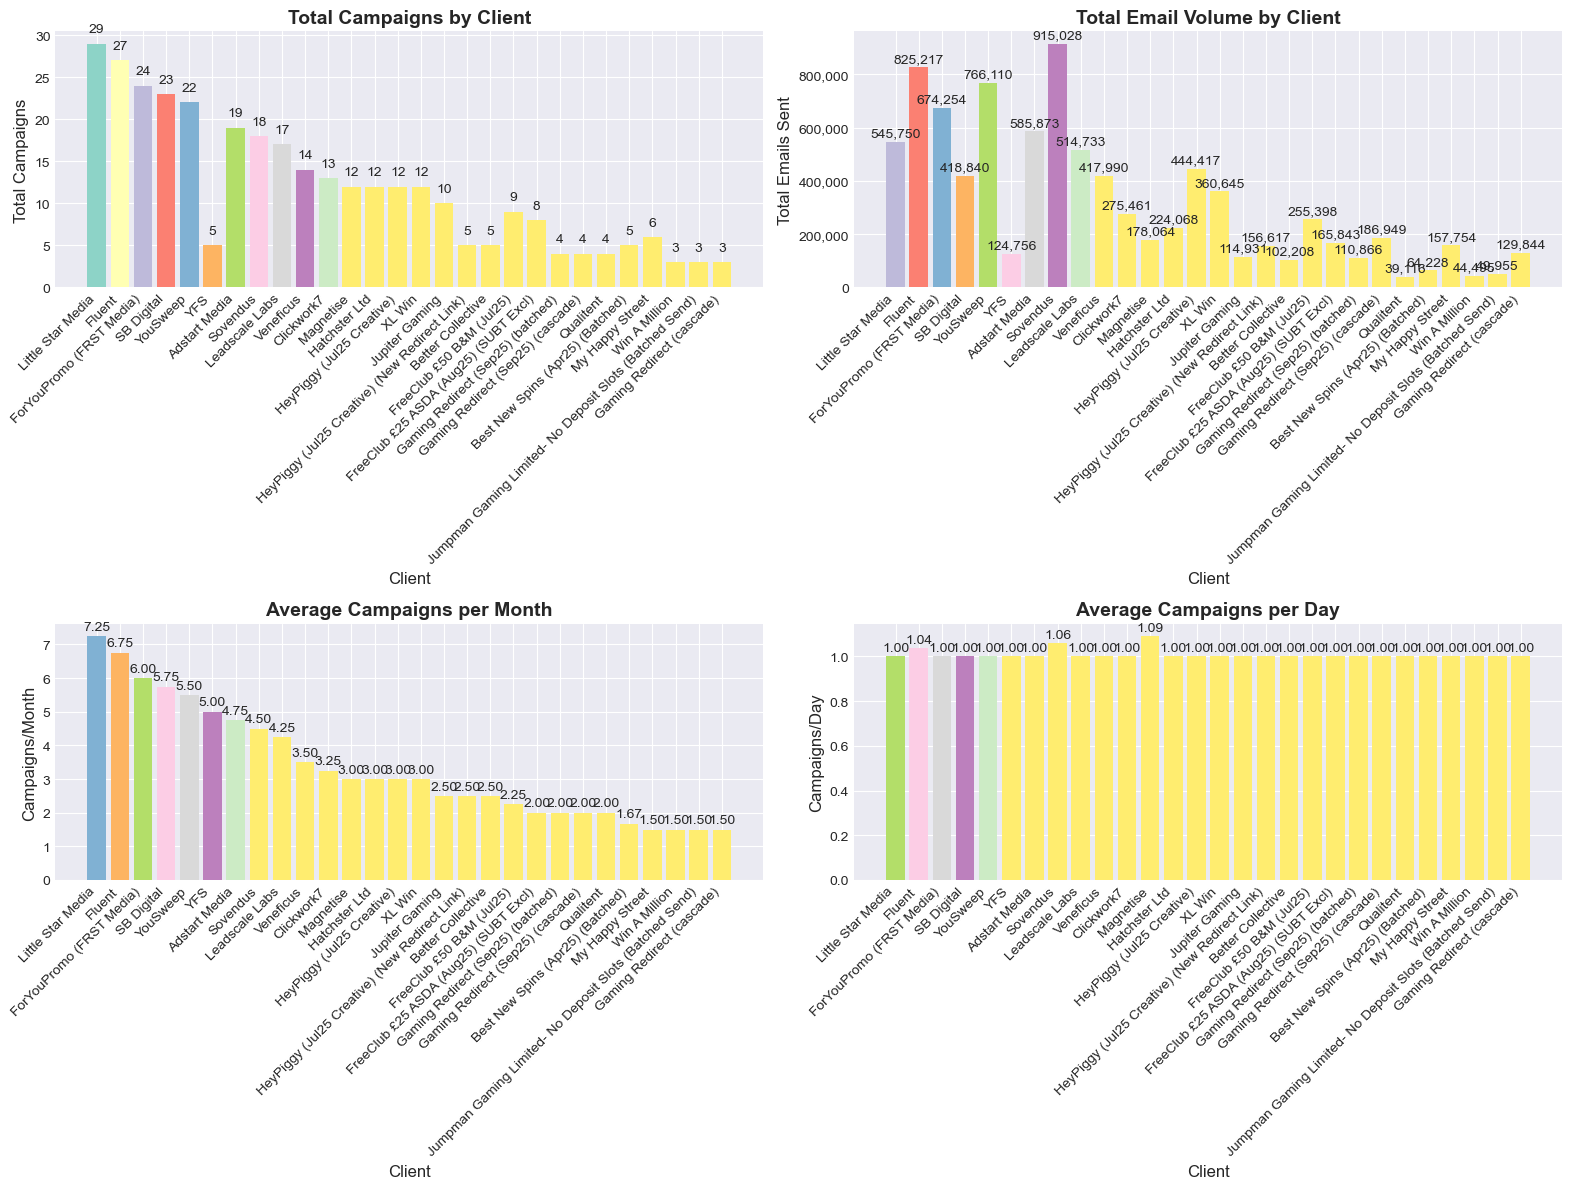

TypeError: unsupported operand type(s) for *: 'decimal.Decimal' and 'float'

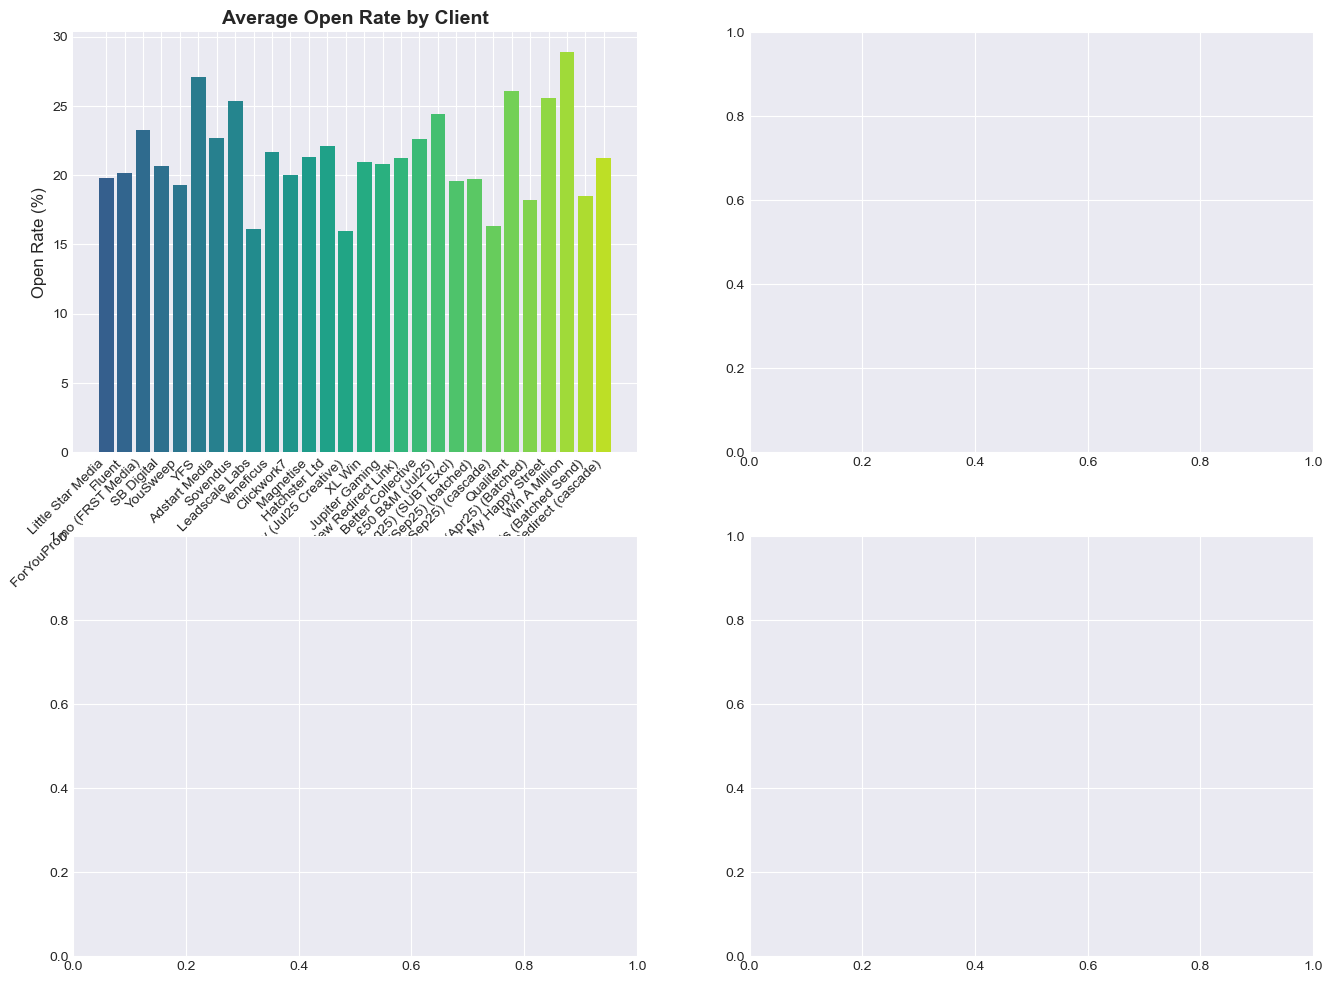

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter
import calendar
from datetime import datetime, timedelta

def analyze_client_email_metrics(df):
    """
    Analyzes client-level email performance metrics and generates visualizations with insights.
    
    Parameters:
    df (DataFrame): DataFrame with client-level aggregated metrics
    """
    
    # Create a copy to avoid modifying original
    df_analysis = df.copy()
    
    # Calculate additional derived metrics
    df_analysis['campaigns_per_day'] = df_analysis['total_campaigns'] / df_analysis['active_days']
    df_analysis['emails_per_day'] = df_analysis['total_sent_volume'] / df_analysis['active_days']
    df_analysis['revenue_per_campaign'] = df_analysis['total_revenue_generated'] / df_analysis['total_campaigns']
    df_analysis['engagement_score'] = (df_analysis['avg_open_rate_pct'] * 100 + 
                                      df_analysis['avg_click_rate_pct'] * 1000) / 2
    df_analysis['efficiency_score'] = (df_analysis['avg_open_rate_pct'] * df_analysis['revenue_per_email'] * 10000)
    
    # Set style for better visualization
    plt.style.use('seaborn-v0_8-darkgrid')
    sns.set_palette("husl")
    
    # 1. Volume & Frequency Overview
    fig1, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Total campaigns by client
    bars1 = ax1.bar(df_analysis['client'], df_analysis['total_campaigns'], 
                   color=plt.cm.Set3(np.arange(len(df_analysis))))
    ax1.set_title('Total Campaigns by Client', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Client', fontsize=12)
    ax1.set_ylabel('Total Campaigns', fontsize=12)
    ax1.set_xticklabels(df_analysis['client'], rotation=45, ha='right')
    
    # Add value labels
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{height:.0f}', ha='center', va='bottom', fontsize=10)
    
    # Total email volume by client
    bars2 = ax2.bar(df_analysis['client'], df_analysis['total_sent_volume'], 
                   color=plt.cm.Set3(np.arange(len(df_analysis)) + 2))
    ax2.set_title('Total Email Volume by Client', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Client', fontsize=12)
    ax2.set_ylabel('Total Emails Sent', fontsize=12)
    ax2.set_xticklabels(df_analysis['client'], rotation=45, ha='right')
    
    # Format y-axis with comma separator
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    # Add value labels
    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 10000,
                f'{height:,.0f}', ha='center', va='bottom', fontsize=10)
    
    # Average campaigns per month
    bars3 = ax3.bar(df_analysis['client'], df_analysis['avg_campaigns_per_month'], 
                   color=plt.cm.Set3(np.arange(len(df_analysis)) + 4))
    ax3.set_title('Average Campaigns per Month', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Client', fontsize=12)
    ax3.set_ylabel('Campaigns/Month', fontsize=12)
    ax3.set_xticklabels(df_analysis['client'], rotation=45, ha='right')
    
    # Add value labels
    for bar in bars3:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{height:.2f}', ha='center', va='bottom', fontsize=10)
    
    # Campaigns per day
    bars4 = ax4.bar(df_analysis['client'], df_analysis['campaigns_per_day'], 
                   color=plt.cm.Set3(np.arange(len(df_analysis)) + 6))
    ax4.set_title('Average Campaigns per Day', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Client', fontsize=12)
    ax4.set_ylabel('Campaigns/Day', fontsize=12)
    ax4.set_xticklabels(df_analysis['client'], rotation=45, ha='right')
    
    # Add value labels
    for bar in bars4:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.2f}', ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # 2. Engagement & Revenue Metrics
    fig2, ((ax5, ax6), (ax7, ax8)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Open Rate
    bars5 = ax5.bar(df_analysis['client'], df_analysis['avg_open_rate_pct'] * 100, 
                   color=plt.cm.viridis(np.linspace(0.3, 0.9, len(df_analysis))))
    ax5.set_title('Average Open Rate by Client', fontsize=14, fontweight='bold')
    ax5.set_xlabel('Client', fontsize=12)
    ax5.set_ylabel('Open Rate (%)', fontsize=12)
    ax5.set_xticklabels(df_analysis['client'], rotation=45, ha='right')
    ax5.set_ylim(0, max(df_analysis['avg_open_rate_pct'] * 100) * 1.2)
    
    # Add value labels
    for bar in bars5:
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=10)
    
    # Click Rate
    bars6 = ax6.bar(df_analysis['client'], df_analysis['avg_click_rate_pct'] * 100, 
                   color=plt.cm.viridis(np.linspace(0.2, 0.8, len(df_analysis))))
    ax6.set_title('Average Click Rate by Client', fontsize=14, fontweight='bold')
    ax6.set_xlabel('Client', fontsize=12)
    ax6.set_ylabel('Click Rate (%)', fontsize=12)
    ax6.set_xticklabels(df_analysis['client'], rotation=45, ha='right')
    ax6.set_ylim(0, max(df_analysis['avg_click_rate_pct'] * 100) * 1.2)
    
    # Add value labels
    for bar in bars6:
        height = bar.get_height()
        ax6.text(bar.get_x() + bar.get_width()/2., height + 0.05,
                f'{height:.2f}%', ha='center', va='bottom', fontsize=10)
    
    # Total Revenue
    bars7 = ax7.bar(df_analysis['client'], df_analysis['total_revenue_generated'], 
                   color=plt.cm.plasma(np.linspace(0.3, 0.9, len(df_analysis))))
    ax7.set_title('Total Revenue Generated by Client', fontsize=14, fontweight='bold')
    ax7.set_xlabel('Client', fontsize=12)
    ax7.set_ylabel('Revenue ($)', fontsize=12)
    ax7.set_xticklabels(df_analysis['client'], rotation=45, ha='right')
    
    # Add value labels
    for bar in bars7:
        height = bar.get_height()
        ax7.text(bar.get_x() + bar.get_width()/2., height + 50,
                f'${height:,.2f}', ha='center', va='bottom', fontsize=10)
    
    # Revenue per Email
    bars8 = ax8.bar(df_analysis['client'], df_analysis['revenue_per_email'] * 100, 
                   color=plt.cm.plasma(np.linspace(0.2, 0.8, len(df_analysis))))
    ax8.set_title('Revenue per Email (CPE)', fontsize=14, fontweight='bold')
    ax8.set_xlabel('Client', fontsize=12)
    ax8.set_ylabel('Revenue per Email (cents)', fontsize=12)
    ax8.set_xticklabels(df_analysis['client'], rotation=45, ha='right')
    
    # Add value labels
    for bar in bars8:
        height = bar.get_height()
        ax8.text(bar.get_x() + bar.get_width()/2., height + 0.05,
                f'{height:.2f}¢', ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # 3. Scatter Plot Analysis: Frequency vs Performance
    fig3, ((ax9, ax10), (ax11, ax12)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Campaigns per day vs Open Rate
    scatter1 = ax9.scatter(df_analysis['campaigns_per_day'], 
                          df_analysis['avg_open_rate_pct'] * 100,
                          s=df_analysis['total_sent_volume']/10000,
                          c=df_analysis['revenue_per_email'] * 10000,
                          cmap='RdYlGn', alpha=0.8, edgecolors='black')
    
    # Add client labels
    for i, client in enumerate(df_analysis['client']):
        ax9.annotate(client, 
                    (df_analysis['campaigns_per_day'].iloc[i], 
                     df_analysis['avg_open_rate_pct'].iloc[i] * 100),
                    fontsize=9, ha='center', va='bottom')
    
    ax9.set_title('Frequency vs Open Rate', fontsize=14, fontweight='bold')
    ax9.set_xlabel('Campaigns per Day', fontsize=12)
    ax9.set_ylabel('Open Rate (%)', fontsize=12)
    ax9.grid(True, alpha=0.3)
    
    # Add colorbar for revenue per email
    cbar1 = fig3.colorbar(scatter1, ax=ax9)
    cbar1.set_label('Revenue Efficiency Score', fontsize=10)
    
    # Campaigns per day vs Click Rate
    scatter2 = ax10.scatter(df_analysis['campaigns_per_day'], 
                           df_analysis['avg_click_rate_pct'] * 100,
                           s=df_analysis['total_sent_volume']/10000,
                           c=df_analysis['revenue_per_email'] * 10000,
                           cmap='RdYlGn', alpha=0.8, edgecolors='black')
    
    for i, client in enumerate(df_analysis['client']):
        ax10.annotate(client, 
                     (df_analysis['campaigns_per_day'].iloc[i], 
                      df_analysis['avg_click_rate_pct'].iloc[i] * 100),
                     fontsize=9, ha='center', va='bottom')
    
    ax10.set_title('Frequency vs Click Rate', fontsize=14, fontweight='bold')
    ax10.set_xlabel('Campaigns per Day', fontsize=12)
    ax10.set_ylabel('Click Rate (%)', fontsize=12)
    ax10.grid(True, alpha=0.3)
    
    # Add colorbar for revenue per email
    cbar2 = fig3.colorbar(scatter2, ax=ax10)
    cbar2.set_label('Revenue Efficiency Score', fontsize=10)
    
    # Total Volume vs Revenue
    scatter3 = ax11.scatter(df_analysis['total_sent_volume'], 
                           df_analysis['total_revenue_generated'],
                           s=df_analysis['total_campaigns']*20,
                           c=df_analysis['avg_open_rate_pct'] * 100,
                           cmap='Blues', alpha=0.8, edgecolors='black')
    
    for i, client in enumerate(df_analysis['client']):
        ax11.annotate(client, 
                     (df_analysis['total_sent_volume'].iloc[i], 
                      df_analysis['total_revenue_generated'].iloc[i]),
                     fontsize=9, ha='center', va='bottom')
    
    ax11.set_title('Email Volume vs Total Revenue', fontsize=14, fontweight='bold')
    ax11.set_xlabel('Total Emails Sent', fontsize=12)
    ax11.set_ylabel('Total Revenue ($)', fontsize=12)
    ax11.grid(True, alpha=0.3)
    ax11.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    # Add colorbar for open rate
    cbar3 = fig3.colorbar(scatter3, ax=ax11)
    cbar3.set_label('Open Rate (%)', fontsize=10)
    
    # Campaign Size vs Engagement
    scatter4 = ax12.scatter(df_analysis['avg_campaign_size'], 
                           df_analysis['avg_click_rate_pct'] * 100,
                           s=df_analysis['total_revenue_generated']/10,
                           c=df_analysis['campaigns_per_day'],
                           cmap='viridis', alpha=0.8, edgecolors='black')
    
    for i, client in enumerate(df_analysis['client']):
        ax12.annotate(client, 
                     (df_analysis['avg_campaign_size'].iloc[i], 
                      df_analysis['avg_click_rate_pct'].iloc[i] * 100),
                     fontsize=9, ha='center', va='bottom')
    
    ax12.set_title('Campaign Size vs Click Rate', fontsize=14, fontweight='bold')
    ax12.set_xlabel('Average Campaign Size (emails)', fontsize=12)
    ax12.set_ylabel('Click Rate (%)', fontsize=12)
    ax12.grid(True, alpha=0.3)
    ax12.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    # Add colorbar for frequency
    cbar4 = fig3.colorbar(scatter4, ax=ax12)
    cbar4.set_label('Campaigns per Day', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # 4. Performance Matrix Heatmap
    fig4, ax13 = plt.subplots(figsize=(12, 8))
    
    # Select key metrics for heatmap
    heatmap_metrics = df_analysis[['client', 
                                  'campaigns_per_day', 
                                  'avg_open_rate_pct', 
                                  'avg_click_rate_pct',
                                  'revenue_per_email',
                                  'total_revenue_generated']].copy()
    
    # Normalize metrics for comparison (0-1 scale)
    normalized_data = heatmap_metrics.copy()
    for col in heatmap_metrics.columns[1:]:
        normalized_data[col] = (heatmap_metrics[col] - heatmap_metrics[col].min()) / \
                              (heatmap_metrics[col].max() - heatmap_metrics[col].min())
    
    # Set client as index for heatmap
    heatmap_data = normalized_data.set_index('client')
    
    # Create heatmap
    sns.heatmap(heatmap_data, 
                annot=heatmap_metrics.set_index('client').round(3),
                fmt='.3f',
                cmap='RdYlGn',
                cbar_kws={'label': 'Normalized Score (0-1)'},
                ax=ax13,
                linewidths=1,
                linecolor='gray')
    
    ax13.set_title('Client Performance Matrix Heatmap', fontsize=16, fontweight='bold')
    ax13.set_xlabel('Performance Metrics', fontsize=12)
    ax13.set_ylabel('Client', fontsize=12)
    
    # Set custom annotations for original values
    ax13.set_xticklabels(['Cmp/Day', 'Open Rate', 'Click Rate', 'Rev/Email', 'Total Rev'], 
                        rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()
    
    # 5. Sending Aggressiveness Analysis
    fig5, ax14 = plt.subplots(figsize=(10, 6))
    
    # Group by sending aggressiveness
    if 'sending_aggressiveness' in df_analysis.columns:
        agg_groups = df_analysis.groupby('sending_aggressiveness').size().reset_index(name='count')
        
        colors = plt.cm.Set2(np.arange(len(agg_groups)))
        wedges, texts, autotexts = ax14.pie(agg_groups['count'], 
                                           labels=agg_groups['sending_aggressiveness'],
                                           autopct='%1.1f%%',
                                           colors=colors,
                                           startangle=90,
                                           explode=[0.05] * len(agg_groups))
        
        ax14.set_title('Distribution of Sending Aggressiveness', fontsize=16, fontweight='bold')
        
        # Style the text
        for text in texts:
            text.set_fontsize(12)
        for autotext in autotexts:
            autotext.set_fontsize(11)
            autotext.set_fontweight('bold')
    else:
        ax14.text(0.5, 0.5, 'No sending aggressiveness data available', 
                 ha='center', va='center', fontsize=14, transform=ax14.transAxes)
        ax14.set_title('Sending Aggressiveness', fontsize=16, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Generate Insights
    print("="*80)
    print("CLIENT-LEVEL EMAIL PERFORMANCE INSIGHTS")
    print("="*80)
    
    # Calculate overall metrics
    total_clients = len(df_analysis)
    total_emails = df_analysis['total_sent_volume'].sum()
    total_revenue = df_analysis['total_revenue_generated'].sum()
    avg_open_rate = df_analysis['avg_open_rate_pct'].mean() * 100
    avg_click_rate = df_analysis['avg_click_rate_pct'].mean() * 100
    
    print(f"\n📊 OVERVIEW METRICS:")
    print(f"   • Total Clients Analyzed: {total_clients}")
    print(f"   • Total Emails Sent: {total_emails:,.0f}")
    print(f"   • Total Revenue Generated: ${total_revenue:,.2f}")
    print(f"   • Average Open Rate: {avg_open_rate:.2f}%")
    print(f"   • Average Click Rate: {avg_click_rate:.3f}%")
    
    # Client-specific insights
    print(f"\n🏆 TOP PERFORMERS:")
    
    # Find best performers in each category
    best_open = df_analysis.loc[df_analysis['avg_open_rate_pct'].idxmax()]
    best_click = df_analysis.loc[df_analysis['avg_click_rate_pct'].idxmax()]
    best_revenue = df_analysis.loc[df_analysis['total_revenue_generated'].idxmax()]
    best_revenue_per_email = df_analysis.loc[df_analysis['revenue_per_email'].idxmax()]
    
    print(f"   • Highest Open Rate: {best_open['client']} ({best_open['avg_open_rate_pct']*100:.2f}%)")
    print(f"   • Highest Click Rate: {best_click['client']} ({best_click['avg_click_rate_pct']*100:.3f}%)")
    print(f"   • Highest Total Revenue: {best_revenue['client']} (${best_revenue['total_revenue_generated']:,.2f})")
    print(f"   • Best Revenue per Email: {best_revenue_per_email['client']} (${best_revenue_per_email['revenue_per_email']:.4f} per email)")
    
    # Frequency insights
    print(f"\n📈 FREQUENCY ANALYSIS:")
    
    most_frequent = df_analysis.loc[df_analysis['campaigns_per_day'].idxmax()]
    least_frequent = df_analysis.loc[df_analysis['campaigns_per_day'].idxmin()]
    
    print(f"   • Most Frequent Sender: {most_frequent['client']} ({most_frequent['campaigns_per_day']:.3f} campaigns/day)")
    print(f"   • Least Frequent Sender: {least_frequent['client']} ({least_frequent['campaigns_per_day']:.3f} campaigns/day)")
    print(f"   • Frequency Range: {least_frequent['campaigns_per_day']:.3f} to {most_frequent['campaigns_per_day']:.3f} campaigns/day")
    
    # Volume insights
    largest_volume = df_analysis.loc[df_analysis['total_sent_volume'].idxmax()]
    print(f"   • Largest Email Volume: {largest_volume['client']} ({largest_volume['total_sent_volume']:,.0f} emails)")
    
    # Campaign size insights
    largest_campaign = df_analysis.loc[df_analysis['avg_campaign_size'].idxmax()]
    smallest_campaign = df_analysis.loc[df_analysis['avg_campaign_size'].idxmin()]
    
    print(f"   • Largest Average Campaign: {largest_campaign['client']} ({largest_campaign['avg_campaign_size']:,.0f} emails/campaign)")
    print(f"   • Smallest Average Campaign: {smallest_campaign['client']} ({smallest_campaign['avg_campaign_size']:,.0f} emails/campaign)")
    
    # Engagement-performance correlation
    print(f"\n🔗 CORRELATION INSIGHTS:")
    
    # Calculate correlations
    frequency_vs_open = df_analysis['campaigns_per_day'].corr(df_analysis['avg_open_rate_pct'])
    frequency_vs_click = df_analysis['campaigns_per_day'].corr(df_analysis['avg_click_rate_pct'])
    volume_vs_revenue = df_analysis['total_sent_volume'].corr(df_analysis['total_revenue_generated'])
    
    print(f"   • Frequency vs Open Rate Correlation: {frequency_vs_open:.3f}")
    print(f"   • Frequency vs Click Rate Correlation: {frequency_vs_click:.3f}")
    print(f"   • Volume vs Revenue Correlation: {volume_vs_revenue:.3f}")
    
    # Interpret correlations
    if abs(frequency_vs_open) > 0.5:
        direction = "positive" if frequency_vs_open > 0 else "negative"
        print(f"     → Strong {direction} relationship between frequency and open rates")
    elif abs(frequency_vs_open) > 0.2:
        direction = "positive" if frequency_vs_open > 0 else "negative"
        print(f"     → Moderate {direction} relationship between frequency and open rates")
    else:
        print(f"     → Weak relationship between frequency and open rates")
    
    if abs(volume_vs_revenue) > 0.7:
        print(f"     → Very strong relationship between email volume and revenue")
    
    # Efficiency analysis
    print(f"\n💰 EFFICIENCY ANALYSIS:")
    
    # Calculate ROI-like metrics
    df_analysis['roi_percentage'] = (df_analysis['total_revenue_generated'] / 
                                    (df_analysis['total_sent_volume'] * 0.001)) * 100
    
    best_roi = df_analysis.loc[df_analysis['roi_percentage'].idxmax()]
    worst_roi = df_analysis.loc[df_analysis['roi_percentage'].idxmin()]
    
    print(f"   • Most Efficient Client: {best_roi['client']} (ROI: {best_roi['roi_percentage']:.4f}%)")
    print(f"   • Least Efficient Client: {worst_roi['client']} (ROI: {worst_roi['roi_percentage']:.4f}%)")
    
    # Engagement consistency
    print(f"\n🎯 ENGAGEMENT CONSISTENCY:")
    
    open_rate_range = (df_analysis['avg_open_rate_pct'].max() * 100 - 
                      df_analysis['avg_open_rate_pct'].min() * 100)
    click_rate_range = (df_analysis['avg_click_rate_pct'].max() * 100 - 
                       df_analysis['avg_click_rate_pct'].min() * 100)
    
    print(f"   • Open Rate Range: {open_rate_range:.2f}% across clients")
    print(f"   • Click Rate Range: {click_rate_range:.3f}% across clients")
    
    # Recommendations
    print("\n" + "="*80)
    print("RECOMMENDATIONS & ACTION ITEMS")
    print("="*80)
    
    recommendations = []
    
    # Check for engagement trade-offs
    for _, client in df_analysis.iterrows():
        if client['campaigns_per_day'] > 1.0 and client['avg_open_rate_pct'] < 0.2:
            recommendations.append(
                f"• {client['client']}: High frequency but low engagement - "
                f"consider optimizing content or reducing frequency"
            )
        elif client['avg_click_rate_pct'] > 0.025 and client['revenue_per_email'] < 0.006:
            recommendations.append(
                f"• {client['client']}: Good engagement but low revenue conversion - "
                f"review offer strategy or landing pages"
            )
    
    # Identify opportunities
    avg_campaigns_per_day = df_analysis['campaigns_per_day'].mean()
    for _, client in df_analysis.iterrows():
        if (client['campaigns_per_day'] < avg_campaigns_per_day * 0.5 and 
            client['avg_open_rate_pct'] > df_analysis['avg_open_rate_pct'].mean()):
            recommendations.append(
                f"• {client['client']}: Under-sending with above-average engagement - "
                f"opportunity to increase frequency"
            )
    
    # Volume efficiency
    avg_revenue_per_email = df_analysis['revenue_per_email'].mean()
    for _, client in df_analysis.iterrows():
        if (client['total_sent_volume'] > df_analysis['total_sent_volume'].median() and 
            client['revenue_per_email'] < avg_revenue_per_email * 0.5):
            recommendations.append(
                f"• {client['client']}: High volume but low efficiency - "
                f"consider audience segmentation or content optimization"
            )
    
    if recommendations:
        for i, rec in enumerate(recommendations, 1):
            print(f"{rec}")
    else:
        print("• All clients showing balanced performance - focus on incremental optimization")
    
    print("\n📊 Quick Wins to Prioritize:")
    
    # Identify quick wins
    if best_open['client'] != best_click['client']:
        print(f"• Share {best_open['client']}'s open rate strategies with {best_click['client']}")
    
    if best_revenue_per_email['client'] != best_revenue['client']:
        print(f"• Apply {best_revenue_per_email['client']}'s efficiency tactics to high-volume senders")
    
    print("\n" + "="*80)
    
    # Return enriched dataframe for further analysis
    return df_analysis


# Run the analysis
print("Starting Client-Level Email Performance Analysis...")
print("-" * 80)

enriched_df = analyze_client_email_metrics(df)

# Show enriched dataframe
print("\n📋 Enriched Data with Calculated Metrics:")
print("-" * 80)
display_cols = ['client', 'campaigns_per_day', 'emails_per_day', 
                'revenue_per_campaign', 'engagement_score', 'efficiency_score']

for col in display_cols:
    if col in enriched_df.columns:
        print(f"\n{col.replace('_', ' ').title()}:")
        for _, row in enriched_df.iterrows():
            if col in ['engagement_score', 'efficiency_score']:
                print(f"  {row['client']}: {row[col]:.2f}")
            elif col == 'revenue_per_campaign':
                print(f"  {row['client']}: ${row[col]:.2f}")
            elif col == 'emails_per_day':
                print(f"  {row['client']}: {row[col]:,.0f}")
            else:
                print(f"  {row['client']}: {row[col]:.3f}")

# Analyze if frequency aligns with engagement and revenue

In [85]:
SQL_NAME = "1_/1_7"
result = await SqlQuery.read_sql(SQL_NAME)

# Run in Jupyter
df = await fetch_data(result)
df.head(3)

client  total_campaigns  active_days  total_sent  \
0  Magnetise               12           11      178064   
1   Sovendus               18           17      915028   
2     Fluent               27           26      825217   

        avg_open_rate_pct      avg_click_rate_pct total_revenue  \
0  0.21321666666666666700  0.01285000000000000000       3247.80   
1  0.25350000000000000000  0.03848888888888888900       9270.70   
2  0.20164814814814814800  0.02418518518518518500       5325.02   

  avg_revenue_per_campaign campaigns_per_day_ratio frequency_effectiveness  \
0     270.6500000000000000                    1.09            NEEDS REVIEW   
1     515.0388888888888889                    1.06            NEEDS REVIEW   
2     197.2229629629629630                    1.04            NEEDS REVIEW   

                              revenue_justification  
0  APPROPRIATE: Frequency matches revenue potential  
1  APPROPRIATE: Frequency matches revenue potential  
2  APPROPRIATE: Frequency matches revenue potential

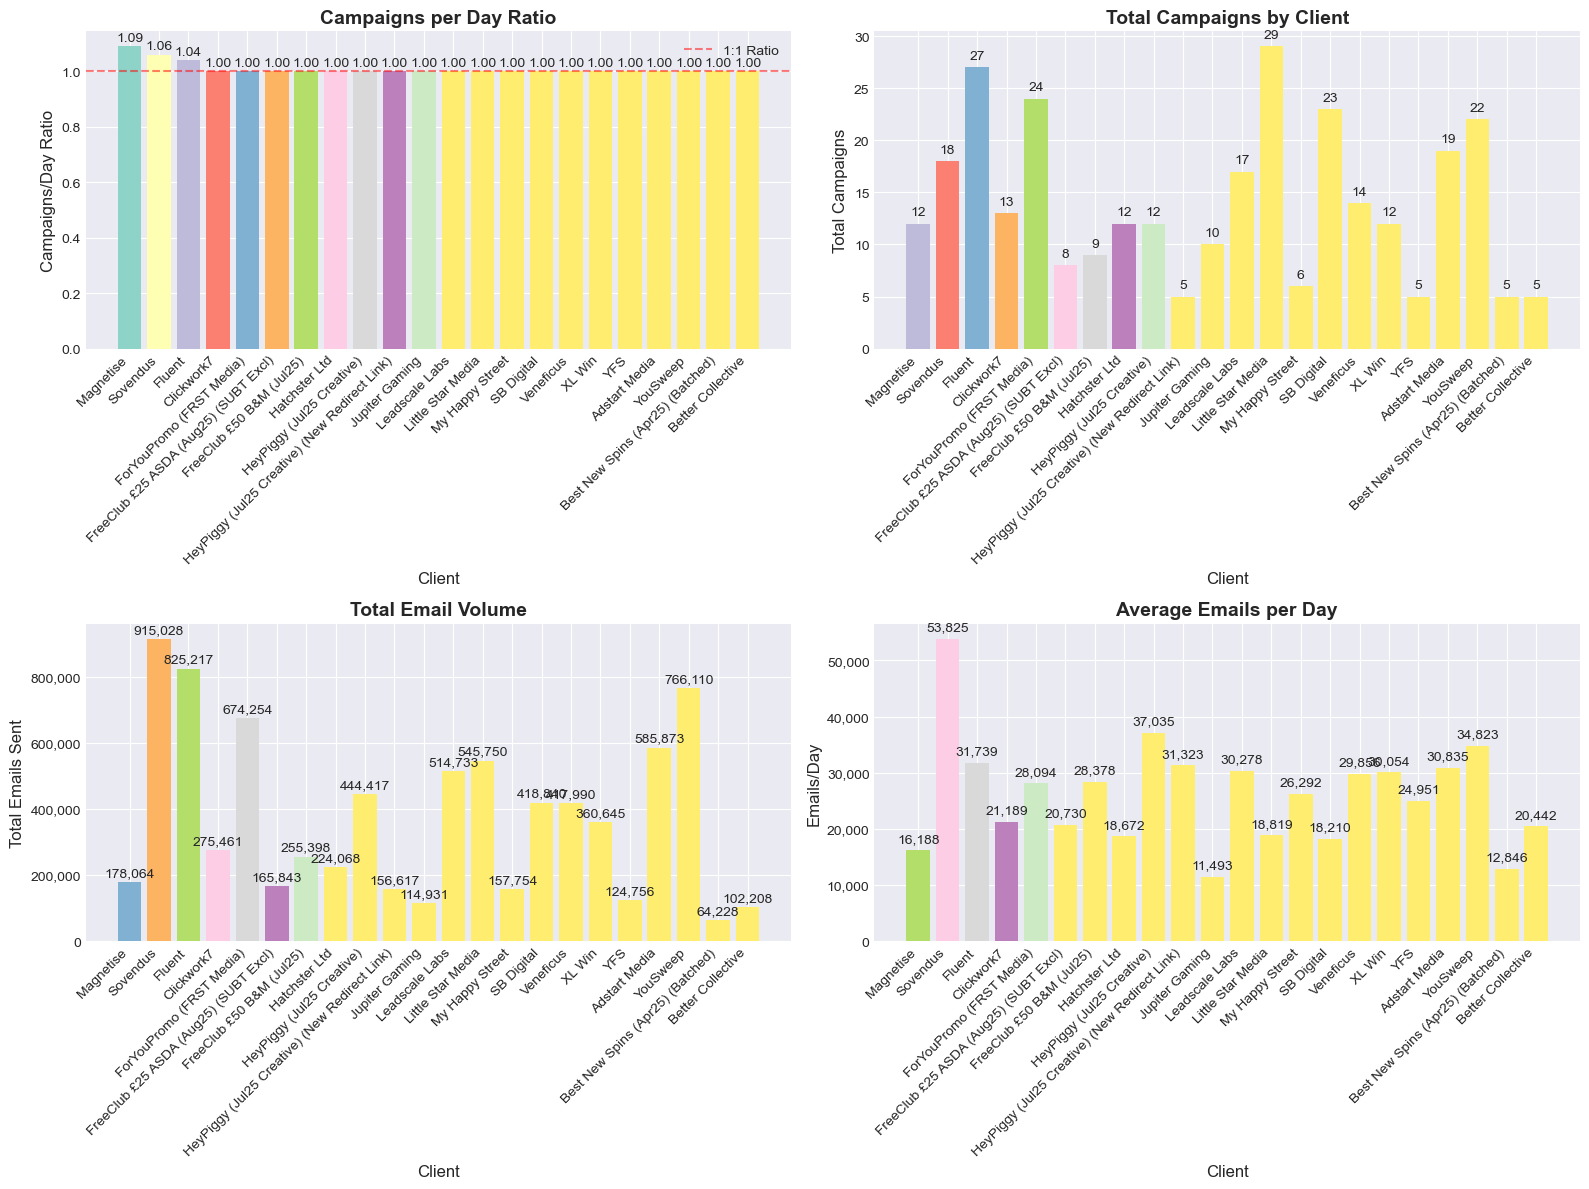

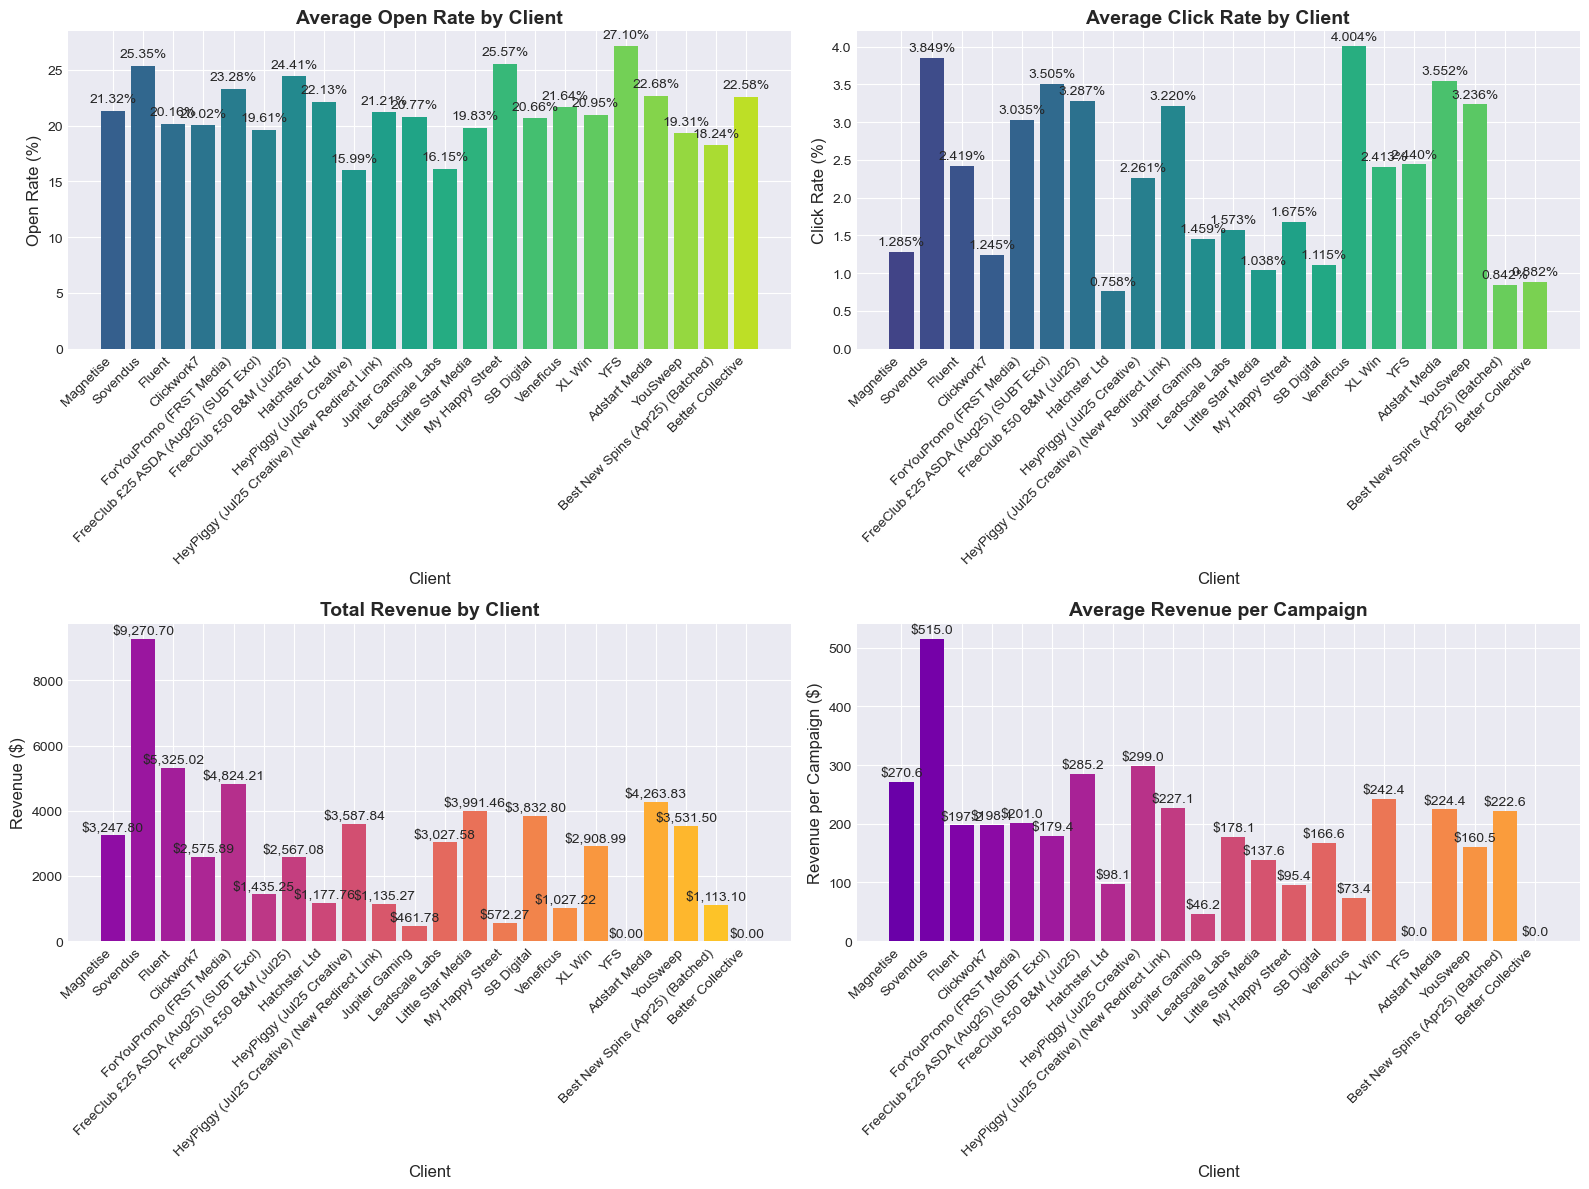

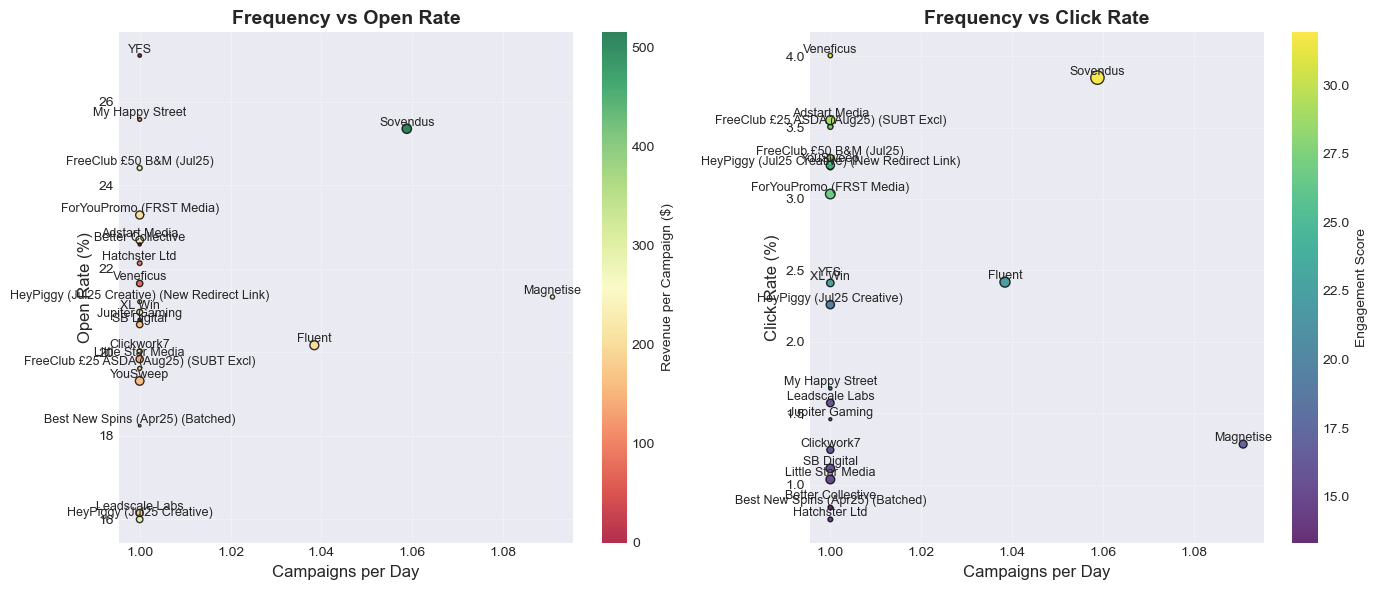

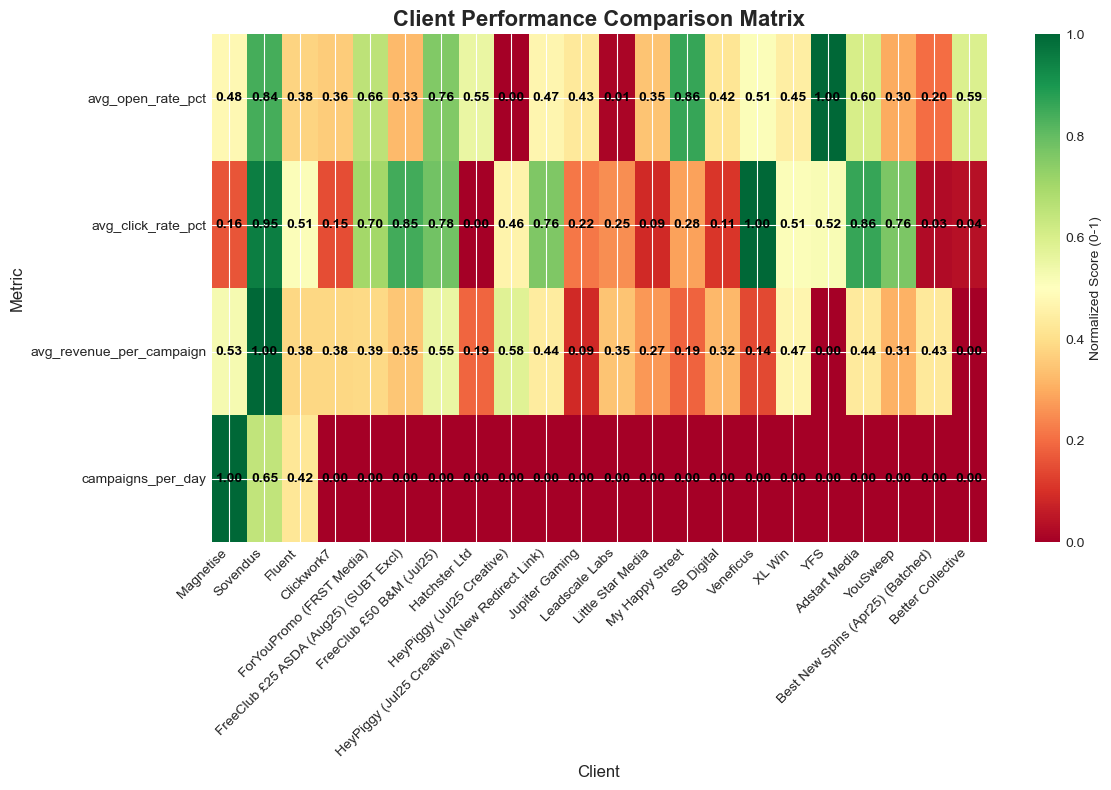

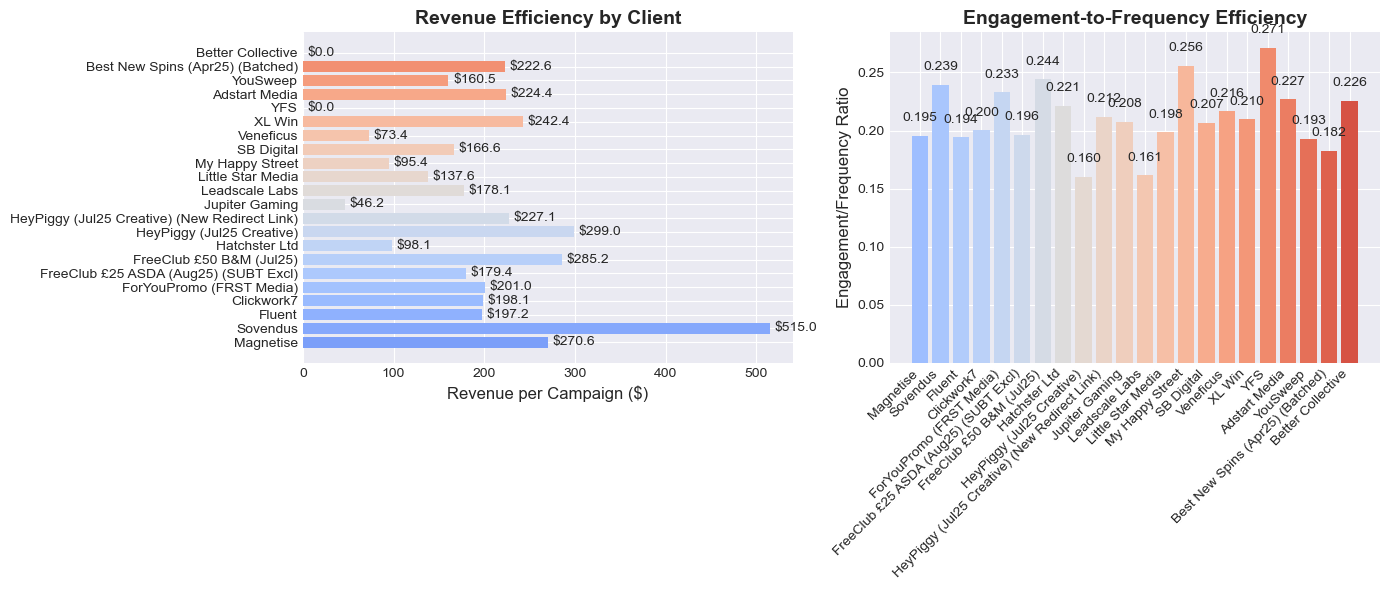

EMAIL EFFECTIVENESS & REVENUE JUSTIFICATION ANALYSIS

📊 OVERVIEW METRICS:
   • Total Clients Analyzed: 22
   • Total Campaigns: 307.0
   • Total Emails Sent: 8,288,185
   • Total Revenue Generated: $59,877.35
   • Average Open Rate: 21.32%
   • Average Click Rate: 2.231%
   • Average Campaigns per Day: 1.009
   • Average Revenue per Campaign: $182.64

📈 FREQUENCY ANALYSIS:
   • Campaigns/Day Ratio Range: 1.00 - 1.09
   • Average Ratio: 1.01
   • Most Frequent Sender: Magnetise (1.091 campaigns/day)
   • Least Frequent Sender: Clickwork7 (1.000 campaigns/day)

📊 VOLUME ANALYSIS:
   • Largest Email Volume: Sovendus (915,028 emails)
   • Smallest Email Volume: Best New Spins (Apr25) (Batched) (64,228 emails)
   • Volume Difference: 14.2x

🏆 PERFORMANCE LEADERS:
   • Highest Open Rate: YFS (27.10%)
   • Highest Click Rate: Veneficus (4.004%)
   • Highest Total Revenue: Sovendus ($9,270.70)
   • Best Revenue per Campaign: Sovendus ($515.04)

✅ EFFECTIVENESS & JUSTIFICATION:
   • NEEDS REVIE

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from decimal import Decimal

def analyze_email_effectiveness(df):
    """
    Analyzes client email effectiveness with frequency and revenue justification metrics.
    Handles decimal type conversions automatically.
    
    Parameters:
    df (DataFrame): DataFrame with client-level metrics including effectiveness and justification
    
    Returns:
    DataFrame: Enriched dataframe with calculated metrics
    """
    
    # Create a copy to avoid modifying original
    df_analysis = df.copy()
    
    # Function to safely convert values to float
    def safe_convert(val):
        if isinstance(val, Decimal):
            return float(val)
        elif isinstance(val, (int, np.integer)):
            return float(val)
        elif isinstance(val, float):
            return val
        elif isinstance(val, str):
            try:
                return float(val)
            except:
                return np.nan
        else:
            try:
                return float(val)
            except:
                return np.nan
    
    # Identify numeric columns (exclude string columns)
    numeric_cols = []
    for col in df_analysis.columns:
        # Skip client name and categorical columns
        if col in ['client', 'frequency_effectiveness', 'revenue_justification']:
            continue
        
        # Try to convert to numeric
        try:
            df_analysis[col] = pd.to_numeric(df_analysis[col], errors='coerce')
            numeric_cols.append(col)
        except:
            # If conversion fails, keep as is
            pass
    
    # Convert all numeric columns to float64 for safe operations
    for col in numeric_cols:
        df_analysis[col] = df_analysis[col].astype('float64')
    
    # Calculate additional derived metrics with safe division
    df_analysis['campaigns_per_day'] = df_analysis['total_campaigns'] / df_analysis['active_days']
    df_analysis['emails_per_day'] = df_analysis['total_sent'] / df_analysis['active_days']
    
    # Handle division by zero or NaN for revenue per email
    mask = df_analysis['total_sent'] > 0
    df_analysis['revenue_per_email'] = np.where(
        mask, 
        df_analysis['total_revenue'] / df_analysis['total_sent'], 
        np.nan
    )
    
    df_analysis['engagement_score'] = (df_analysis['avg_open_rate_pct'] * 100 + 
                                      df_analysis['avg_click_rate_pct'] * 1000) / 2
    
    # Handle division by zero for efficiency_score
    mask = df_analysis['campaigns_per_day'] > 0
    df_analysis['efficiency_score'] = np.where(
        mask,
        df_analysis['avg_revenue_per_campaign'] / df_analysis['campaigns_per_day'],
        np.nan
    )
    
    df_analysis['revenue_per_active_day'] = df_analysis['total_revenue'] / df_analysis['active_days']
    
    # Handle division by zero for engagement_to_frequency_ratio
    mask = df_analysis['campaigns_per_day'] > 0
    df_analysis['engagement_to_frequency_ratio'] = np.where(
        mask,
        df_analysis['avg_open_rate_pct'] / df_analysis['campaigns_per_day'],
        np.nan
    )
    
    # Set style for better visualization
    plt.style.use('seaborn-v0_8-darkgrid')
    sns.set_palette("husl")
    
    # 1. Frequency & Volume Analysis
    fig1, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    # Plot 1: Campaigns per day ratio
    if 'campaigns_per_day_ratio' in df_analysis.columns:
        colors = plt.cm.Set3(np.arange(len(df_analysis)))
        bars = axes[0].bar(range(len(df_analysis)), df_analysis['campaigns_per_day_ratio'], color=colors)
        axes[0].set_title('Campaigns per Day Ratio', fontsize=14, fontweight='bold')
        axes[0].set_xlabel('Client', fontsize=12)
        axes[0].set_ylabel('Campaigns/Day Ratio', fontsize=12)
        axes[0].set_xticks(range(len(df_analysis)))
        axes[0].set_xticklabels(df_analysis['client'], rotation=45, ha='right')
        axes[0].axhline(y=1.0, color='red', linestyle='--', alpha=0.5, label='1:1 Ratio')
        axes[0].legend()
        
        # Add value labels
        for i, (bar, val) in enumerate(zip(bars, df_analysis['campaigns_per_day_ratio'])):
            axes[0].text(i, val + 0.01, f'{val:.2f}', ha='center', va='bottom', fontsize=10)
    
    # Plot 2: Total campaigns
    bars2 = axes[1].bar(range(len(df_analysis)), df_analysis['total_campaigns'], 
                       color=plt.cm.Set3(np.arange(len(df_analysis)) + 2))
    axes[1].set_title('Total Campaigns by Client', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Client', fontsize=12)
    axes[1].set_ylabel('Total Campaigns', fontsize=12)
    axes[1].set_xticks(range(len(df_analysis)))
    axes[1].set_xticklabels(df_analysis['client'], rotation=45, ha='right')
    
    # Add value labels
    for i, (bar, val) in enumerate(zip(bars2, df_analysis['total_campaigns'])):
        axes[1].text(i, val + 0.5, f'{val:.0f}', ha='center', va='bottom', fontsize=10)
    
    # Plot 3: Total email volume
    bars3 = axes[2].bar(range(len(df_analysis)), df_analysis['total_sent'], 
                       color=plt.cm.Set3(np.arange(len(df_analysis)) + 4))
    axes[2].set_title('Total Email Volume', fontsize=14, fontweight='bold')
    axes[2].set_xlabel('Client', fontsize=12)
    axes[2].set_ylabel('Total Emails Sent', fontsize=12)
    axes[2].set_xticks(range(len(df_analysis)))
    axes[2].set_xticklabels(df_analysis['client'], rotation=45, ha='right')
    axes[2].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    # Add value labels
    for i, (bar, val) in enumerate(zip(bars3, df_analysis['total_sent'])):
        axes[2].text(i, val + 10000, f'{val:,.0f}', ha='center', va='bottom', fontsize=10)
    
    # Plot 4: Emails per day
    bars4 = axes[3].bar(range(len(df_analysis)), df_analysis['emails_per_day'], 
                       color=plt.cm.Set3(np.arange(len(df_analysis)) + 6))
    axes[3].set_title('Average Emails per Day', fontsize=14, fontweight='bold')
    axes[3].set_xlabel('Client', fontsize=12)
    axes[3].set_ylabel('Emails/Day', fontsize=12)
    axes[3].set_xticks(range(len(df_analysis)))
    axes[3].set_xticklabels(df_analysis['client'], rotation=45, ha='right')
    axes[3].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    # Add value labels
    for i, (bar, val) in enumerate(zip(bars4, df_analysis['emails_per_day'])):
        axes[3].text(i, val + 1000, f'{val:,.0f}', ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # 2. Engagement & Revenue Performance
    fig2, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    # Plot 5: Open Rates
    bars5 = axes[0].bar(range(len(df_analysis)), df_analysis['avg_open_rate_pct'] * 100, 
                       color=plt.cm.viridis(np.linspace(0.3, 0.9, len(df_analysis))))
    axes[0].set_title('Average Open Rate by Client', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Client', fontsize=12)
    axes[0].set_ylabel('Open Rate (%)', fontsize=12)
    axes[0].set_xticks(range(len(df_analysis)))
    axes[0].set_xticklabels(df_analysis['client'], rotation=45, ha='right')
    
    # Add value labels
    for i, (bar, val) in enumerate(zip(bars5, df_analysis['avg_open_rate_pct'] * 100)):
        axes[0].text(i, val + 0.5, f'{val:.2f}%', ha='center', va='bottom', fontsize=10)
    
    # Plot 6: Click Rates
    bars6 = axes[1].bar(range(len(df_analysis)), df_analysis['avg_click_rate_pct'] * 100, 
                       color=plt.cm.viridis(np.linspace(0.2, 0.8, len(df_analysis))))
    axes[1].set_title('Average Click Rate by Client', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Client', fontsize=12)
    axes[1].set_ylabel('Click Rate (%)', fontsize=12)
    axes[1].set_xticks(range(len(df_analysis)))
    axes[1].set_xticklabels(df_analysis['client'], rotation=45, ha='right')
    
    # Add value labels
    for i, (bar, val) in enumerate(zip(bars6, df_analysis['avg_click_rate_pct'] * 100)):
        axes[1].text(i, val + 0.05, f'{val:.3f}%', ha='center', va='bottom', fontsize=10)
    
    # Plot 7: Total Revenue
    bars7 = axes[2].bar(range(len(df_analysis)), df_analysis['total_revenue'], 
                       color=plt.cm.plasma(np.linspace(0.3, 0.9, len(df_analysis))))
    axes[2].set_title('Total Revenue by Client', fontsize=14, fontweight='bold')
    axes[2].set_xlabel('Client', fontsize=12)
    axes[2].set_ylabel('Revenue ($)', fontsize=12)
    axes[2].set_xticks(range(len(df_analysis)))
    axes[2].set_xticklabels(df_analysis['client'], rotation=45, ha='right')
    
    # Add value labels
    for i, (bar, val) in enumerate(zip(bars7, df_analysis['total_revenue'])):
        axes[2].text(i, val + 50, f'${val:,.2f}', ha='center', va='bottom', fontsize=10)
    
    # Plot 8: Average Revenue per Campaign
    bars8 = axes[3].bar(range(len(df_analysis)), df_analysis['avg_revenue_per_campaign'], 
                       color=plt.cm.plasma(np.linspace(0.2, 0.8, len(df_analysis))))
    axes[3].set_title('Average Revenue per Campaign', fontsize=14, fontweight='bold')
    axes[3].set_xlabel('Client', fontsize=12)
    axes[3].set_ylabel('Revenue per Campaign ($)', fontsize=12)
    axes[3].set_xticks(range(len(df_analysis)))
    axes[3].set_xticklabels(df_analysis['client'], rotation=45, ha='right')
    
    # Add value labels
    for i, (bar, val) in enumerate(zip(bars8, df_analysis['avg_revenue_per_campaign'])):
        axes[3].text(i, val + 5, f'${val:,.1f}', ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # 3. Scatter Analysis: Frequency vs Performance
    fig3, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot 9: Frequency vs Open Rate
    if len(df_analysis) > 0:
        scatter1 = axes[0].scatter(df_analysis['campaigns_per_day'], 
                                  df_analysis['avg_open_rate_pct'] * 100,
                                  s=df_analysis['total_sent']/20000,
                                  c=df_analysis['avg_revenue_per_campaign'],
                                  cmap='RdYlGn',
                                  alpha=0.8,
                                  edgecolors='black')
        
        # Add client labels
        for i, row in df_analysis.iterrows():
            axes[0].annotate(row['client'], 
                           (row['campaigns_per_day'], row['avg_open_rate_pct'] * 100),
                           fontsize=9, ha='center', va='bottom')
        
        axes[0].set_title('Frequency vs Open Rate', fontsize=14, fontweight='bold')
        axes[0].set_xlabel('Campaigns per Day', fontsize=12)
        axes[0].set_ylabel('Open Rate (%)', fontsize=12)
        axes[0].grid(True, alpha=0.3)
        
        # Add colorbar
        cbar1 = fig3.colorbar(scatter1, ax=axes[0])
        cbar1.set_label('Revenue per Campaign ($)', fontsize=10)
    
    # Plot 10: Frequency vs Click Rate
    if len(df_analysis) > 0:
        scatter2 = axes[1].scatter(df_analysis['campaigns_per_day'], 
                                  df_analysis['avg_click_rate_pct'] * 100,
                                  s=df_analysis['total_revenue']/100,
                                  c=df_analysis['engagement_score'],
                                  cmap='viridis',
                                  alpha=0.8,
                                  edgecolors='black')
        
        # Add client labels
        for i, row in df_analysis.iterrows():
            axes[1].annotate(row['client'], 
                           (row['campaigns_per_day'], row['avg_click_rate_pct'] * 100),
                           fontsize=9, ha='center', va='bottom')
        
        axes[1].set_title('Frequency vs Click Rate', fontsize=14, fontweight='bold')
        axes[1].set_xlabel('Campaigns per Day', fontsize=12)
        axes[1].set_ylabel('Click Rate (%)', fontsize=12)
        axes[1].grid(True, alpha=0.3)
        
        # Add colorbar
        cbar2 = fig3.colorbar(scatter2, ax=axes[1])
        cbar2.set_label('Engagement Score', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # 4. Performance Comparison Matrix
    if len(df_analysis) > 1:
        fig4, ax = plt.subplots(figsize=(12, 8))
        
        # Create normalized scores for comparison
        metrics_to_compare = ['avg_open_rate_pct', 'avg_click_rate_pct', 
                             'avg_revenue_per_campaign', 'campaigns_per_day']
        
        # Normalize each metric (0-1 scale)
        normalized_scores = pd.DataFrame()
        for metric in metrics_to_compare:
            if metric in df_analysis.columns:
                min_val = df_analysis[metric].min()
                max_val = df_analysis[metric].max()
                if max_val > min_val:
                    normalized_scores[metric] = (df_analysis[metric] - min_val) / (max_val - min_val)
                else:
                    normalized_scores[metric] = 0.5
        
        # Add client names
        normalized_scores['client'] = df_analysis['client']
        
        # Pivot for heatmap
        heatmap_data = normalized_scores.set_index('client').T
        
        # Create heatmap
        im = ax.imshow(heatmap_data, cmap='RdYlGn', aspect='auto')
        ax.set_title('Client Performance Comparison Matrix', fontsize=16, fontweight='bold')
        ax.set_xlabel('Client', fontsize=12)
        ax.set_ylabel('Metric', fontsize=12)
        
        # Set ticks
        ax.set_xticks(np.arange(len(heatmap_data.columns)))
        ax.set_yticks(np.arange(len(heatmap_data.index)))
        ax.set_xticklabels(heatmap_data.columns, rotation=45, ha='right')
        ax.set_yticklabels(heatmap_data.index)
        
        # Add text annotations
        for i in range(len(heatmap_data.index)):
            for j in range(len(heatmap_data.columns)):
                value = heatmap_data.iloc[i, j]
                ax.text(j, i, f'{value:.2f}', ha="center", va="center", 
                       color="black", fontsize=10, fontweight='bold')
        
        # Add colorbar
        cbar = fig4.colorbar(im, ax=ax)
        cbar.set_label('Normalized Score (0-1)', fontsize=10)
        
        plt.tight_layout()
        plt.show()
    
    # 5. Revenue Efficiency Analysis
    fig5, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot 11: Revenue per Campaign by Client
    axes[0].barh(range(len(df_analysis)), df_analysis['avg_revenue_per_campaign'], 
                color=plt.cm.coolwarm(np.linspace(0.2, 0.8, len(df_analysis))))
    axes[0].set_yticks(range(len(df_analysis)))
    axes[0].set_yticklabels(df_analysis['client'])
    axes[0].set_xlabel('Revenue per Campaign ($)', fontsize=12)
    axes[0].set_title('Revenue Efficiency by Client', fontsize=14, fontweight='bold')
    
    # Add value labels
    for i, val in enumerate(df_analysis['avg_revenue_per_campaign']):
        axes[0].text(val + 5, i, f'${val:,.1f}', va='center', fontsize=10)
    
    # Plot 12: Engagement-to-Frequency Ratio
    axes[1].bar(range(len(df_analysis)), df_analysis['engagement_to_frequency_ratio'], 
               color=plt.cm.coolwarm(np.linspace(0.3, 0.9, len(df_analysis))))
    axes[1].set_xticks(range(len(df_analysis)))
    axes[1].set_xticklabels(df_analysis['client'], rotation=45, ha='right')
    axes[1].set_ylabel('Engagement/Frequency Ratio', fontsize=12)
    axes[1].set_title('Engagement-to-Frequency Efficiency', fontsize=14, fontweight='bold')
    
    # Add value labels
    for i, val in enumerate(df_analysis['engagement_to_frequency_ratio']):
        axes[1].text(i, val + 0.01, f'{val:.3f}', ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # Generate Comprehensive Insights
    print("="*80)
    print("EMAIL EFFECTIVENESS & REVENUE JUSTIFICATION ANALYSIS")
    print("="*80)
    
    # Calculate overall metrics
    total_clients = len(df_analysis)
    total_campaigns = df_analysis['total_campaigns'].sum()
    total_emails = df_analysis['total_sent'].sum()
    total_revenue = df_analysis['total_revenue'].sum()
    
    print(f"\n📊 OVERVIEW METRICS:")
    print(f"   • Total Clients Analyzed: {total_clients}")
    print(f"   • Total Campaigns: {total_campaigns:,}")
    print(f"   • Total Emails Sent: {total_emails:,.0f}")
    print(f"   • Total Revenue Generated: ${total_revenue:,.2f}")
    
    if total_clients > 0:
        avg_open_rate = df_analysis['avg_open_rate_pct'].mean() * 100
        avg_click_rate = df_analysis['avg_click_rate_pct'].mean() * 100
        avg_campaigns_per_day = df_analysis['campaigns_per_day'].mean()
        avg_revenue_per_campaign = df_analysis['avg_revenue_per_campaign'].mean()
        
        print(f"   • Average Open Rate: {avg_open_rate:.2f}%")
        print(f"   • Average Click Rate: {avg_click_rate:.3f}%")
        print(f"   • Average Campaigns per Day: {avg_campaigns_per_day:.3f}")
        print(f"   • Average Revenue per Campaign: ${avg_revenue_per_campaign:.2f}")
    
    # Frequency Analysis
    print(f"\n📈 FREQUENCY ANALYSIS:")
    
    if total_clients > 0:
        if 'campaigns_per_day_ratio' in df_analysis.columns:
            ratio_stats = df_analysis['campaigns_per_day_ratio'].describe()
            print(f"   • Campaigns/Day Ratio Range: {ratio_stats['min']:.2f} - {ratio_stats['max']:.2f}")
            print(f"   • Average Ratio: {ratio_stats['mean']:.2f}")
        
        # Find most and least frequent
        if 'campaigns_per_day' in df_analysis.columns:
            most_frequent_idx = df_analysis['campaigns_per_day'].idxmax()
            least_frequent_idx = df_analysis['campaigns_per_day'].idxmin()
            
            most_frequent = df_analysis.loc[most_frequent_idx]
            least_frequent = df_analysis.loc[least_frequent_idx]
            
            print(f"   • Most Frequent Sender: {most_frequent['client']} "
                  f"({most_frequent['campaigns_per_day']:.3f} campaigns/day)")
            print(f"   • Least Frequent Sender: {least_frequent['client']} "
                  f"({least_frequent['campaigns_per_day']:.3f} campaigns/day)")
    
    # Volume Analysis
    print(f"\n📊 VOLUME ANALYSIS:")
    
    if total_clients > 0:
        largest_volume_idx = df_analysis['total_sent'].idxmax()
        smallest_volume_idx = df_analysis['total_sent'].idxmin()
        
        largest_volume = df_analysis.loc[largest_volume_idx]
        smallest_volume = df_analysis.loc[smallest_volume_idx]
        
        print(f"   • Largest Email Volume: {largest_volume['client']} "
              f"({largest_volume['total_sent']:,.0f} emails)")
        print(f"   • Smallest Email Volume: {smallest_volume['client']} "
              f"({smallest_volume['total_sent']:,.0f} emails)")
        
        if smallest_volume['total_sent'] > 0:
            volume_ratio = largest_volume['total_sent'] / smallest_volume['total_sent']
            print(f"   • Volume Difference: {volume_ratio:.1f}x")
    
    # Performance Leaders
    print(f"\n🏆 PERFORMANCE LEADERS:")
    
    if total_clients > 0:
        # Find best performers
        best_open_idx = df_analysis['avg_open_rate_pct'].idxmax()
        best_click_idx = df_analysis['avg_click_rate_pct'].idxmax()
        best_revenue_idx = df_analysis['total_revenue'].idxmax()
        best_revenue_per_campaign_idx = df_analysis['avg_revenue_per_campaign'].idxmax()
        
        best_open = df_analysis.loc[best_open_idx]
        best_click = df_analysis.loc[best_click_idx]
        best_revenue = df_analysis.loc[best_revenue_idx]
        best_revenue_per_campaign = df_analysis.loc[best_revenue_per_campaign_idx]
        
        print(f"   • Highest Open Rate: {best_open['client']} "
              f"({best_open['avg_open_rate_pct']*100:.2f}%)")
        print(f"   • Highest Click Rate: {best_click['client']} "
              f"({best_click['avg_click_rate_pct']*100:.3f}%)")
        print(f"   • Highest Total Revenue: {best_revenue['client']} "
              f"(${best_revenue['total_revenue']:,.2f})")
        print(f"   • Best Revenue per Campaign: {best_revenue_per_campaign['client']} "
              f"(${best_revenue_per_campaign['avg_revenue_per_campaign']:,.2f})")
    
    # Effectiveness & Justification Analysis
    print(f"\n✅ EFFECTIVENESS & JUSTIFICATION:")
    
    if 'frequency_effectiveness' in df_analysis.columns:
        effectiveness_counts = df_analysis['frequency_effectiveness'].value_counts()
        for category, count in effectiveness_counts.items():
            percentage = (count / total_clients) * 100
            print(f"   • {category}: {count} client(s) ({percentage:.1f}%)")
    
    if 'revenue_justification' in df_analysis.columns:
        # Extract justification categories
        justification_categories = []
        for justification in df_analysis['revenue_justification']:
            if isinstance(justification, str):
                category = justification.split(':')[0] if ':' in justification else justification
                justification_categories.append(category)
        
        if justification_categories:
            from collections import Counter
            justification_counts = Counter(justification_categories)
            for category, count in justification_counts.items():
                percentage = (count / total_clients) * 100
                print(f"   • {category}: {count} client(s) ({percentage:.1f}%)")
    
    # Efficiency Metrics
    print(f"\n⚡ EFFICIENCY METRICS:")
    
    if total_clients > 0:
        # Calculate revenue per thousand emails
        df_analysis['revenue_per_thousand'] = (df_analysis['total_revenue'] / df_analysis['total_sent']) * 1000
        
        best_efficiency_idx = df_analysis['revenue_per_thousand'].idxmax()
        worst_efficiency_idx = df_analysis['revenue_per_thousand'].idxmin()
        
        best_efficiency = df_analysis.loc[best_efficiency_idx]
        worst_efficiency = df_analysis.loc[worst_efficiency_idx]
        
        print(f"   • Most Efficient: {best_efficiency['client']} "
              f"(${best_efficiency['revenue_per_thousand']:.2f} per 1000 emails)")
        print(f"   • Least Efficient: {worst_efficiency['client']} "
              f"(${worst_efficiency['revenue_per_thousand']:.2f} per 1000 emails)")
        
        avg_efficiency = df_analysis['revenue_per_thousand'].mean()
        print(f"   • Average Efficiency: ${avg_efficiency:.2f} per 1000 emails")
    
    # Correlation Analysis (if enough clients)
    if total_clients >= 3:
        print(f"\n🔗 CORRELATION INSIGHTS:")
        
        try:
            # Calculate correlations
            if 'campaigns_per_day' in df_analysis.columns:
                freq_open_corr = df_analysis['campaigns_per_day'].corr(df_analysis['avg_open_rate_pct'])
                freq_click_corr = df_analysis['campaigns_per_day'].corr(df_analysis['avg_click_rate_pct'])
                freq_revenue_corr = df_analysis['campaigns_per_day'].corr(df_analysis['avg_revenue_per_campaign'])
                
                print(f"   • Frequency vs Open Rate: {freq_open_corr:.3f}")
                print(f"   • Frequency vs Click Rate: {freq_click_corr:.3f}")
                print(f"   • Frequency vs Revenue/Campaign: {freq_revenue_corr:.3f}")
                
                # Interpret correlations
                if abs(freq_open_corr) > 0.5:
                    direction = "positive" if freq_open_corr > 0 else "negative"
                    print(f"     → Strong {direction} relationship between frequency and open rates")
                elif abs(freq_open_corr) > 0.3:
                    direction = "positive" if freq_open_corr > 0 else "negative"
                    print(f"     → Moderate {direction} relationship between frequency and open rates")
                
                if freq_revenue_corr > 0.3:
                    print(f"     → Higher frequency associated with higher revenue per campaign")
                elif freq_revenue_corr < -0.3:
                    print(f"     → Higher frequency associated with lower revenue per campaign")
                    
        except Exception as e:
            print(f"   • Correlation analysis limited by data size or variability")
    
    # Recommendations
    print("\n" + "="*80)
    print("ACTIONABLE RECOMMENDATIONS")
    print("="*80)
    
    recommendations = []
    
    # Analyze each client
    for _, client in df_analysis.iterrows():
        client_name = client['client']
        
        # Check engagement levels
        if 'avg_open_rate_pct' in client and 'avg_click_rate_pct' in client:
            open_rate = client['avg_open_rate_pct'] * 100
            click_rate = client['avg_click_rate_pct'] * 100
            
            if open_rate < 20:  # Below 20% open rate
                recommendations.append(
                    f"• {client_name}: Low open rate ({open_rate:.1f}%) - "
                    f"review subject lines and send times"
                )
            
            if click_rate < 1.0 and open_rate > 20:  # Low CTR with decent opens
                recommendations.append(
                    f"• {client_name}: Low click-through ({click_rate:.3f}%) despite good opens - "
                    f"improve content relevance and CTAs"
                )
        
        # Check frequency effectiveness
        if 'frequency_effectiveness' in client and client['frequency_effectiveness'] == 'NEEDS REVIEW':
            if 'campaigns_per_day' in client and client['campaigns_per_day'] > 1.2:
                recommendations.append(
                    f"• {client_name}: High frequency needs review - "
                    f"consider audience fatigue risk"
                )
        
        # Check revenue efficiency
        if 'revenue_per_thousand' in client:
            efficiency = client['revenue_per_thousand']
            if efficiency < 5:  # Less than $5 per 1000 emails
                recommendations.append(
                    f"• {client_name}: Low revenue efficiency (${efficiency:.2f}/1000) - "
                    f"review offer strategy"
                )
    
    # Cross-client opportunities
    if total_clients > 1:
        # Identify best practices
        best_practices = []
        
        if 'avg_open_rate_pct' in df_analysis.columns:
            best_open_client = df_analysis.loc[df_analysis['avg_open_rate_pct'].idxmax()]['client']
            best_practices.append(f"{best_open_client} (open rate)")
        
        if 'avg_click_rate_pct' in df_analysis.columns:
            best_click_client = df_analysis.loc[df_analysis['avg_click_rate_pct'].idxmax()]['client']
            best_practices.append(f"{best_click_client} (click rate)")
        
        if 'avg_revenue_per_campaign' in df_analysis.columns:
            best_rev_client = df_analysis.loc[df_analysis['avg_revenue_per_campaign'].idxmax()]['client']
            best_practices.append(f"{best_rev_client} (revenue efficiency)")
        
        if best_practices:
            recommendations.append(
                f"• Knowledge sharing opportunity: Best practices from " + 
                ", ".join(best_practices) + " should be reviewed by all teams"
            )
    
    # Output recommendations
    if recommendations:
        for rec in recommendations[:5]:  # Limit to top 5 recommendations
            print(rec)
        
        if len(recommendations) > 5:
            print(f"• ... and {len(recommendations) - 5} more specific recommendations")
    else:
        print("• Current strategies appear effective for all clients")
        print("• Focus on incremental optimizations and A/B testing")
    
    # Key Insights Summary
    print(f"\n🎯 KEY INSIGHTS SUMMARY:")
    
    # Identify top insight
    if total_clients > 0:
        # Check if all have same justification
        if 'revenue_justification' in df_analysis.columns:
            unique_justifications = df_analysis['revenue_justification'].nunique()
            if unique_justifications == 1:
                justification = df_analysis['revenue_justification'].iloc[0]
                print(f"   • All clients have the same revenue justification: {justification}")
        
        # Check effectiveness status
        if 'frequency_effectiveness' in df_analysis.columns:
            if df_analysis['frequency_effectiveness'].eq('NEEDS REVIEW').all():
                print(f"   • All clients require frequency effectiveness review")
        
        # Volume vs revenue insight
        if total_emails > 0:
            overall_efficiency = total_revenue / total_emails
            print(f"   • Overall email efficiency: ${overall_efficiency:.6f} per email")
            
            if overall_efficiency < 0.01:
                print(f"   • Opportunity: Focus on increasing revenue per email across all clients")
    
    print("\n" + "="*80)
    
    return df_analysis

# Usage example with your actual dataframe:
result_df = analyze_email_effectiveness(df)